In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/NARSAD/'
os.chdir(path)


### tests

In [3]:
# to iterate through subjects ... 
#for sub in subjects 
sub = 'N234'
# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')

# don't need to print when iterating through lots of subjects 
fmri_imgs = [fmri_imgs[0], fmri_imgs[1]] #ignoring rest for now
fmri_imgs

['/Volumes/Seagate Desktop Drive/NARSAD/derivatives/sub-N234/ses-01/func/sub-N234_ses-01_task-phase2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 '/Volumes/Seagate Desktop Drive/NARSAD/derivatives/sub-N234/ses-01/func/sub-N234_ses-01_task-phase3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

In [4]:
#set arbitrary initial parameters -- check with Noah/Kelly or Ariel (or Angela?) about these parameters and what makes the most sense 
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

confound_files = layout.get(subject=sub,
                            datatype='func',
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                   'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                     'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                     'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                     'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                     'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                     'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                     'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                    ]

final_confounds = confound_vars

design_matrices = []

Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


First Level Design Matrix completed


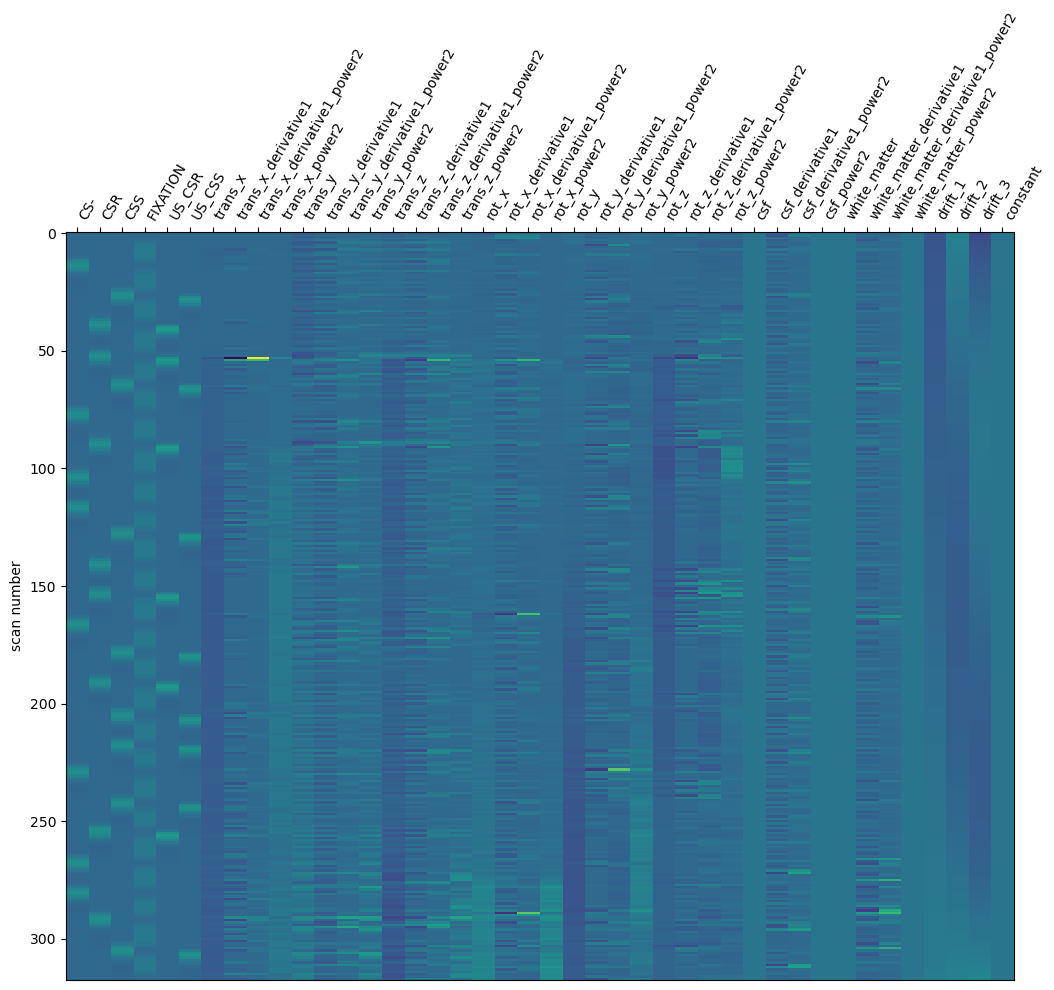

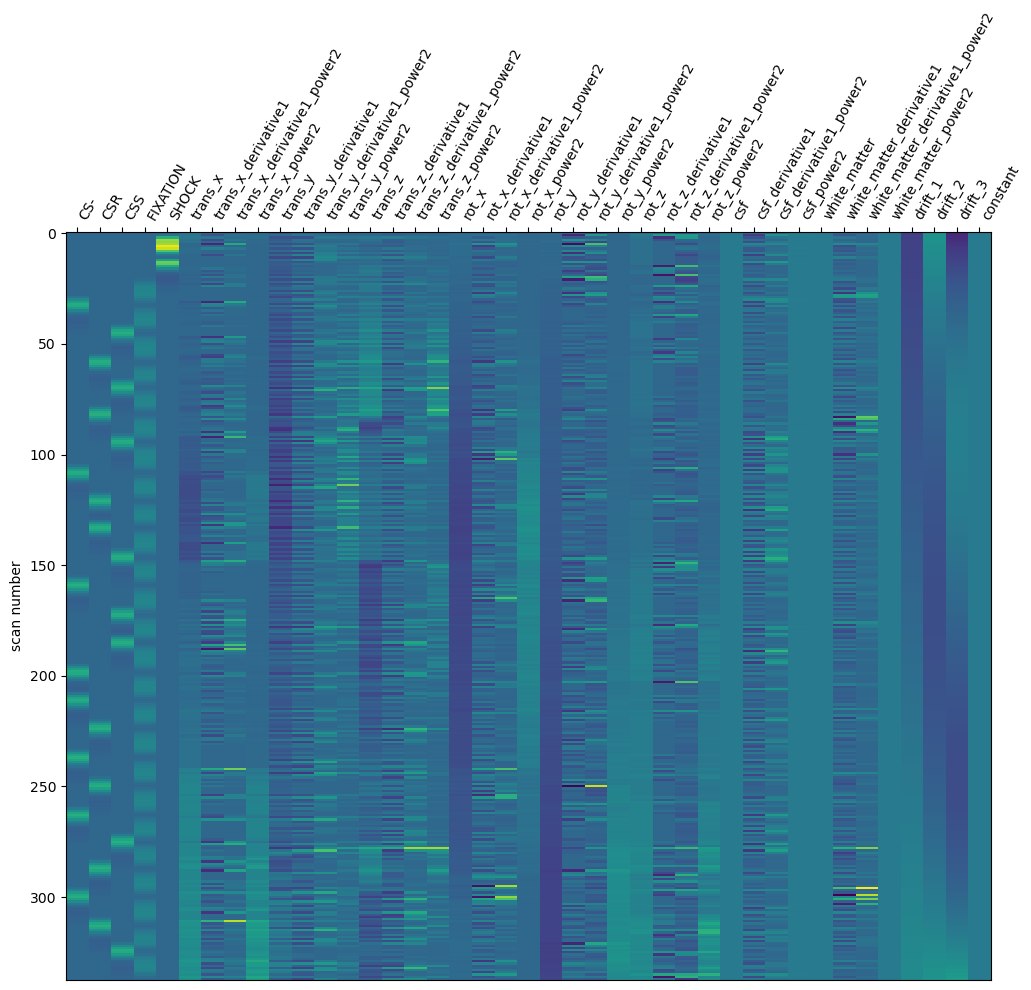

In [5]:
print("Creating First Level Design matrix ... ")
for idx, img in enumerate(fmri_imgs):
    # Build experimental paradigm
    phaseno = idx
    if idx == 0:
        task='phase2'
    else:
        task='phase3'
    events,tr,n_scans = load_bids_events(layout, onsets, sub, task, phaseno)
    # Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[phaseno]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)

    # Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    # put the design matrices in a list
    design_matrices.append(design_matrix)

print("First Level Design Matrix completed")


phase = 0
# Iterate on contrasts
for phase in design_matrices:
    plot_design_matrix(phase)   

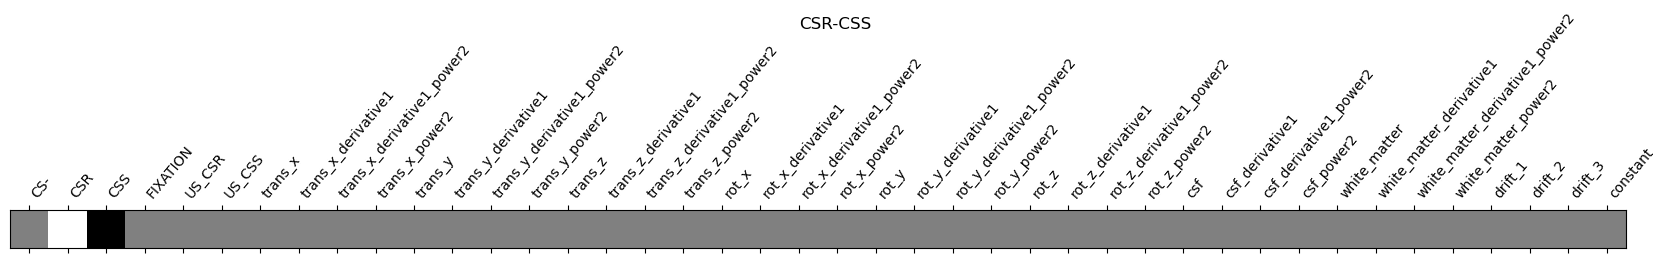

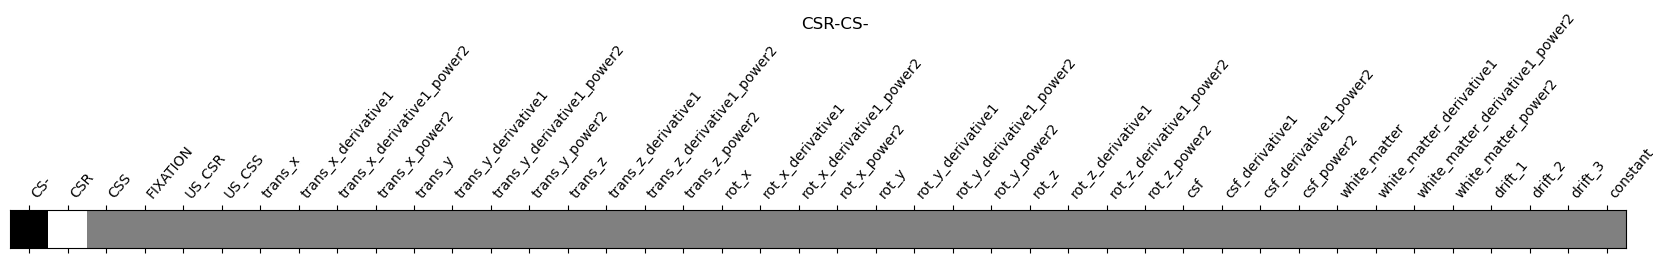

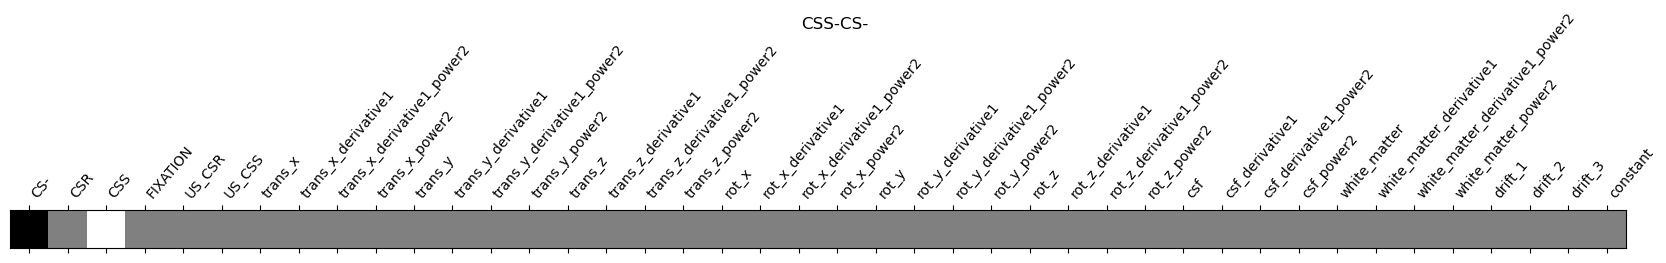

In [6]:
# Creating contrasts -- 
### change depending on task / ideal contrasts 
design_matrix = design_matrices[0]
contrast_matrix2 = []
contrast_matrix2 = np.eye(design_matrix.shape[1])
basic_contrasts2 = {
    column: contrast_matrix2[i]
    for i, column in enumerate(design_matrix.columns)
}
contrasts2 = {
    "CSR-CSS": (basic_contrasts2["CSR"] - basic_contrasts2["CSS"]),   
    "CSR-CS-": (basic_contrasts2["CSR"] - basic_contrasts2["CS-"]),   
    "CSS-CS-": (basic_contrasts2["CSS"] - basic_contrasts2["CS-"]),   
}

from nilearn.plotting import plot_contrast_matrix
for key, values in contrasts2.items():
    plot_contrast_matrix(values, design_matrix=design_matrices[0])
    plt.suptitle(key)
plt.show()


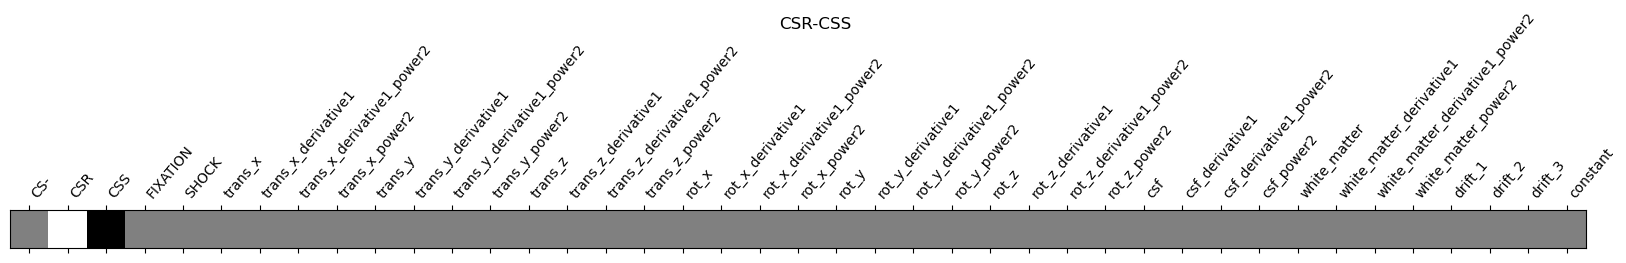

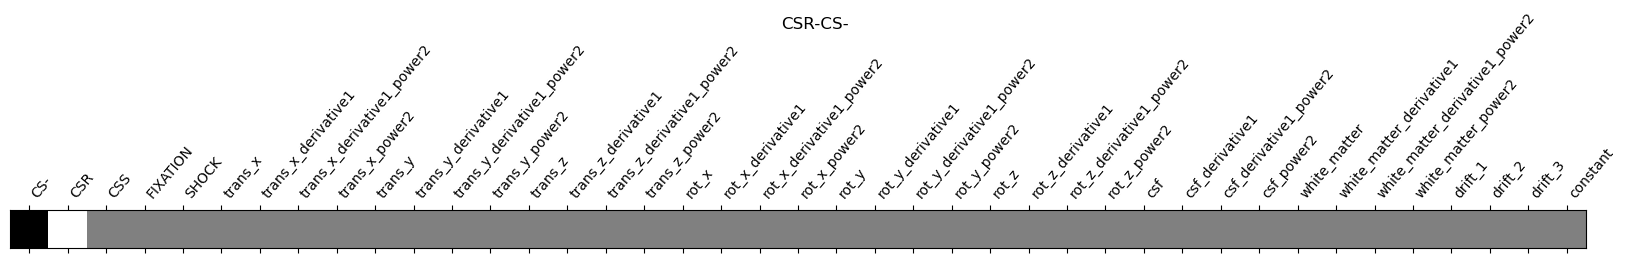

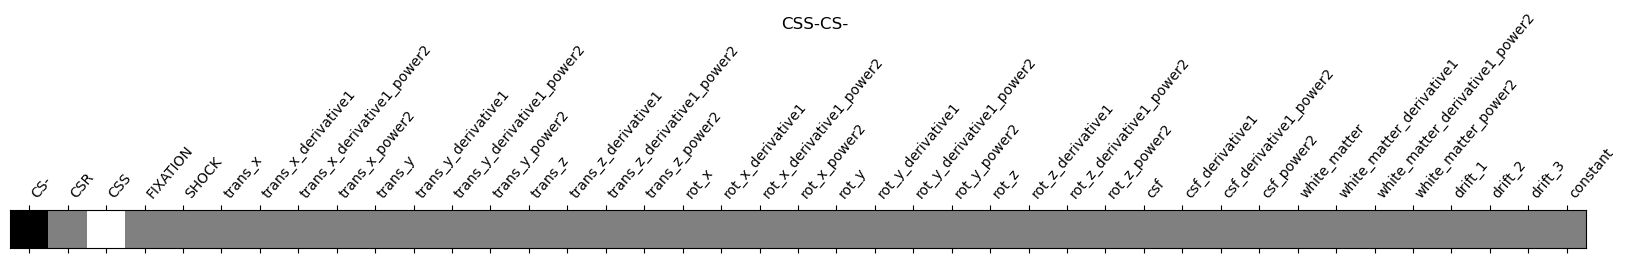

In [7]:
design_matrix = []
design_matrix = design_matrices[1]

contrast_matrix3 = []
contrast_matrix3 = np.eye(design_matrix.shape[1])
basic_contrasts3 = {
    column: contrast_matrix3[i]
    for i, column in enumerate(design_matrix.columns)
}
contrasts3 = {
    "CSR-CSS": (basic_contrasts3["CSR"] - basic_contrasts3["CSS"]),   
    "CSR-CS-": (basic_contrasts3["CSR"] - basic_contrasts3["CS-"]),   
    "CSS-CS-": (basic_contrasts3["CSS"] - basic_contrasts3["CS-"]),   
}

from nilearn.plotting import plot_contrast_matrix
for key, values in contrasts3.items():
    plot_contrast_matrix(values, design_matrix=design_matrices[1])
    plt.suptitle(key)
plt.show()

In [8]:
from nilearn.glm.first_level import FirstLevelModel

fmri_glm_phase2 = []
fmri_glm_phase3 = []

print("Fitting Phase 2 GLM ...")
fmri_glm_phase2 = FirstLevelModel()
fmri_glm_phase2 = fmri_glm_phase2.fit(fmri_imgs[0], design_matrices=design_matrices[0])

print("Phase2 first level completed")

print("Fitting Phase 3 GLM ...")
fmri_glm_phase3 = FirstLevelModel()
fmri_glm_phase3 = fmri_glm_phase3.fit(fmri_imgs[1], design_matrices=design_matrices[1])

print("Phase3 first level completed")

Fitting Phase 2 GLM ...
Phase2 first level completed
Fitting Phase 3 GLM ...
Phase3 first level completed


Phase 2 Contrasts

Computing contrasts
	contrast id: CSR-CSS


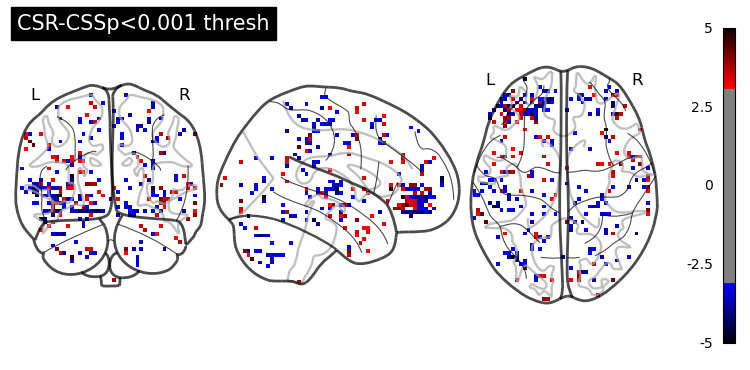

	contrast id: CSR-CS-


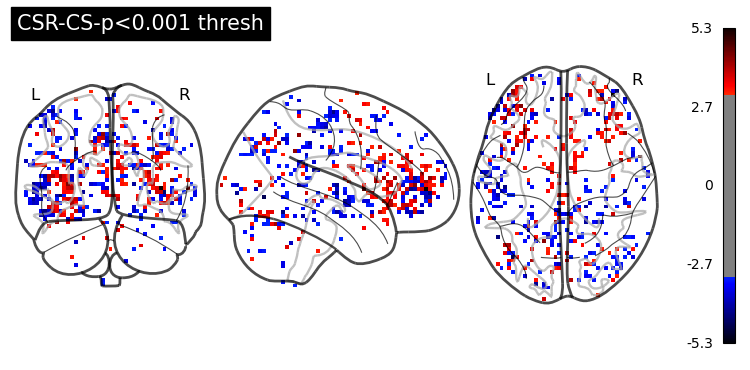

	contrast id: CSS-CS-


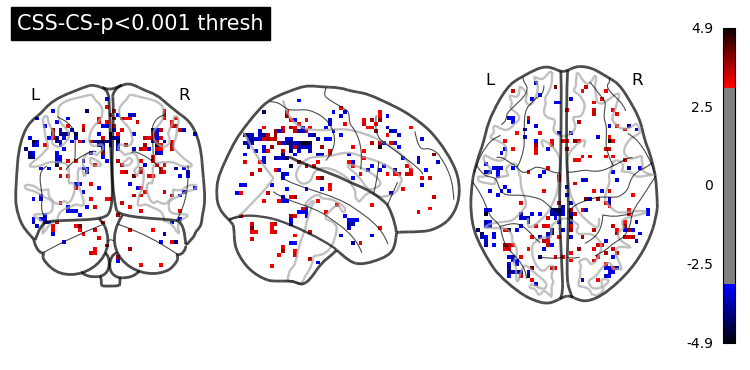

In [12]:
# plotting: 
print('\033[1m' + "Phase 2 Contrasts")
print('\033[0m')

from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img

from scipy.stats import norm

p001_unc = norm.isf(0.001)

mean_image = mean_img(fmri_imgs[0])

print("Computing contrasts")

# Iterate on contrasts
for contrast_id, contrast_val in contrasts2.items():
    print(f"\tcontrast id: {contrast_id}")
    # compute the contrasts
    betas2 = fmri_glm_phase2.compute_contrast(contrast_val, output_type="effect_size") # outputs = betas 
    z_map2 = fmri_glm_phase2.compute_contrast(contrast_val, output_type="z_score") # outputs = z_score
    # plot the contrasts as soon as they're generated
    # the display is overlaid on the mean fMRI image
    # a threshold of 3.0 is used, more sophisticated choices are possible
    plotting.plot_glass_brain(
        z_map2,
        threshold=p001_unc,
        display_mode="ortho",
        title=contrast_id+ "p<0.001 thresh",
        plot_abs=False,
        colorbar=True
    )
    plotting.show()

Phase 3 Contrasts

	contrast id: CSR-CSS


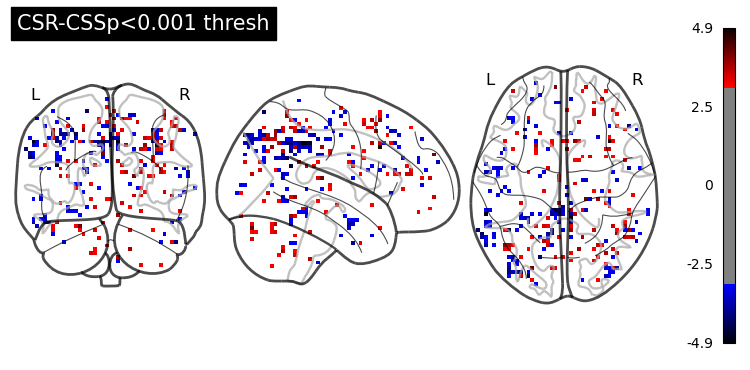

	contrast id: CSR-CS-


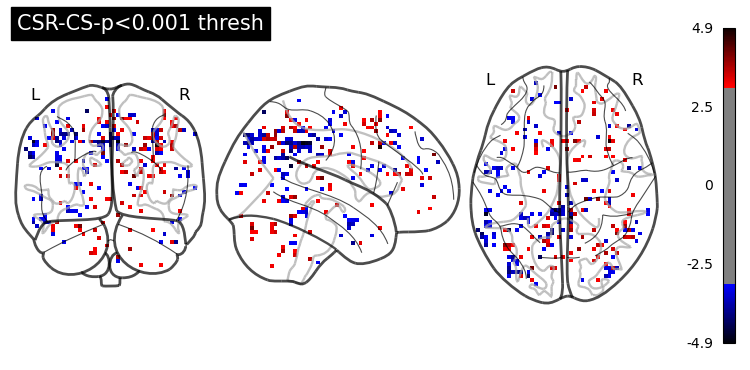

	contrast id: CSS-CS-


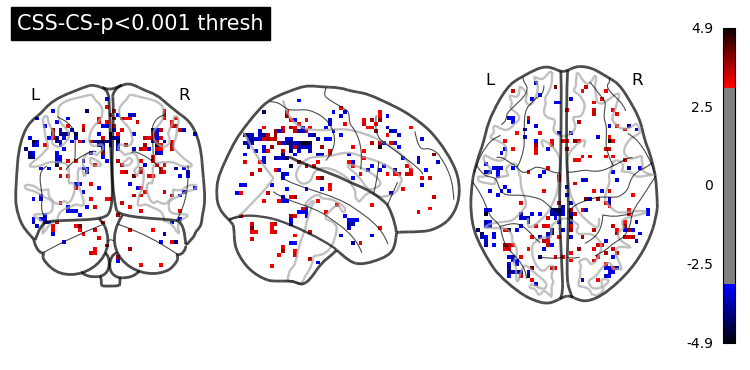

In [13]:
print('\033[1m' + "Phase 3 Contrasts")
print('\033[0m')

mean_image = mean_img(fmri_imgs[1])

for contrast_id, contrast_val in contrasts3.items():
    print(f"\tcontrast id: {contrast_id}")
    # compute the contrasts
    betas3 = fmri_glm_phase3.compute_contrast(contrast_val, output_type="effect_size") # outputs = betas 
    z_map3 = fmri_glm_phase3.compute_contrast(contrast_val, output_type="z_score") # outputs = z_score
    # plot the contrasts as soon as they're generated
    # the display is overlaid on the mean fMRI image
    # a threshold of 3.0 is used, more sophisticated choices are possible
    plotting.plot_glass_brain(
        z_map2,
        threshold=p001_unc,
        display_mode="ortho",
        title=contrast_id+ "p<0.001 thresh",
        plot_abs=False,
        colorbar=True
    )
    plotting.show()

# Whole-brain analysis (volume-space): 

### First-level processing for all subjects (whole-brain)

In [ ]:
from narsad_first_level import load_bids_events, create_and_fit_glm

layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/NARSAD/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

subjects = layout.get_subjects()
del(subjects[0]) #sub101 has 2mm seq 
del(subjects[14]) #sub120 missing phase 3 
del(subjects[43]) # sub201, has 2mm seq 

onsets_phase2 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=0)
onsets_phase3 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=1)
onsets = onsets_phase2, onsets_phase3
output_dir = "/Volumes/Seagate Desktop Drive/NARSAD/results"

file_lists_phase2, file_lists_phase3 = create_and_fit_glm(layout, subjects, onsets, output_dir)

### Second Level 

#### All subs CSR-CSS 

In [306]:
# making second-level design matrix 

# allsubs group variable 
group = []
group = np.ones(len(file_lists_phase2['CSR-CSS'])) 
#group = np.concatenate((np.array(group),np.array(group)))
group = np.expand_dims(group, axis = -1)

# put all together 
second_level_design_matrix = np.hstack((group))


In [307]:
second_level_design_matrix
second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['group'])
second_level_design_matrix

group
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
..    ...
84    1.0
85    1.0
86    1.0
87    1.0
88    1.0

[89 rows x 1 columns]

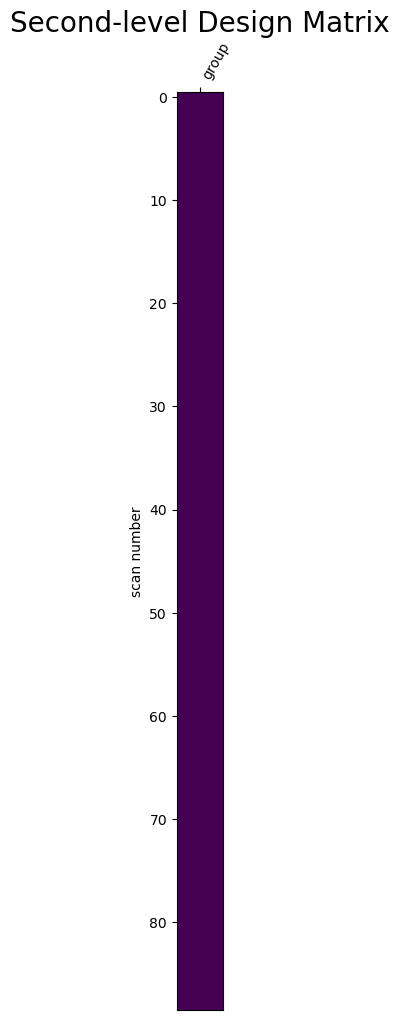

In [308]:
from nilearn.glm.second_level import SecondLevelModel 

plotting.plot_design_matrix(second_level_design_matrix, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

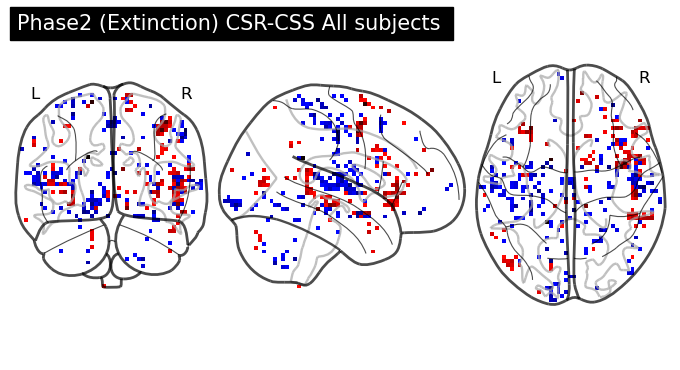

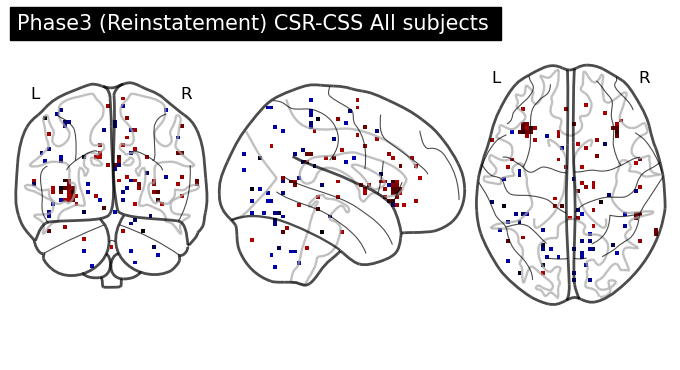

In [310]:
#CSR vs CSS, SAD - Healthy Controls 
import matplotlib.pyplot as plt
nosessions = ['phase2','phase3']
from scipy.stats import norm
p001_unc = norm.isf(0.001)
stat_img = []

ses = ['phase2']

second_level_input = file_lists_phase2["CSR-CSS"]
second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=second_level_design_matrix)
outputs = second_level_model.compute_contrast('group', output_type='all')

plotting.plot_glass_brain(
    outputs['z_score'],
    threshold=p001_unc,
    display_mode="ortho",
    title="Phase2 (Extinction) CSR-CSS All subjects ",
    plot_abs=False,
    )
plotting.show()
stat_img.append(zname)

second_level_input = file_lists_phase3["CSR-CSS"]
second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=second_level_design_matrix)
outputs = second_level_model.compute_contrast('group', output_type='all')

plotting.plot_glass_brain(
    outputs['z_score'],
    threshold=p001_unc,
    display_mode="ortho",
    title="Phase3 (Reinstatement) CSR-CSS All subjects ",
    plot_abs=False,
    )
plotting.show()
stat_img.append(zname)

In [ ]:
from nilearn.reporting import make_glm_report

report = make_glm_report(
    first_level_model,
    contrasts=contrasts,
    title="ADHD DMN Report",
    cluster_threshold=15,
    min_distance=8.0,
    plot_type="glass",
)

##### phase 2 cluster corrections / graphing 

In [ ]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference
contrast_val = [1]

second_level_input = file_lists_phase2["CSR-CSS"]

out_dict_selfvother_pre = non_parametric_inference(
    second_level_input,
    design_matrix=second_level_design_matrix,
    second_level_contrast=contrast_val,
    n_perm=10,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_pre['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_pre['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

t_img = out_dict_selfvother_pre['t']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(t_img, threshold=threshold, title='t-stat', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [ ]:
from nibabel import Nifti1Image
thresh_tfce_img = out_dict_selfvother_pre['logp_max_tfce'].get_fdata()
threshold_mask = (thresh_tfce_img > 0)

# Extracting t_img data
t_img = out_dict_selfvother_pre['t'].get_fdata()

# Applying the threshold mask to t_img
filtered_t_img = np.where(threshold_mask, t_img, 0)  # Use 0 for values that do not surpass the threshold

# # Creating a new NIfTI image with the filtered data
filtered_t_img_nifti = Nifti1Image(filtered_t_img, 
                                   out_dict_selfvother_pre['t'].affine, 
                                   header=out_dict_selfvother_pre['t'].header)
# # Plotting the logp_max_tfce map
plotting.plot_glass_brain(filtered_t_img_nifti, threshold=3, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)


In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(out_dict_selfvother_pre['t'], fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

texture_lh = surface.vol_to_surf(out_dict_selfvother_pre['t'], fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

##### phase 3 cluster corrections / graphing

In [ ]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference
contrast_val = [1]

second_level_input = file_lists_phase3["CSR-CSS"]

out_dict_selfvother_pre = non_parametric_inference(
    second_level_input,
    design_matrix=second_level_design_matrix,
    second_level_contrast=contrast_val,
    n_perm=10,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_pre['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_pre['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

t_img = out_dict_selfvother_pre['t']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(t_img, threshold=threshold, title='t-stat', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [ ]:
from nibabel import Nifti1Image
thresh_tfce_img = out_dict_selfvother_pre['logp_max_tfce'].get_fdata()
threshold_mask = (thresh_tfce_img > 0)

# Extracting t_img data
t_img = out_dict_selfvother_pre['t'].get_fdata()

# Applying the threshold mask to t_img
filtered_t_img = np.where(threshold_mask, t_img, 0)  # Use 0 for values that do not surpass the threshold

# # Creating a new NIfTI image with the filtered data
filtered_t_img_nifti = Nifti1Image(filtered_t_img, 
                                   out_dict_selfvother_pre['t'].affine, 
                                   header=out_dict_selfvother_pre['t'].header)
# # Plotting the logp_max_tfce map
plotting.plot_glass_brain(filtered_t_img_nifti, threshold=3, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)


In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(out_dict_selfvother_pre['t'], fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

texture_lh = surface.vol_to_surf(out_dict_selfvother_pre['t'], fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

#### patients vs controls 

In [301]:
# making second-level design matrix 

# patientvscontrols group variable 
group = []
for sub in subjects:
    subno = sub[1:]
    if int(subno) < 200:
        group_as = 1
    else:
        group_as = -1
    group.append(group_as)
#group = np.concatenate((np.array(group),np.array(group)))
group = np.expand_dims(group, axis = -1)

# # allsubs group variable 
# group = []
# group = np.ones(len(file_lists_phase2['CSR-CSS'])) 
# #group = np.concatenate((np.array(group),np.array(group)))
# group = np.expand_dims(group, axis = -1)

# put all together 
second_level_design_matrix = np.hstack((group))


In [302]:
second_level_design_matrix
second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['group'])
second_level_design_matrix

group
0       1
1       1
2       1
3       1
4       1
..    ...
84     -1
85     -1
86     -1
87     -1
88     -1

[89 rows x 1 columns]

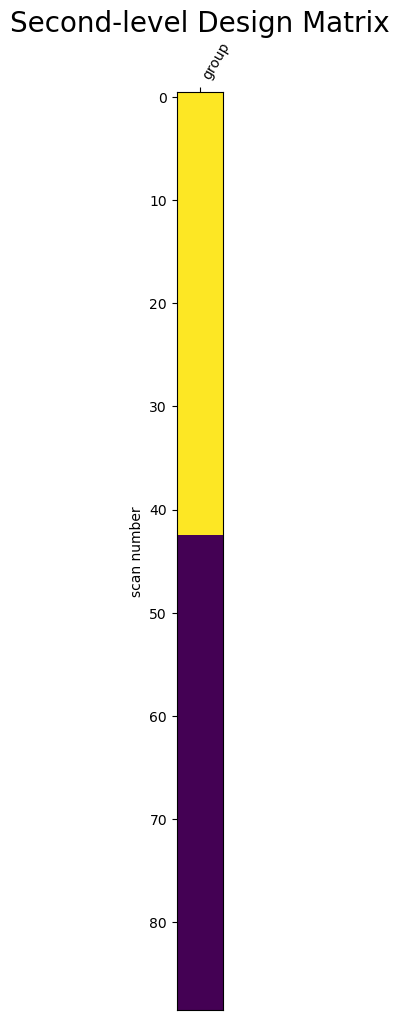

In [303]:
from nilearn.glm.second_level import SecondLevelModel 

plotting.plot_design_matrix(second_level_design_matrix, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

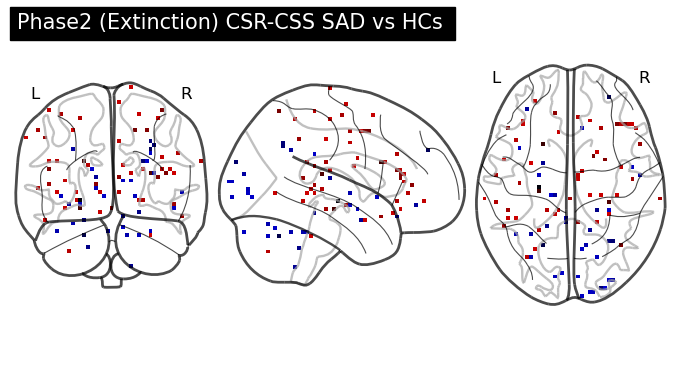

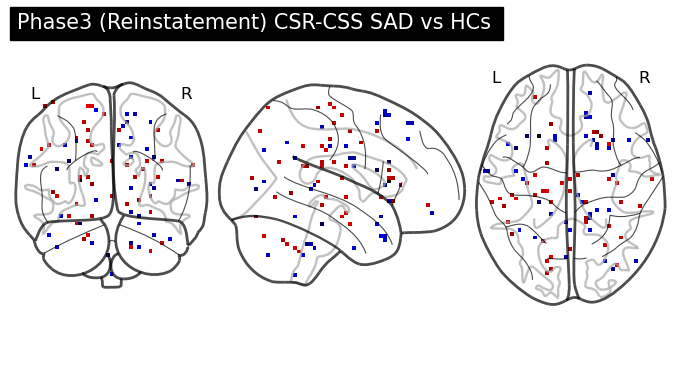

In [304]:
#CSR vs CSS, SAD - Healthy Controls 
import matplotlib.pyplot as plt
nosessions = ['phase2','phase3']
from scipy.stats import norm
p001_unc = norm.isf(0.001)
stat_img = []

ses = ['phase2']

second_level_input = file_lists_phase2["CSR-CSS"]
second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=second_level_design_matrix)
outputs = second_level_model.compute_contrast('group', output_type='all')

plotting.plot_glass_brain(
    outputs['z_score'],
    threshold=p001_unc,
    display_mode="ortho",
    title="Phase2 (Extinction) CSR-CSS SAD vs HCs ",
    plot_abs=False,
    )
plotting.show()
stat_img.append(zname)

second_level_input = file_lists_phase3["CSR-CSS"]
second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=second_level_design_matrix)
outputs = second_level_model.compute_contrast('group', output_type='all')

plotting.plot_glass_brain(
    outputs['z_score'],
    threshold=p001_unc,
    display_mode="ortho",
    title="Phase3 (Reinstatement) CSR-CSS SAD vs HCs ",
    plot_abs=False,
    )
plotting.show()
stat_img.append(zname)

In [282]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference
contrast_val = [1]

second_level_input = file_lists_phase2["CSR-CSS"]

out_dict_selfvother_pre = non_parametric_inference(
    second_level_input,
    design_matrix=second_level_design_matrix,
    second_level_contrast=contrast_val,
    n_perm=10,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


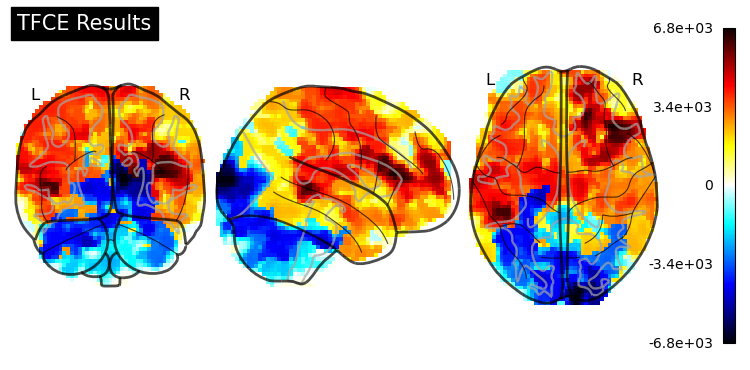

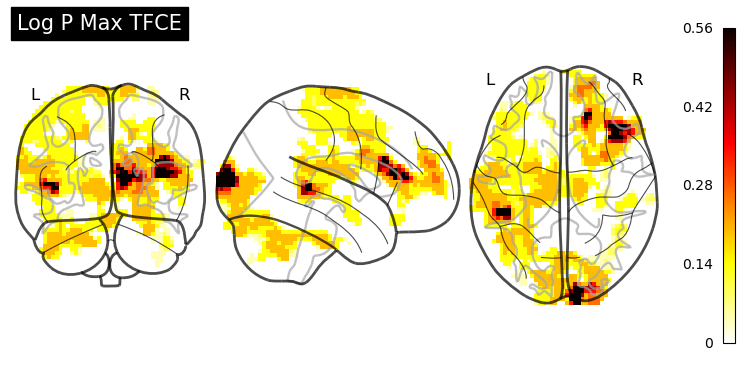

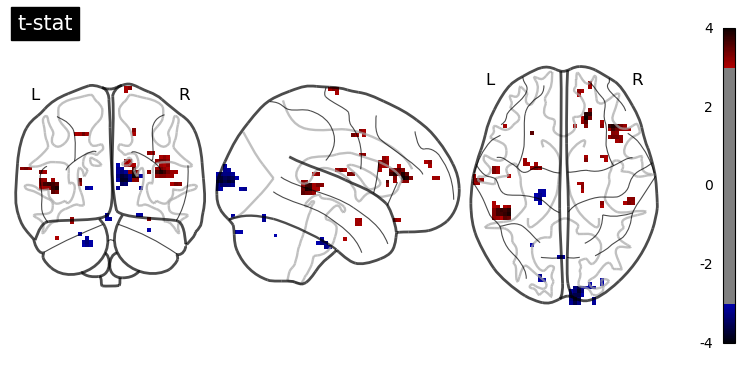

In [283]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_pre['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_pre['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

t_img = out_dict_selfvother_pre['t']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(t_img, threshold=threshold, title='t-stat', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

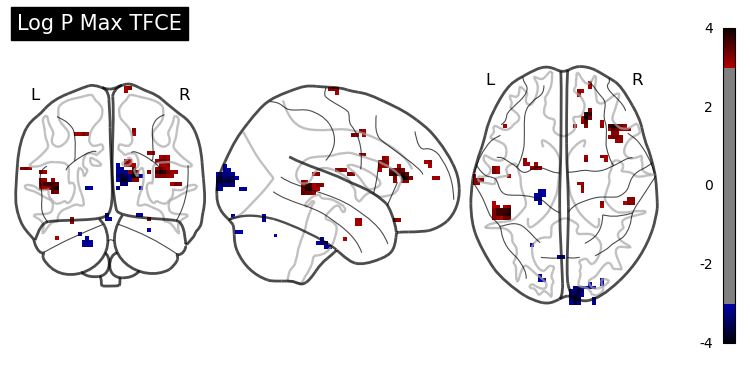

In [286]:
from nibabel import Nifti1Image
thresh_tfce_img = out_dict_selfvother_pre['logp_max_tfce'].get_fdata()
threshold_mask = (thresh_tfce_img > 0)

# Extracting t_img data
t_img = out_dict_selfvother_pre['t'].get_fdata()

# Applying the threshold mask to t_img
filtered_t_img = np.where(threshold_mask, t_img, 0)  # Use 0 for values that do not surpass the threshold

# # Creating a new NIfTI image with the filtered data
filtered_t_img_nifti = Nifti1Image(filtered_t_img, 
                                   out_dict_selfvother_pre['t'].affine, 
                                   header=out_dict_selfvother_pre['t'].header)
# # Plotting the logp_max_tfce map
plotting.plot_glass_brain(filtered_t_img_nifti, threshold=3, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)


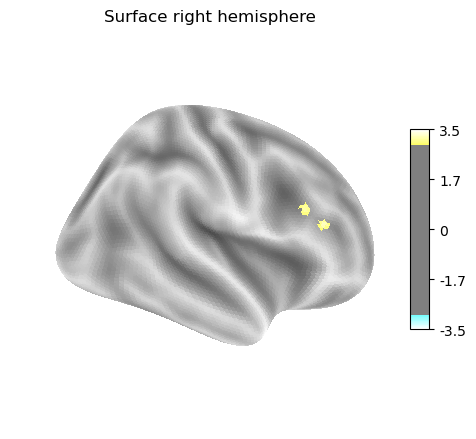

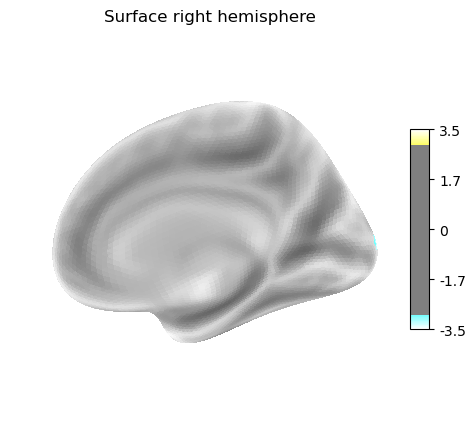

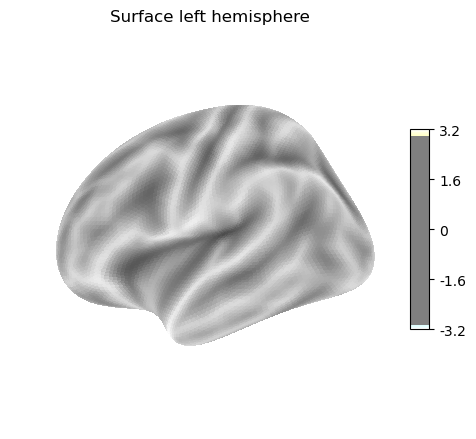

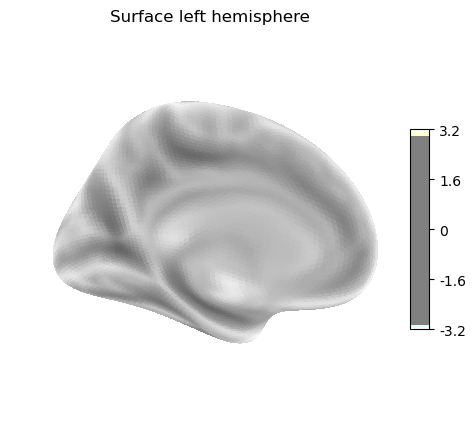

In [287]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(out_dict_selfvother_pre['t'], fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

texture_lh = surface.vol_to_surf(out_dict_selfvother_pre['t'], fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

# ROI based analysis: 

### Creating individual ROI masks: 
For each ROI, I used the functional association map from Neurosynth (links below) and then further anatomically constrained using the Harvard-Oxford maximum probabilistic map threshold25% 2mm

Neurosynth links: 
amygdala: https://www.neurosynth.org/analyses/terms/amygdala/
vmpfc: https://www.neurosynth.org/analyses/terms/vmpfc/
insula: https://www.neurosynth.org/analyses/terms/insula
ACC: https://www.neurosynth.org/analyses/terms/acc/
hippocampus: https://www.neurosynth.org/analyses/terms/hippocampus/
superior temporal sulcus: https://www.neurosynth.org/analyses/terms/sts/
temporoparietal junction: https://www.neurosynth.org/analyses/terms/tpj/

if: 
vmpfc anatomical constrained: 
Frontal Medial Cortex or Subcallosal Cortex -- cite: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7010285/

or:
The vmPFC was defined as a 10 mm spherical ROI centered on the MNI coordinates xyz = 4, 32, −5 on the basis of prior researches (Phelps et al., 2004; Milad et al., 2007) -- cite: https://academic.oup.com/scan/article/11/6/991/2224359#126899120

or: 
vmPFC defined as 5mm sphere around MNI coordinates derived from this meta-analysis: https://pubmed.ncbi.nlm.nih.gov/26122585/
(like how this paper did it: https://www.nature.com/articles/s41386-021-01003-8#Sec2)



BIDS Layout: ...sktop Drive/NARSAD/derivatives | Subjects: 101 | Sessions: 101 | Runs: 10


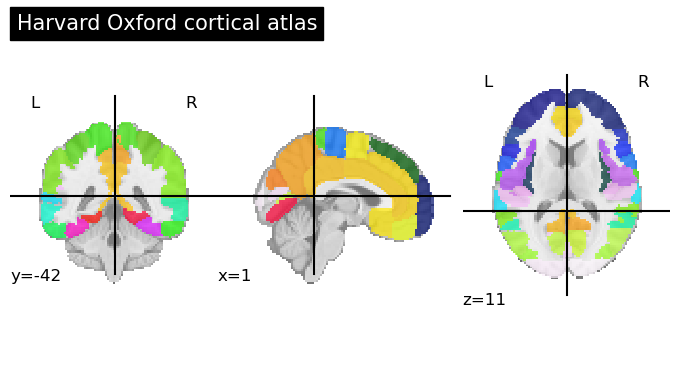

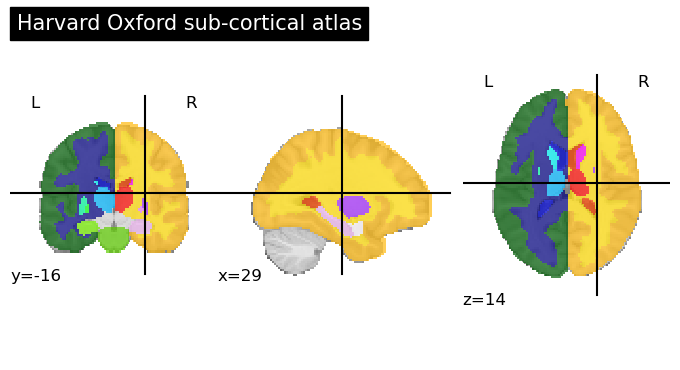

In [6]:
import numpy as np
from nilearn import datasets
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

dataset_ho_cort = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm", symmetric_split=True)
atlas_ho_cort_filename = dataset_ho_cort.filename
plotting.plot_roi(atlas_ho_cort_filename, title="Harvard Oxford cortical atlas")

dataset_ho_sub = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm")
atlas_ho_sub_filename = dataset_ho_sub.filename
plotting.plot_roi(atlas_ho_sub_filename, title="Harvard Oxford sub-cortical atlas")

layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/NARSAD/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

In [74]:
dataset_ho_cort

{'filename': '/Users/angelafang/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cortl-maxprob-thr25-2mm.nii.gz',
 'maps': <nibabel.nifti1.Nifti1Image at 0x7fee8128a4f0>,
 'labels': ['Background',
  'Left Frontal Pole',
  'Right Frontal Pole',
  'Left Insular Cortex',
  'Right Insular Cortex',
  'Left Superior Frontal Gyrus',
  'Right Superior Frontal Gyrus',
  'Left Middle Frontal Gyrus',
  'Right Middle Frontal Gyrus',
  'Left Inferior Frontal Gyrus, pars triangularis',
  'Right Inferior Frontal Gyrus, pars triangularis',
  'Left Inferior Frontal Gyrus, pars opercularis',
  'Right Inferior Frontal Gyrus, pars opercularis',
  'Left Precentral Gyrus',
  'Right Precentral Gyrus',
  'Left Temporal Pole',
  'Right Temporal Pole',
  'Left Superior Temporal Gyrus, anterior division',
  'Right Superior Temporal Gyrus, anterior division',
  'Left Superior Temporal Gyrus, posterior division',
  'Right Superior Temporal Gyrus, posterior division',
  'Left Middle Temporal Gyrus, anterio

In [9]:
space_defining_image.shape

(53, 65, 56)

In [8]:
#making space defining image
sub = 'N234'
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

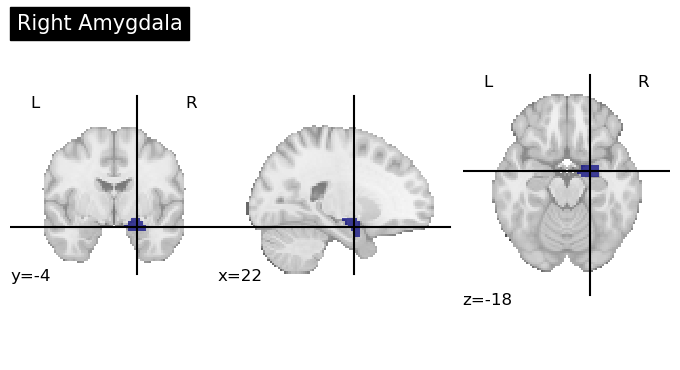

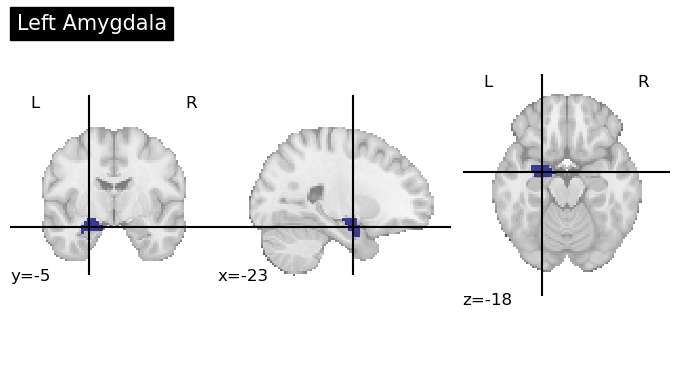

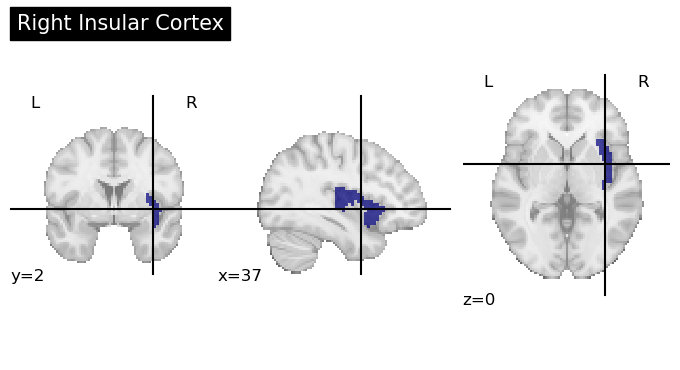

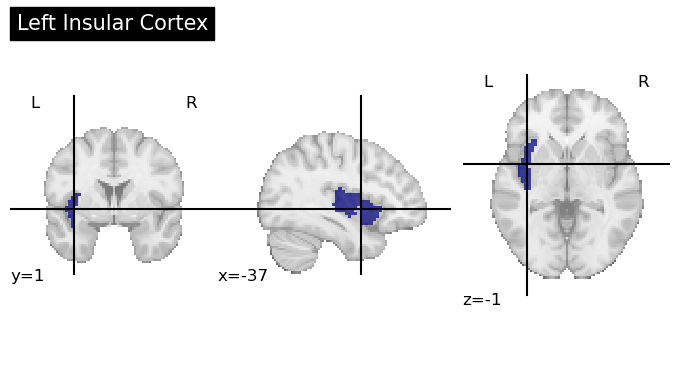

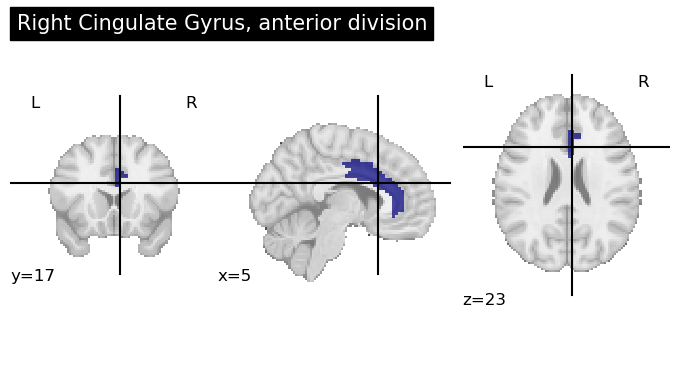

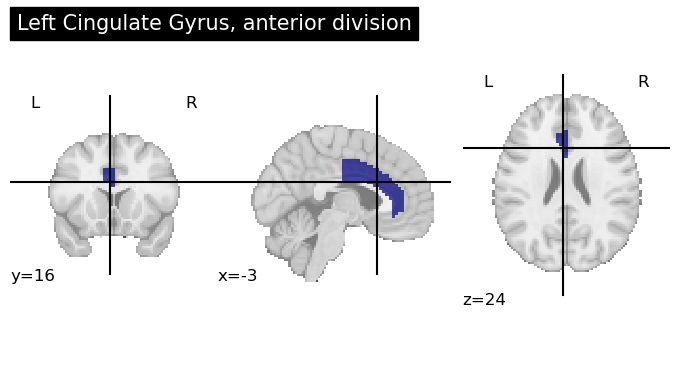

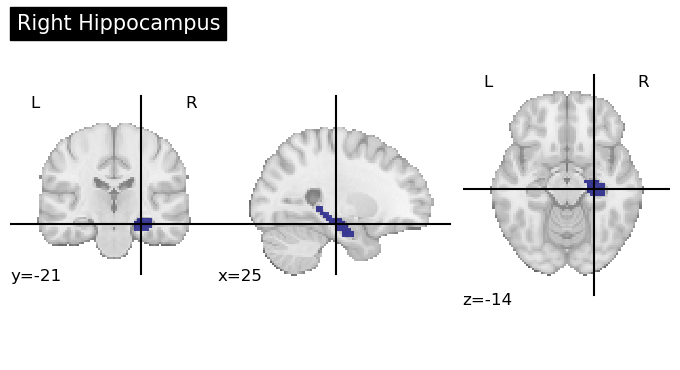

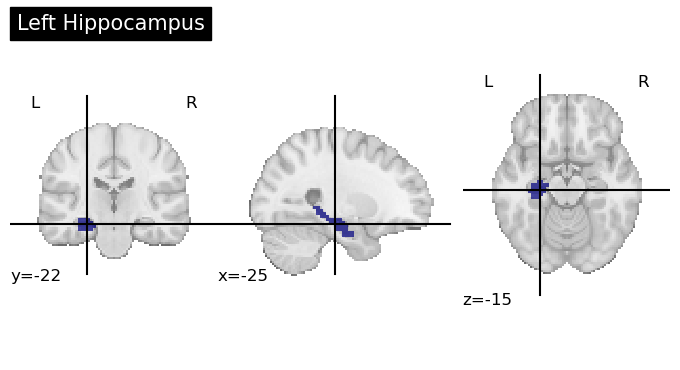

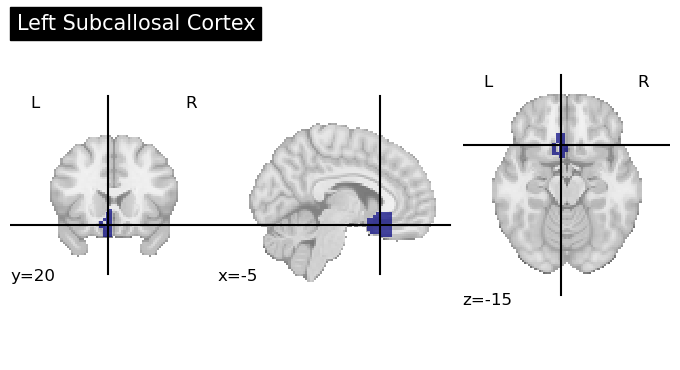

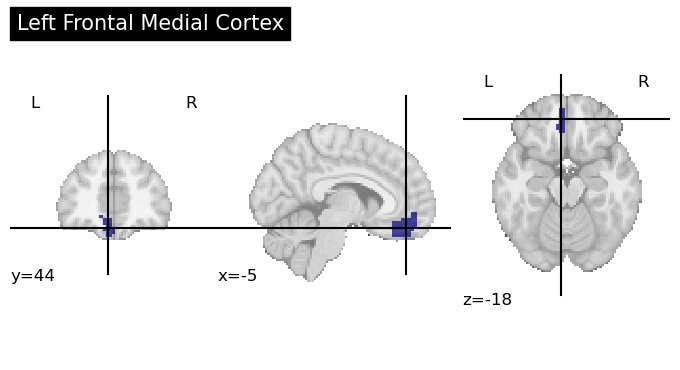

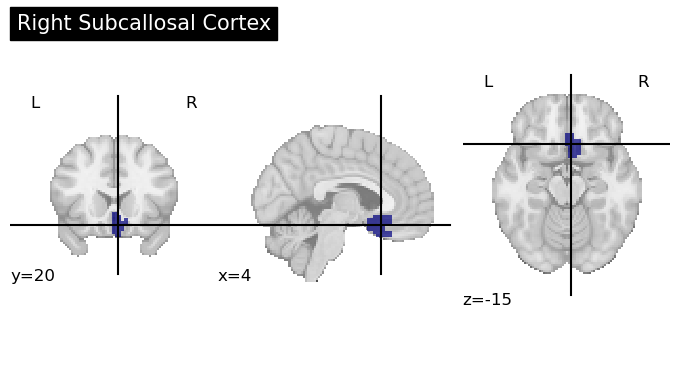

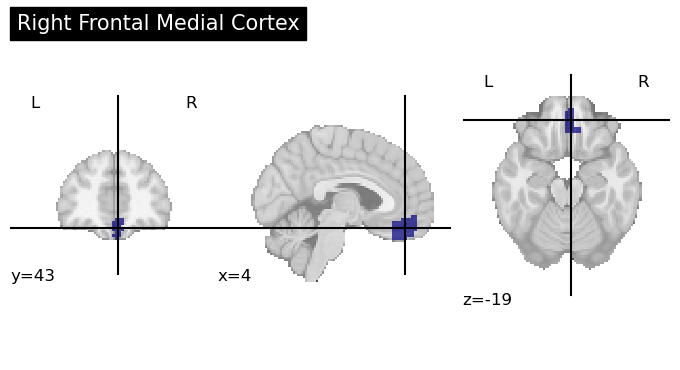

In [86]:
def create_and_plot_roi(label_of_interest, dataset, atlas_resampled):
    index_of_interest = dataset['labels'].index(label_of_interest)
    nii_data = atlas_resampled.get_fdata()
    roi_data = np.where(nii_data == index_of_interest, nii_data, 0)
    binarized_data = (roi_data > 0).astype(bool)
    
    roi_atlas = Nifti1Image(binarized_data, atlas_resampled.affine, header=atlas_resampled.header)
    plotting.plot_roi(roi_atlas, title=label_of_interest)
    
    return roi_atlas

#resample atlas map to data shape
atlas_sub_resampled = resample_to_img(source_img=dataset_ho_sub['maps'], target_img=space_defining_image, interpolation='nearest')
atlas_cort_resampled = resample_to_img(source_img=dataset_ho_cort['maps'], target_img=space_defining_image, interpolation='nearest')

right_amygdala_atlas = create_and_plot_roi('Right Amygdala', dataset_ho_sub, atlas_sub_resampled)
left_amygdala_atlas = create_and_plot_roi('Left Amygdala', dataset_ho_sub, atlas_sub_resampled)
right_insula_atlas = create_and_plot_roi('Right Insular Cortex', dataset_ho_cort, atlas_cort_resampled)
left_insula_atlas = create_and_plot_roi('Left Insular Cortex', dataset_ho_cort, atlas_cort_resampled)
right_acc_atlas = create_and_plot_roi('Right Cingulate Gyrus, anterior division', dataset_ho_cort, atlas_cort_resampled)
left_acc_atlas = create_and_plot_roi('Left Cingulate Gyrus, anterior division', dataset_ho_cort, atlas_cort_resampled)
right_hippocampus_atlas = create_and_plot_roi('Right Hippocampus', dataset_ho_sub, atlas_sub_resampled)
left_hippocampus_atlas = create_and_plot_roi('Left Hippocampus', dataset_ho_sub, atlas_sub_resampled)
left_vmpfc1_atlas = create_and_plot_roi('Left Subcallosal Cortex', dataset_ho_cort, atlas_cort_resampled)
left_vmpfc2_atlas = create_and_plot_roi('Left Frontal Medial Cortex', dataset_ho_cort, atlas_cort_resampled)
right_vmpfc1_atlas = create_and_plot_roi('Right Subcallosal Cortex', dataset_ho_cort, atlas_cort_resampled)
right_vmpfc2_atlas = create_and_plot_roi('Right Frontal Medial Cortex', dataset_ho_cort, atlas_cort_resampled)

In [73]:
# vmpfc masker: 

coords = [(4.00, 32.00, -5.00)]
labels = [
    "vmPFC"
]

from nilearn.maskers import NiftiSpheresMasker

vmpfc_masker = NiftiSpheresMasker(
    coords,
    radius=10,
    mask_img=space_defining_image
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/image/image.py:1066: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/image/image.py:1066: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/image/image.py:1066: UserWarning: D

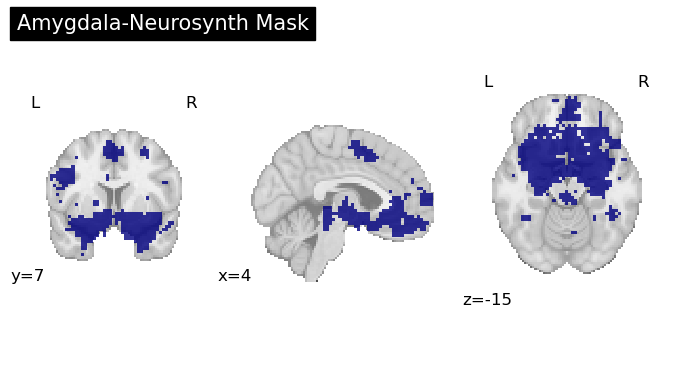

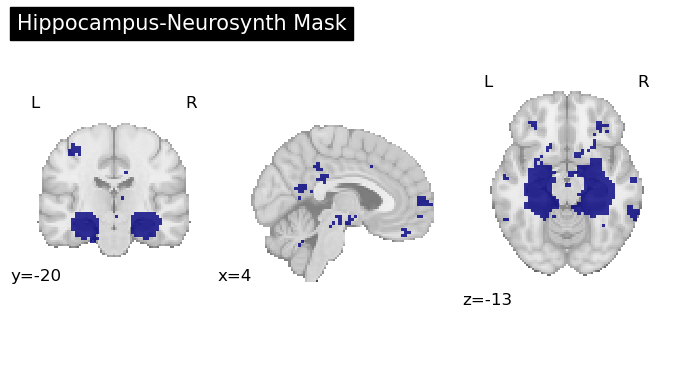

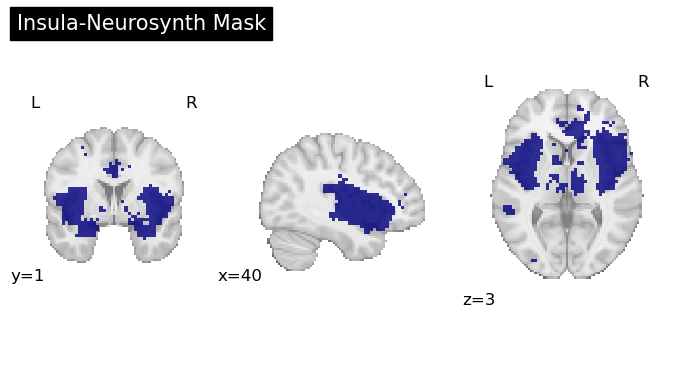

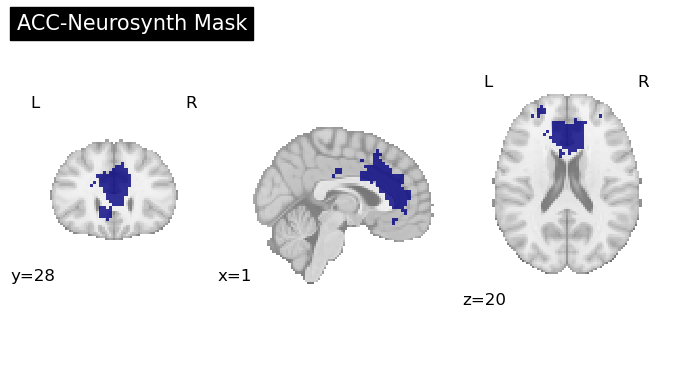

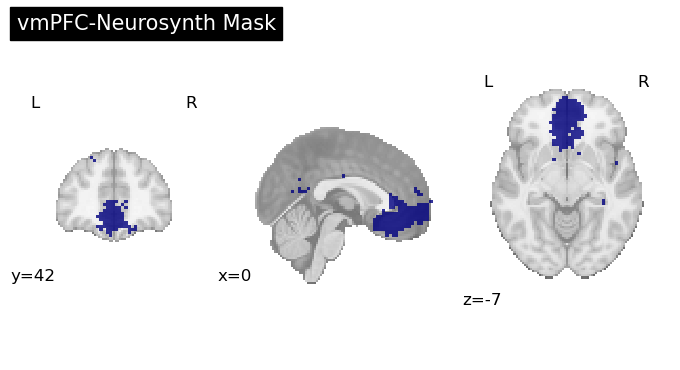

In [20]:
# load in/plot neurosynth masks: 
# #import Neurosynth masks:
from nilearn.image import binarize_img

amygdala_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/amygdala.nii.gz')
amygdala_func = binarize_img(resample_to_img(source_img=amygdala_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(amygdala_func, draw_cross=False, alpha=0.8, title='Amygdala-Neurosynth Mask')

hippocampus_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/hippocampus.nii.gz')
hippocampus_func = binarize_img(resample_to_img(source_img=hippocampus_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(hippocampus_func, draw_cross=False, alpha=0.8, title='Hippocampus-Neurosynth Mask')

insula_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/insula.nii.gz')
insula_func = binarize_img(resample_to_img(source_img=insula_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(insula_func, draw_cross=False, alpha=0.8, title='Insula-Neurosynth Mask')

acc_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/acc.nii.gz')
acc_func = binarize_img(resample_to_img(source_img=acc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(acc_func, draw_cross=False, alpha=0.8, title='ACC-Neurosynth Mask')

vmpfc_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/vmpfc.nii.gz')
vmpfc_func = binarize_img(resample_to_img(source_img=vmpfc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(vmpfc_func, draw_cross=False, alpha=0.8, title='vmPFC-Neurosynth Mask')


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_40595/4220354848.py:8: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  right_amygdala = new_img_like(space_defining_image, right_amygdala)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_40595/4220354848.py:14: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  left_amygdala = new_img_like(space_defining_image, left_amygdala)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_40595/4220354848.py:20: UserWarning: Data array used to crea

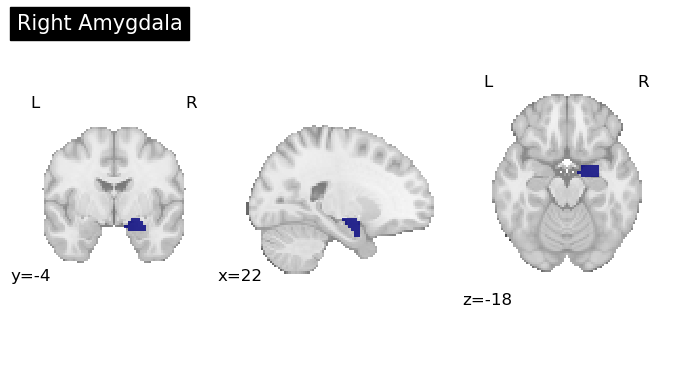

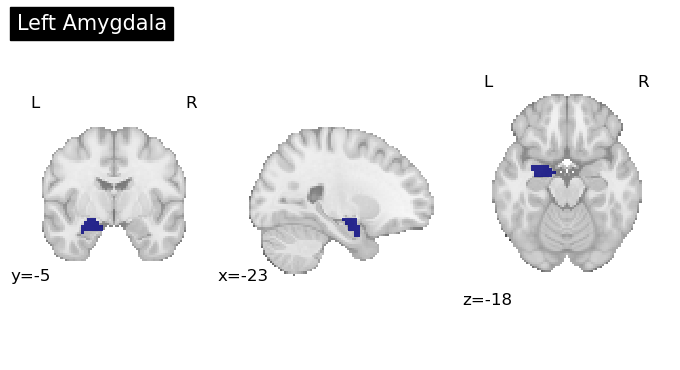

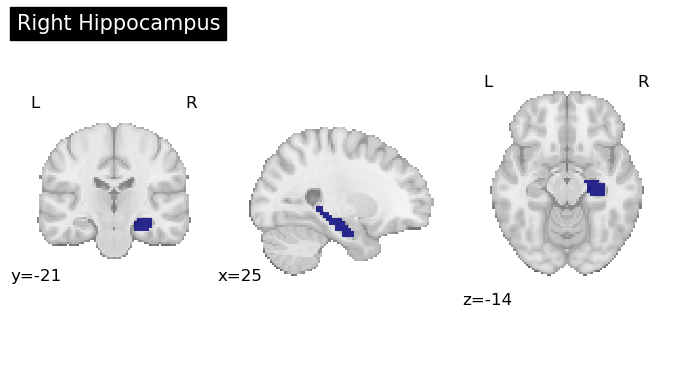

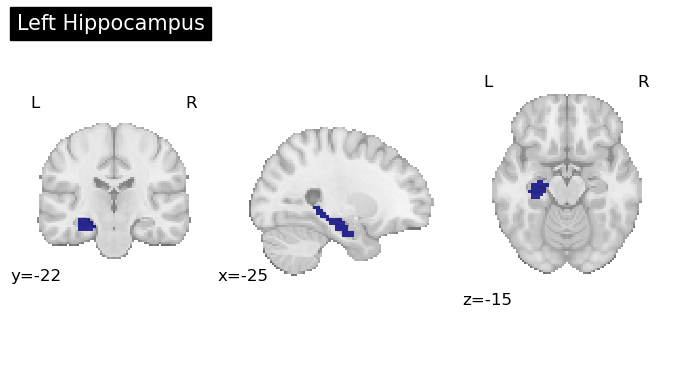

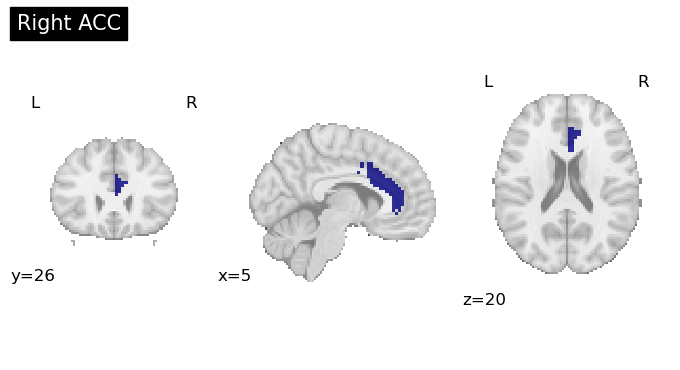

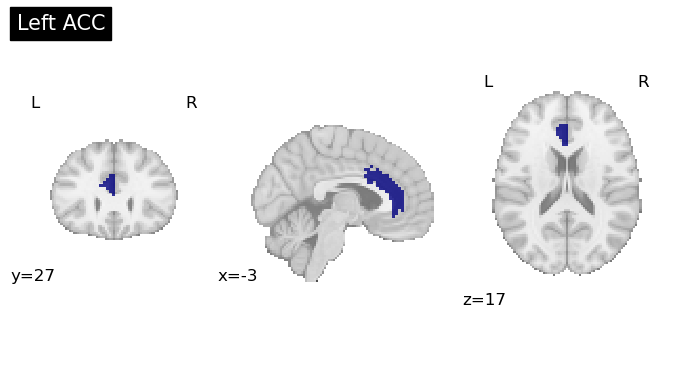

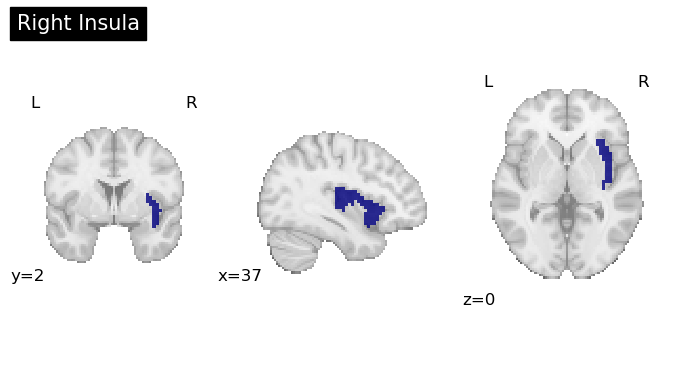

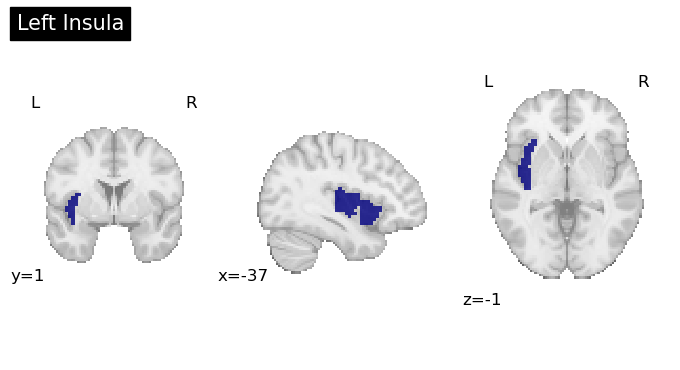

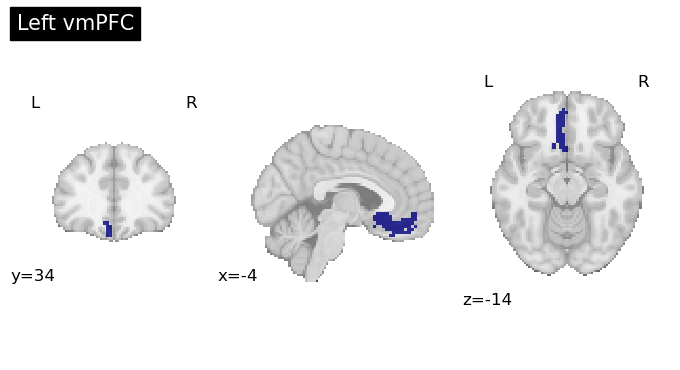

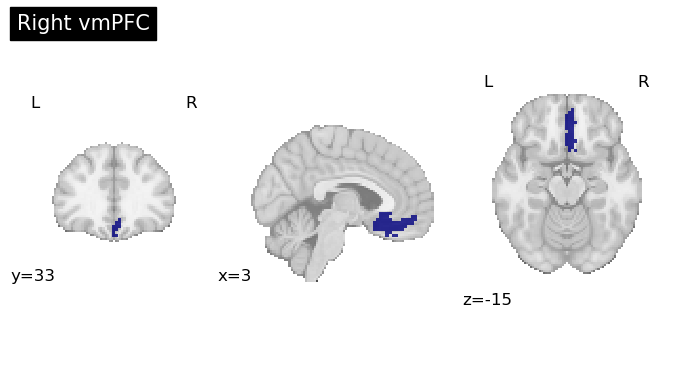

In [90]:
path = '/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/anatomically-constrained'
os.chdir(path)

# anatomically-constraining functional ROIs + lateralizing 
from nilearn.image import new_img_like
right_amygdala = np.logical_and(amygdala_func.get_fdata(),right_amygdala_atlas.get_fdata())
right_amygdala = right_amygdala.astype(int)
right_amygdala = new_img_like(space_defining_image, right_amygdala)
plotting.plot_roi(right_amygdala, draw_cross=False, alpha=0.8, title="Right Amygdala")
nib.save(right_amygdala, 'right_amygdala.nii')

left_amygdala = np.logical_and(amygdala_func.get_fdata(),left_amygdala_atlas.get_fdata())
left_amygdala = left_amygdala.astype(int)
left_amygdala = new_img_like(space_defining_image, left_amygdala)
plotting.plot_roi(left_amygdala, draw_cross=False, alpha=0.8, title="Left Amygdala")
nib.save(left_amygdala, 'left_amygdala.nii')

right_hippocampus = np.logical_and(hippocampus_func.get_fdata(),right_hippocampus_atlas.get_fdata())
right_hippocampus = right_hippocampus.astype(int)
right_hippocampus = new_img_like(space_defining_image, right_hippocampus)
plotting.plot_roi(right_hippocampus, draw_cross=False, alpha=0.8, title="Right Hippocampus")
nib.save(right_hippocampus, 'right_hippocampus.nii')

left_hippocampus = np.logical_and(hippocampus_func.get_fdata(),left_hippocampus_atlas.get_fdata())
left_hippocampus = left_hippocampus.astype(int)
left_hippocampus = new_img_like(space_defining_image, left_hippocampus)
plotting.plot_roi(left_hippocampus, draw_cross=False, alpha=0.8, title="Left Hippocampus")
nib.save(left_hippocampus, 'left_hippocampus.nii')

right_acc = np.logical_and(acc_func.get_fdata(),right_acc_atlas.get_fdata())
right_acc = right_acc.astype(int)
right_acc = new_img_like(space_defining_image, right_acc)
plotting.plot_roi(right_acc, draw_cross=False, alpha=0.8, title="Right ACC")
nib.save(right_acc, 'right_acc.nii')

left_acc = np.logical_and(acc_func.get_fdata(),left_acc_atlas.get_fdata())
left_acc = left_acc.astype(int)
left_acc = new_img_like(space_defining_image, left_acc)
plotting.plot_roi(left_acc, draw_cross=False, alpha=0.8, title="Left ACC")
nib.save(left_acc, 'left_acc.nii')

right_insula = np.logical_and(insula_func.get_fdata(),right_insula_atlas.get_fdata())
right_insula = right_insula.astype(int)
right_insula = new_img_like(space_defining_image, right_insula)
plotting.plot_roi(right_insula, draw_cross=False, alpha=0.8, title="Right Insula")
nib.save(right_insula, 'right_insula.nii')

left_insula = np.logical_and(insula_func.get_fdata(),left_insula_atlas.get_fdata())
left_insula = left_insula.astype(int)
left_insula = new_img_like(space_defining_image, left_insula)
plotting.plot_roi(left_insula, draw_cross=False, alpha=0.8, title="Left Insula")
nib.save(left_insula, 'left_insula.nii')

left_vmpfc1 = np.logical_and(vmpfc_func.get_fdata(),left_vmpfc1_atlas.get_fdata())
left_vmpfc1 = left_vmpfc1.astype(int)
left_vmpfc2 = np.logical_and(vmpfc_func.get_fdata(),left_vmpfc2_atlas.get_fdata())
left_vmpfc2 = left_vmpfc2.astype(int)
left_vmpfc = np.maximum.reduce([left_vmpfc1, left_vmpfc2])
left_vmpfc = new_img_like(space_defining_image, left_vmpfc)
plotting.plot_roi(left_vmpfc, draw_cross=False, alpha=0.8, title="Left vmPFC")
nib.save(left_vmpfc, 'left_vmpfc.nii')

right_vmpfc1 = np.logical_and(vmpfc_func.get_fdata(),right_vmpfc1_atlas.get_fdata())
right_vmpfc1 = right_vmpfc1.astype(int)
right_vmpfc2 = np.logical_and(vmpfc_func.get_fdata(),right_vmpfc2_atlas.get_fdata())
right_vmpfc2 = right_vmpfc2.astype(int)
right_vmpfc = np.maximum.reduce([right_vmpfc1, right_vmpfc2])
right_vmpfc = new_img_like(space_defining_image, right_vmpfc)
plotting.plot_roi(right_vmpfc, draw_cross=False, alpha=0.8, title="Right vmPFC")
nib.save(right_vmpfc, 'right_vmpfc.nii')

### Making combined mask of all regions of interest 

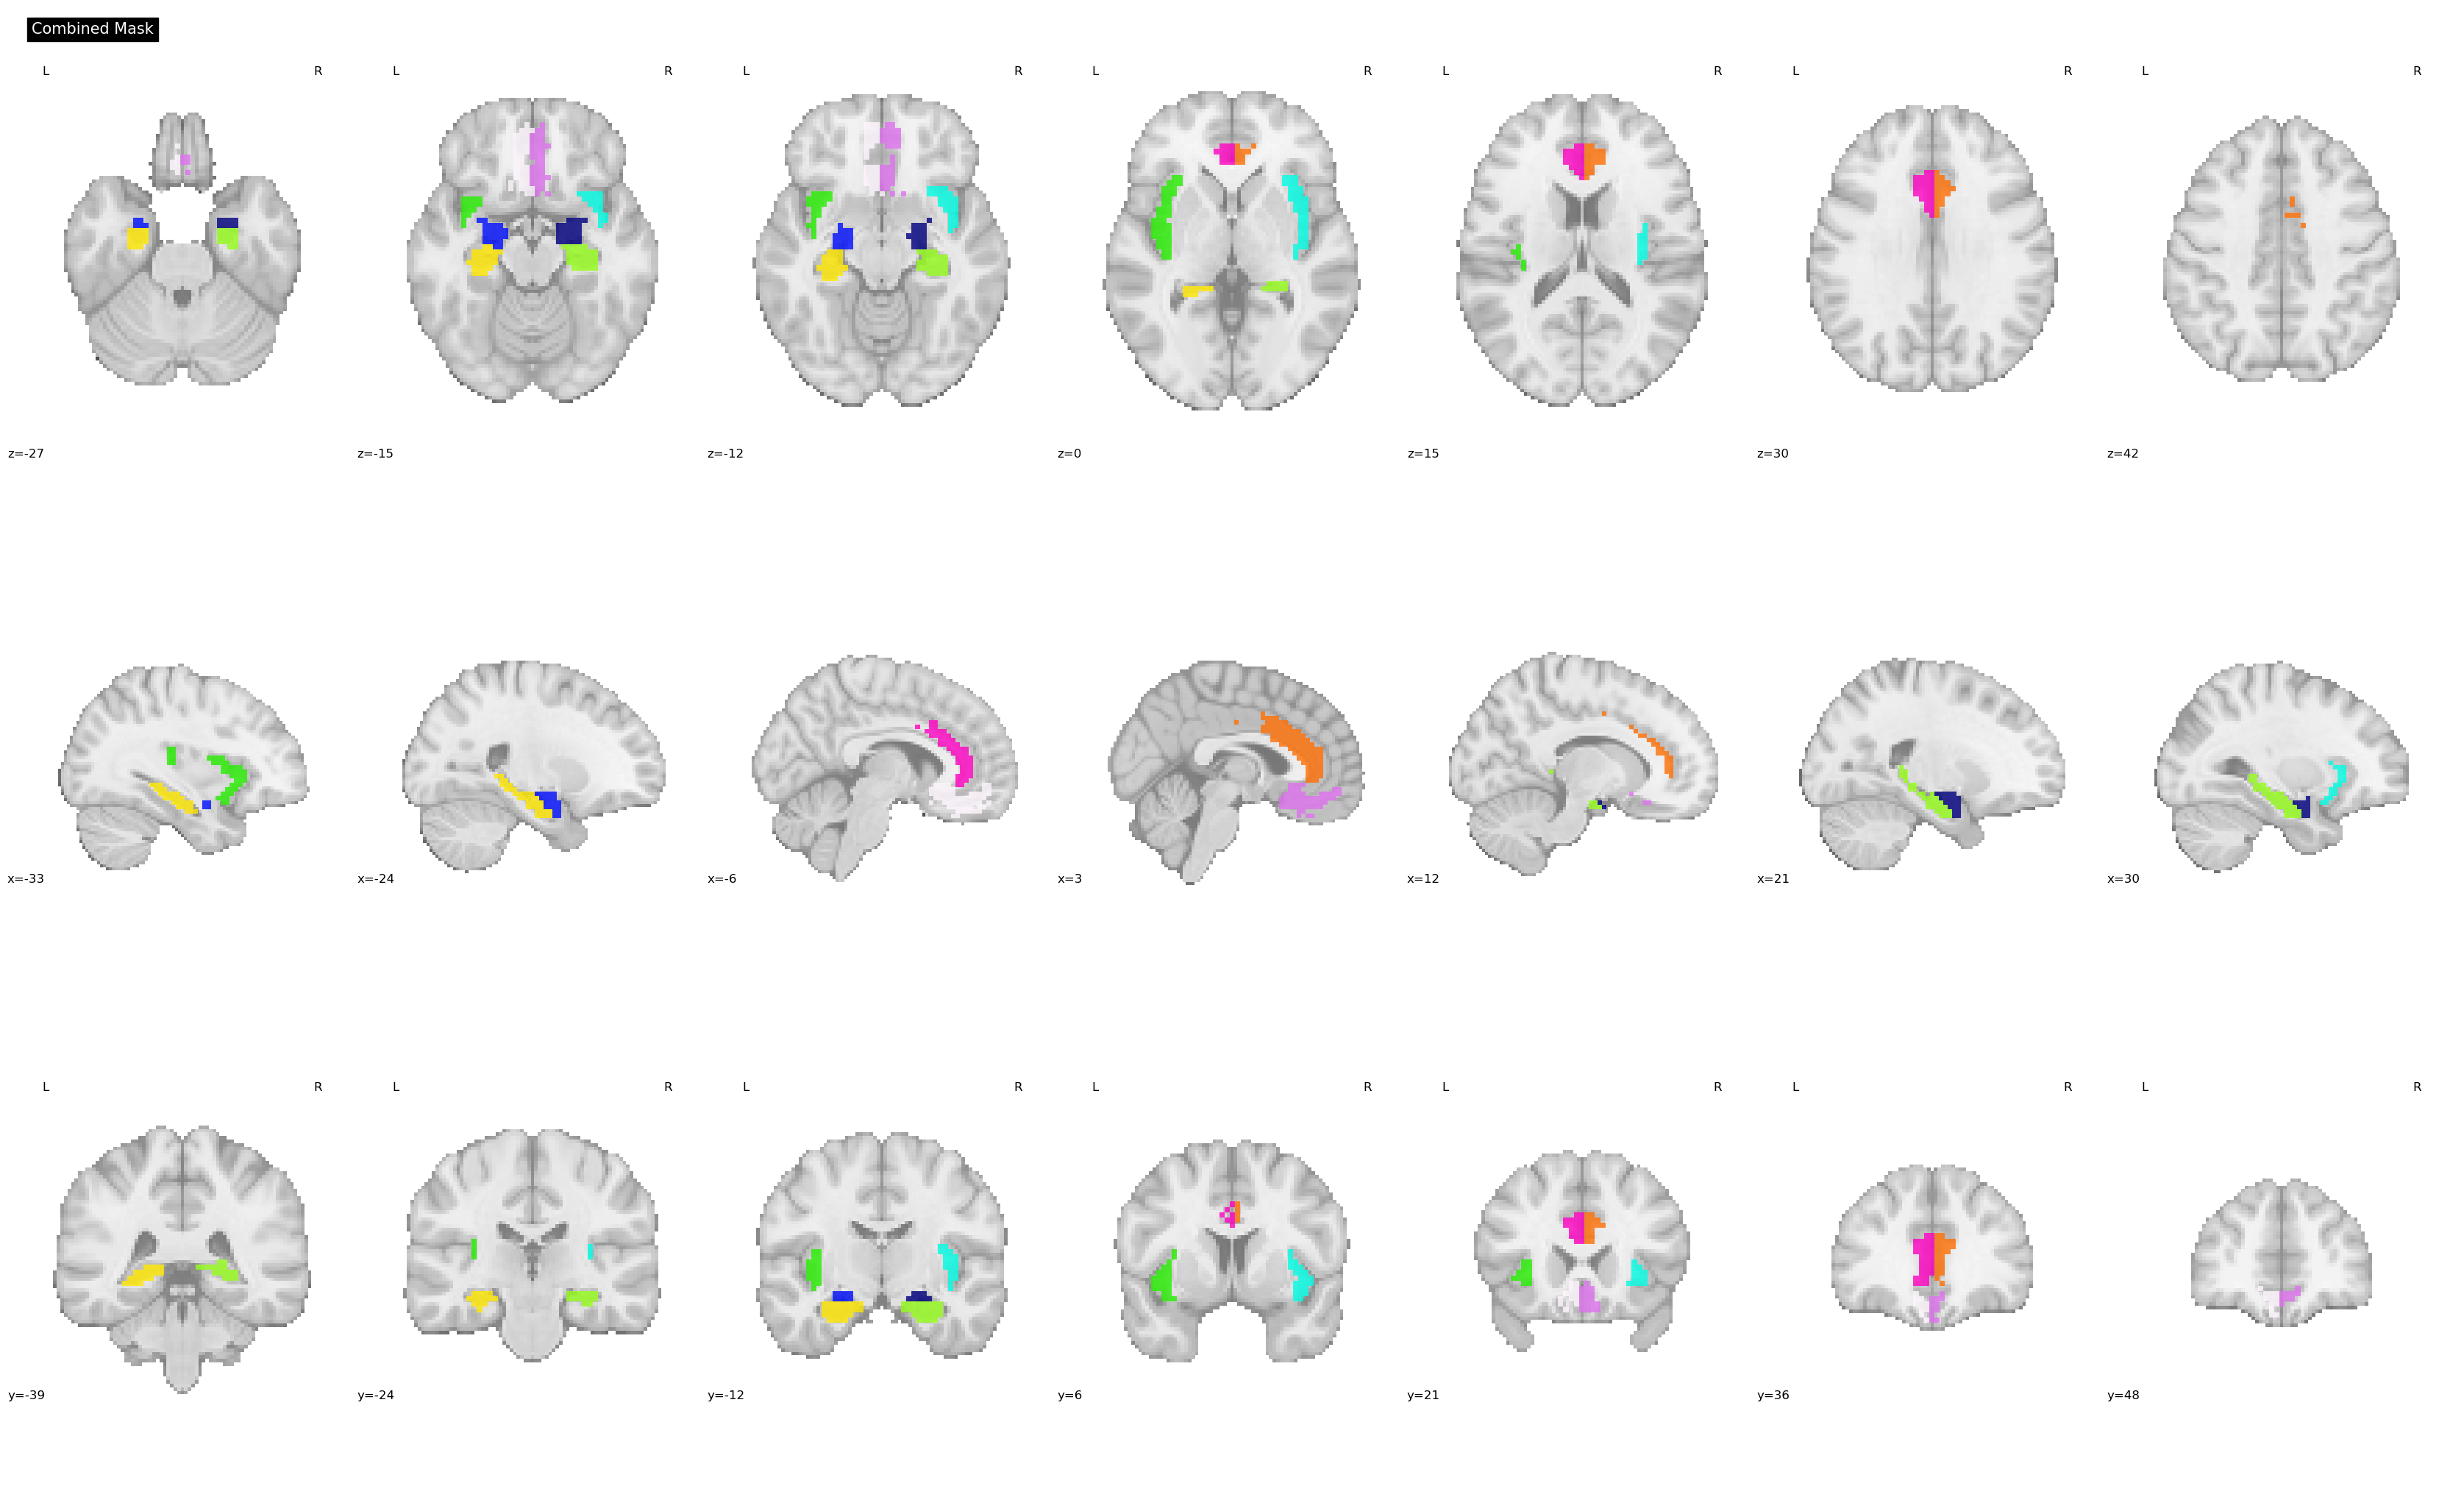

In [99]:
# run to load in previously-derived masks + create combined masker object (for ease of first-level computation)
from nilearn.maskers import NiftiLabelsMasker
path = '/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/anatomically-constrained'
os.chdir(path)

right_amygdala = nib.load('right_amygdala.nii')
left_amygdala = nib.load('left_amygdala.nii')
right_insula = nib.load('right_insula.nii')
left_insula = nib.load('left_insula.nii')
right_hippocampus = nib.load('right_hippocampus.nii')
left_hippocampus = nib.load('left_hippocampus.nii')
right_acc = nib.load('right_acc.nii')
left_acc = nib.load('left_acc.nii')
right_vmpfc = nib.load('right_vmpfc.nii')
left_vmpfc = nib.load('left_vmpfc.nii')

right_amygdala_data = right_amygdala.get_fdata() * 1
left_amygdala_data = left_amygdala.get_fdata() * 2
right_insula_data = right_insula.get_fdata() * 3
left_insula_data = left_insula.get_fdata() * 4
right_hippocampus_data = right_hippocampus.get_fdata() * 5
left_hippocampus_data = left_hippocampus.get_fdata() * 6
right_acc_data = right_acc.get_fdata() * 7
left_acc_data = left_acc.get_fdata() * 8
right_vmpfc_data = right_vmpfc.get_fdata() * 9
left_vmpfc_data = left_vmpfc.get_fdata() * 10

# Combine the masks by taking the maximum value at each voxel
combined_mask_data = np.maximum.reduce([
    right_amygdala_data,
    left_amygdala_data,
    right_insula_data,
    left_insula_data,
    right_hippocampus_data,
    left_hippocampus_data,
    right_acc_data,
    left_acc_data,
    right_vmpfc_data,
    left_vmpfc_data
])

combined_mask_img = Nifti1Image(combined_mask_data, affine=right_amygdala.affine)
plotting.plot_roi(combined_mask_img, display_mode='mosaic',draw_cross=False, alpha=0.8, title="Combined Mask")

# First, initialize masker 
masker = NiftiLabelsMasker(
    combined_mask_img, mask_img=space_defining_image
)

### First level


In [155]:
# removing subjects w wrong sequence / missing phases: 
# subjects = layout.get_subjects()
# subjects1 = subjects
# del(subjects1[0]) #sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
# del(subjects1[48]) # sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3 

# subjects = layout.get_subjects()
# subjects2 = subjects
# del(subjects2[15]) #sub 120 missing phase 3

# subjects = layout.get_subjects()

#####
#ALSO removing subjects w bad LSAS 
#N114 - LSAS: 42
#N118 - LSAS: 37
#N121 - LSAS: 49
#N238 - LSAS: 42 
#N251 - LSAS: 38 

subjects = layout.get_subjects()
subjects1 = subjects
del(subjects1[0]) #sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
del(subjects1[48]) # sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3 
del(subjects1[10]) #N114 - LSAS: 42
del(subjects1[12]) #N118 - LSAS: 37
del(subjects1[13]) #N121 - LSAS: 49
del(subjects1[76]) #N238 - LSAS: 42 
del(subjects1[86]) #N251 - LSAS: 38

subjects = layout.get_subjects()
subjects2 = subjects
del(subjects2[15]) #sub 120 missing phase 3
del(subjects2[11]) #N114 - LSAS: 42
del(subjects2[13]) #N118 - LSAS: 37
del(subjects2[13]) #N121 - LSAS: 49
del(subjects2[77]) #N238 - LSAS: 42 
del(subjects2[87]) #N251 - LSAS: 38
subjects = layout.get_subjects()

In [156]:
# can load in onsets (events.tsv) for all subs here as all subs have same task timings 
onsets_phase2 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=0)
onsets_phase3 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=1)
onsets_phase3_sub202 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=2)

onsets = onsets_phase2, onsets_phase3
onsets_sub202 = onsets_phase2, onsets_phase3_sub202

def load_bids_events(layout,onsets, subject, task, phaseno):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files)
    n_tr = func_file.shape[-1]
    onsets=onsets[phaseno]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as onsets 
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [168]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_phase2 = {"CSR-CSS": list(),
    "CSR-CS-": list(),
    "CSS-CS-": list(),
    "CSR-fix": list(),
    "CSS-fix": list(),
    "CSminus-fix": list()                 
    }

file_lists_phase3 = {"CSR-CSS": list(),
    "CSR-CS-": list(),
    "CSS-CS-": list(),
    "CSR-fix": list(),
    "CSS-fix": list(),
    "CSminus-fix": list()                 
    }

sub_order_phase2 = {"CSR-CSS": list(),
    "CSR-CS-": list(),
    "CSS-CS-": list(),
    "CSR-fix": list(),
    "CSS-fix": list(),
    "CSminus-fix": list()                 
    }

sub_order_phase3 = {"CSR-CSS": list(),
    "CSR-CS-": list(),
    "CSS-CS-": list(),
    "CSR-fix": list(),
    "CSS-fix": list(),
    "CSminus-fix": list()                 
    }

tasks = ['phase2','phase3']

for phaseno, task in enumerate(tasks): 

    if task == 'phase2':
        subject_list = subjects1 #CHANGE FROM NORMAL FIRST LEVEL -- ONLY TAKING SUBS WITH BOTH SES01 AND SES02 
    elif task == 'phase3':
        subject_list = subjects2        
    
    for sub in subject_list: 

# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
        fmri_imgs = layout.get(subject=sub,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)
        
        confound_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
        # Select confounds 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                        ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        if sub == 'N202':
            onsets_file = onsets_sub202 
        else:
            onsets_file = onsets
        
        for img in enumerate(fmri_imgs):
    # Build experimental paradigm
            events,tr,n_scans = load_bids_events(layout,onsets_file, sub, task, phaseno)
        # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[0]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)            
        # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )

        design_matrices.append(design_matrix)
        design_matrix_allruns = []    
        design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
            
        contrast_matrix = []
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }

        contrasts = {
            "CSR-CSS": (basic_contrasts["CSR"] - basic_contrasts["CSS"]),   
            "CSR-CS-": (basic_contrasts["CSR"] - basic_contrasts["CS-"]),   
            "CSS-CS-": (basic_contrasts["CSS"] - basic_contrasts["CS-"]), 
            "CSR-fix": (basic_contrasts["CSR"] - basic_contrasts["FIXATION"]),   
            "CSS-fix": (basic_contrasts["CSS"] - basic_contrasts["FIXATION"]),   
            "CSminus-fix": (basic_contrasts["CS-"] - basic_contrasts["FIXATION"]),            
        }

    #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        
        # compute contrast-related statistics
            contrast = compute_contrast(labels, estimates, contrast_val)
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}") 
            
            if phaseno == 0:
                file_lists_phase2[contrast_id].append(contrast)
                sub_order_phase2[contrast_id].append('sub'+ sub + '-ses' + task)            

            else:
                file_lists_phase3[contrast_id].append(contrast)
                sub_order_phase3[contrast_id].append('sub'+ sub + '-ses' + task)            

        print("Subject = " + sub + " Completed!")

    

Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.32556446  0.17468881 -0.57756897 -1.00471116 -0.87854588 -0.5887111
 -0.70278254 -1.2856307  -0.44729043 -1.25655595]
CSR-CS-: Z-score outputs: [ 1.75052362  0.77331842  0.56018911  0.43993496 -0.7480265   0.25127515
 -0.37658737 -0.72689996 -1.32652023 -1.30104877]
CSS-CS-: Z-score outputs: [ 1.33740044  0.55227376  1.14422403  1.46900837  0.20220496  0.85454311
  0.35975555  0.63456894 -0.8206904   0.00726893]
CSR-fix: Z-score outputs: [ 1.65090378  0.84085742 -0.13348722  0.08247668 -0.15339755 -0.49415936
 -1.24953512 -1.35680702 -1.50334271 -1.71854715]
CSS-fix: Z-score outputs: [ 1.18330207  0.58717435  0.60202208  1.33795375  0.93649993  0.25329985
 -0.32834176  0.29637474 -0.89855057 -0.06325375]
CSminus-fix: Z-score outputs: [-0.4826229  -0.07369576 -0.92044976 -0.50967906  0.84463944 -0.9151134
 -0.88270026 -0.55089974  0.1062247  -0.08038952]
Subject = N103 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.12844754 -0.92448207  2.2539423   1.42766874  0.61413904  0.3292113
  1.57501926  0.91847947 -0.83429483  1.40240787]
CSR-CS-: Z-score outputs: [-1.02695177 -0.97329598  0.04230761  0.40867745 -0.99145227 -0.56026084
  2.57776524  2.5130511  -1.47709267  0.9548183 ]
CSS-CS-: Z-score outputs: [-0.83519182  0.07255904 -2.35657126 -1.12359348 -1.59919841 -0.88578074
  0.83487239  1.48654972 -0.50630728 -0.59486902]
CSR-fix: Z-score outputs: [-0.2260848  -1.4210008   0.49091194  0.55613483  0.03207089 -0.81294086
  0.77127222  0.8808621  -1.47079497 -0.03667145]
CSS-fix: Z-score outputs: [-0.03878903 -0.09294282 -2.53469566 -1.37683986 -0.77952685 -1.18655099
 -1.3718243  -0.38887129 -0.26017579 -1.88372688]
CSminus-fix: Z-score outputs: [ 1.1781485  -0.21779682  0.47500557  0.03710555  1.40965648 -0.11776251
 -2.74010367 -2.54462036  0.42985787 -1.36241636]
Subject = N104 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.82796909 -0.08666242 -0.63868357 -0.88545483 -2.1956553  -0.80546637
 -2.11114873 -2.70014935 -2.29966527 -2.75145903]
CSR-CS-: Z-score outputs: [-0.94001883  0.30211093 -0.64929267 -0.12525635 -1.44557595 -1.29319025
  0.1346955  -0.52026692 -0.35055325 -0.32367887]
CSS-CS-: Z-score outputs: [-1.76254432  0.37643551  0.05434094  0.81864787  0.98933696 -0.36288068
  2.35441307  2.34546363  2.10151346  2.59747038]
CSR-fix: Z-score outputs: [ 1.17095724  0.94112203 -0.68709755 -0.4223427  -1.89526178 -0.64512717
 -1.74139949 -1.73052277 -2.20548574 -3.10487307]
CSS-fix: Z-score outputs: [0.01944913 1.00280687 0.19497233 0.7710075  1.09632906 0.45034196
 1.14940665 1.96519394 0.95571059 0.69761498]
CSminus-fix: Z-score outputs: [ 2.60356095  0.64268046  0.14518916 -0.29546652 -0.14488536  1.06642313
 -2.10783377 -1.17289212 -1.96037843 -2.97818417]
Subject = N105 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.06104476 -0.8338591   1.26008441  1.79930861 -1.49506084 -0.14831818
  1.51366131  2.09052209  0.60189076  0.84401418]
CSR-CS-: Z-score outputs: [ 0.85674053  0.08853898  2.03518497  2.23134406 -0.26228231  0.89796992
  1.12173456  1.62910568 -0.0046969   1.08666011]
CSS-CS-: Z-score outputs: [ 0.90545911  1.00184475  0.59710595  0.19921145  1.38938549  1.03875519
 -0.57857165 -0.71661433 -0.66482379  0.14654155]
CSR-fix: Z-score outputs: [ 0.74095567 -1.08757151  0.70612399  1.14670197 -1.41810377 -0.40643676
  0.66086868  0.55499507  0.14432416  0.94520362]
CSS-fix: Z-score outputs: [ 0.77362915  0.07492807 -0.98555597 -1.28135937  0.63069458 -0.18517015
 -1.35788701 -2.20746385 -0.65015221 -0.22094248]
CSminus-fix: Z-score outputs: [-0.37995788 -1.32840353 -2.02249262 -1.81162203 -1.21496444 -1.68698105
 -0.81172783 -1.6324505   0.16647135 -0.46724001]
Subject = N106 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.38257414  0.82226619 -0.3330448   0.45067297 -0.48062775  0.03933708
 -0.94276521 -1.00150573 -1.00485593 -1.05222334]
CSR-CS-: Z-score outputs: [ 0.52062157  1.60335994 -1.44855326 -0.75314611 -3.03235532 -1.79964578
  0.89784024  0.71387684 -0.97459618 -1.47898519]
CSS-CS-: Z-score outputs: [-0.99114498  0.66510786 -1.0800258  -1.22511477 -2.48199092 -1.81416541
  1.89318264  1.77614319  0.11128577 -0.34834452]
CSR-fix: Z-score outputs: [ 1.09224716  1.18295844 -0.42604331  0.52800146 -2.88933085 -1.62516496
 -0.67379563 -0.74596633 -1.13351919 -1.45731349]
CSS-fix: Z-score outputs: [-0.76765148  0.06490495  0.02775114 -0.08631494 -2.22594734 -1.66092078
  0.60453011  0.61149493  0.2342914  -0.02333583]
CSminus-fix: Z-score outputs: [ 0.52467837 -0.88902473  1.56297589  1.64190888  1.01632684  0.69843722
 -2.01541165 -1.84058196  0.10426567  0.46846535]
Subject = N108 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.43543971 -1.76018771 -0.9011859  -1.15264616 -0.83587392 -1.41058638
 -0.11241363 -0.04241998  1.34509216  0.67599913]
CSR-CS-: Z-score outputs: [-1.40920738 -2.31565084 -2.43889746 -1.69694512 -3.36311635 -2.70178271
 -2.25246222 -2.62680202 -1.38112186 -1.81623836]
CSS-CS-: Z-score outputs: [ 0.22263737 -0.26430094 -1.34582163 -0.40214547 -2.28123308 -1.05560444
 -2.04220883 -2.51248978 -2.69830687 -2.38521646]
CSR-fix: Z-score outputs: [-1.55555486 -2.74927155 -1.42905556 -0.39292615 -1.69570504 -1.10925645
  0.08790657  0.15899641  0.64194613 -0.04175768]
CSS-fix: Z-score outputs: [ 0.35327896 -0.34443026 -0.20243842  1.09172236 -0.53088076  0.73817859
  0.22710729  0.20932599 -1.07391446 -0.8659136 ]
CSminus-fix: Z-score outputs: [ 0.11754243 -0.04925347  1.69161045  1.86918417  2.64209054  2.4111521
  3.15795322  3.75972245  2.57805632  2.37790779]
Subject = N109 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.75403405  1.80919726  0.34722094 -0.19550386  0.44669306 -0.0318373
  0.87388976  0.94913768  0.3437244   0.5560215 ]
CSR-CS-: Z-score outputs: [ 0.48553932  1.15400709  0.57586042  0.34157548  0.58388646 -0.51553239
  0.57017052  1.27459715  0.06142165  0.25584156]
CSS-CS-: Z-score outputs: [-0.33024811 -0.83460809  0.19532748  0.53642731  0.10407925 -0.46336984
 -0.36329288  0.25088938 -0.30256121 -0.32929243]
CSR-fix: Z-score outputs: [ 1.39492846  1.87302778  1.06338634  0.62123693  0.0838014  -0.79035552
 -0.20002127  0.1658612  -1.15153814 -1.20737586]
CSS-fix: Z-score outputs: [ 0.34546587 -0.59616809  0.56694107  0.84941814 -0.51291595 -0.71385653
 -1.35007112 -1.09939856 -1.56347257 -1.91066322]
CSminus-fix: Z-score outputs: [ 0.88969817  0.5179874   0.37229255  0.22339439 -0.73235584 -0.16680875
 -1.02786168 -1.61685134 -1.37067018 -1.67867517]
Subject = N110 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.81091013 -1.48136322 -1.08307159 -0.75349953 -1.60332584 -1.45346726
 -0.29549934 -0.13114627 -1.05116735  0.45684017]
CSR-CS-: Z-score outputs: [-1.49017684e-03 -1.53667743e-01 -8.82773399e-01 -5.98701409e-01
 -7.06984420e-01 -1.42466291e+00  3.81940127e-01 -1.68979800e+00
  5.00286107e-01 -1.86322586e-01]
CSS-CS-: Z-score outputs: [-0.87924965  1.47771964  0.3372879   0.24392787  1.06323319  0.20133956
  0.69126798 -1.50431513  1.62534048 -0.6728298 ]
CSR-fix: Z-score outputs: [ 0.29954075 -1.45246402 -0.46370799 -0.86501347 -0.93558101 -1.89825958
  0.81860714 -1.15084799 -0.51168832 -1.27358218]
CSS-fix: Z-score outputs: [-0.79584321  0.5880144   1.000269    0.17708491  1.24519668  0.11835905
  1.17581053 -0.93286451  0.91271762 -1.8337679 ]
CSminus-fix: Z-score outputs: [ 0.34302115 -1.46857346  0.71901603 -0.14561318 -0.06912578 -0.15391558
  0.40035526  1.1013819  -1.29601969 -1.17311398]
Subject = N111 Completed!
Creating First Level Design matrix 

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [0.66141534 0.20207584 1.30968885 1.26361952 2.61208357 1.68908866
 1.62847078 1.36560953 1.46237115 1.4944193 ]
CSR-CS-: Z-score outputs: [ 0.78813324  0.06996952 -0.06556592 -1.99603946  1.26127793  0.81353002
  0.36340786  0.32386909 -0.49419754 -0.9254833 ]
CSS-CS-: Z-score outputs: [ 0.04429666 -0.14915877 -1.43320464 -3.20755012 -1.56546584 -1.02943529
 -1.36735138 -1.11801677 -2.01248525 -2.44567421]
CSR-fix: Z-score outputs: [ 2.17288922  0.96327616  1.21838852  0.05972801  3.09762184  1.6636541
  2.01614202  0.84667468  0.1991048  -0.39992883]
CSS-fix: Z-score outputs: [ 1.1725006   0.62952753 -0.59316278 -1.62756098 -0.54230024 -0.67410953
 -0.25814744 -1.02332417 -1.73703929 -2.32993925]
CSminus-fix: Z-score outputs: [1.31985171 0.99220674 1.40986141 2.82771615 1.6637357  0.72506864
 1.69771118 0.46453374 0.91700562 0.84914169]
Subject = N112 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.55528587 -0.83572184  1.14998018  0.78843185 -0.2413088  -0.21261349
  0.89374509  0.48414272  0.11735807  1.14887044]
CSR-CS-: Z-score outputs: [-0.32248531 -1.31438414 -0.59365014 -1.50676489 -1.65019153 -1.37580465
 -0.6468426   0.09720206 -1.61177894 -0.38813457]
CSS-CS-: Z-score outputs: [ 0.27074688 -0.35776242 -1.7144752  -2.18671423 -1.28390786 -1.05602074
 -1.50374035 -0.40238565 -1.60810277 -1.5254003 ]
CSR-fix: Z-score outputs: [-0.5220476  -1.33554908 -0.4572969  -0.80066516 -1.34175986 -1.07807127
 -0.69742064 -0.09500845 -1.41685301 -0.21917887]
CSS-fix: Z-score outputs: [ 0.23198491 -0.15681038 -1.89645854 -1.74726565 -0.92921524 -0.72113179
 -1.77255446 -0.71012411 -1.45678264 -1.67504096]
CSminus-fix: Z-score outputs: [-0.12775201  0.34656616  0.31874821  1.19796939  0.81630846  0.72033941
  0.11982907 -0.2353733   0.67811919  0.29380731]
Subject = N113 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.39623058  0.97561579  1.2944225   1.75411029  0.68117045  1.61890392
  0.13063436 -1.05331967  0.66183334  1.02735883]
CSR-CS-: Z-score outputs: [-0.26428235 -0.56463121  0.19846652  0.38208205 -0.17463199  1.23195222
 -0.56901848 -1.33287359  1.42655985  0.97544508]
CSS-CS-: Z-score outputs: [-0.68161702 -1.6222509  -1.19372695 -1.54919411 -0.90610028 -0.55832456
 -0.69631461 -0.16947833  0.68735756 -0.15785639]
CSR-fix: Z-score outputs: [ 0.4118654   0.30302169  0.5201721   1.03407871 -1.0626627  -0.0559249
 -0.85142962 -2.39944314 -1.10999734 -0.89162681]
CSS-fix: Z-score outputs: [-0.14178865 -1.04429312 -1.28854724 -1.39889329 -2.00307741 -2.29682195
 -1.02995824 -0.94123372 -2.03202132 -2.31148661]
CSminus-fix: Z-score outputs: [ 0.83445507  1.16430388  0.29948272  0.65108233 -0.95653015 -1.81598813
 -0.16451842 -0.80998051 -3.23679581 -2.38620745]
Subject = N115 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.51756717 -0.05388109 -0.44182632 -0.62664773 -1.49307212 -1.83829127
 -1.65402903 -1.29743726 -1.28745999 -0.39563103]
CSR-CS-: Z-score outputs: [-0.60309003 -0.05376007  0.07325102 -0.79804734 -1.9396835  -1.80391175
  0.88222567  0.84623528 -0.35047465  0.26148668]
CSS-CS-: Z-score outputs: [-0.00775293  0.00794893  0.55609596 -0.09285485 -0.24647583  0.29120216
  2.67205254  2.25199113  1.04836128  0.68969103]
CSR-fix: Z-score outputs: [ 0.15224528  0.37586897  0.70583436 -0.28331925 -1.84849843 -2.11332986
  0.78702651  0.45123335 -1.54885425 -1.39760437]
CSS-fix: Z-score outputs: [ 0.85433006  0.45035104  1.29508598  0.57777473  0.21963943  0.42676883
  3.01882596  2.1982834   0.24489462 -0.8336243 ]
CSminus-fix: Z-score outputs: [ 1.07154763  0.54031637  0.69903996  0.80219418  0.61390428  0.08563084
 -0.32163173 -0.67392317 -1.22944981 -1.95628076]
Subject = N117 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.36137049  0.24573887  0.05913952 -0.2092904   0.14920186  0.87769397
  0.06631856  0.12010367 -0.83563167 -0.11158409]
CSR-CS-: Z-score outputs: [ 0.35176512 -0.21508665  0.31855309  0.09494843  0.4712108  -0.2333275
  0.51991565  0.47496404  0.23033134 -0.40194856]
CSS-CS-: Z-score outputs: [ 0.72540626 -0.46958788  0.2558453   0.31055422  0.30672858 -1.15240026
  0.44856125  0.34789656  1.10588428 -0.28204921]
CSR-fix: Z-score outputs: [ 0.15300071  0.88876995 -0.42544317  0.34439524  0.84601134  0.43028278
 -0.0207958   0.11086203 -0.19820631 -0.39227027]
CSS-fix: Z-score outputs: [ 0.62945148  0.54366918 -0.50305012  0.62435888  0.62940241 -0.73343635
 -0.11086463 -0.05266973  0.89896635 -0.23727244]
CSminus-fix: Z-score outputs: [-0.33195912  1.31668721 -0.91077767  0.23823799  0.28404584  0.8287726
 -0.76500369 -0.5577087  -0.56200796  0.13979292]
Subject = N120 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.68235053 -0.28366334 -0.65154962  0.70368319  0.9047751   0.68434858
 -0.61852803 -0.15416883  0.06186644 -0.15090453]
CSR-CS-: Z-score outputs: [-0.46148242  0.52602002  0.70378799  1.47102536  1.4217852   1.31279227
  1.54782944  1.47168952  1.18804235  1.19053774]
CSS-CS-: Z-score outputs: [1.34209153 0.80839224 1.37080945 0.69705658 0.41726588 0.54453515
 2.16003485 1.60756112 1.08897392 1.31609457]
CSR-fix: Z-score outputs: [-0.6681731   0.69574913 -0.79897739 -0.57188619  1.11692251  0.4847577
 -0.41176163 -0.85968456  1.13383667  0.16271186]
CSS-fix: Z-score outputs: [ 1.57016562  1.0352027   0.08899966 -1.48605983 -0.11600739 -0.43375117
  0.42882815 -0.63478843  1.01236328  0.35635645]
CSminus-fix: Z-score outputs: [-0.10491499  0.05098866 -1.87931973 -2.68660884 -0.74139379 -1.29834747
 -2.61375687 -2.98275109 -0.40260353 -1.48994917]
Subject = N122 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.31855517 -1.71817068  0.62122066  0.78165247 -1.69150437 -1.43731593
  0.54195004 -0.23913637  0.39536689 -0.11375891]
CSR-CS-: Z-score outputs: [-0.60179474 -0.72646807 -1.70904556 -1.4202672  -2.38279919 -1.2112465
 -2.24370889 -3.17029934 -1.19565062 -0.8968917 ]
CSS-CS-: Z-score outputs: [ 0.81137147  1.10022006 -2.32235248 -2.20663887 -0.52523116  0.34559981
 -2.7439147  -2.84042103 -1.5842721  -0.76289392]
CSR-fix: Z-score outputs: [-0.49472677 -0.75682533 -1.42005609 -1.09963089 -1.74526941 -1.66714343
 -1.77429926 -1.84552952 -0.84699823 -1.02990101]
CSS-fix: Z-score outputs: [ 1.27638984  1.54093952 -2.19465539 -2.09192013  0.57608984  0.31746817
 -2.40029344 -1.44576546 -1.33946085 -0.84345599]
CSminus-fix: Z-score outputs: [ 0.30266239  0.18921233  0.86673184  0.79877737  1.44313638 -0.13389885
  1.21353299  2.45502648  0.75849227  0.15763365]
Subject = N123 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [1.0944315  0.63529442 1.6252146  1.83123167 2.06065278 0.23039456
 2.4649474  2.02144607 1.07253908 0.25112309]
CSR-CS-: Z-score outputs: [-1.68392109 -1.0720734   3.15217117  2.92281016  0.89860147 -1.24742355
  3.13013598  2.33808095 -0.98977756 -0.85978301]
CSS-CS-: Z-score outputs: [-2.8249894  -1.73291482  1.35337403  0.8774472  -1.37379636 -1.46874437
  0.44587935  0.14862555 -2.15128053 -1.11778596]
CSR-fix: Z-score outputs: [-1.23302664 -1.18800499  2.35834378  2.86665576  0.60672691 -1.70740632
  2.87553437  1.87207557 -0.61856035 -0.33661174]
CSS-fix: Z-score outputs: [-2.59722358 -1.96350752  0.09970686  0.31359757 -2.14525108 -1.91276205
 -0.52348338 -0.90210579 -1.98465144 -0.64526757]
CSminus-fix: Z-score outputs: [ 0.986073    0.17796253 -1.83530234 -0.89770556 -0.58483173 -0.19287441
 -1.24732392 -1.2483217   0.69302829  0.83744129]
Subject = N124 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.98660742  0.746452   -0.82629287 -0.8663225   0.28225964  0.1391304
 -0.45017978 -1.02426112 -1.88036065 -1.13916731]
CSR-CS-: Z-score outputs: [ 0.88678634 -0.37535665 -0.87182788 -0.45238856 -0.86942323 -1.2016309
 -0.46283033 -0.73124475  0.48365737  1.40420526]
CSS-CS-: Z-score outputs: [-0.21255517 -1.21358795  0.0272533   0.49823263 -1.18763938 -1.36791482
  0.02917657  0.38130784  2.60909651  2.68256311]
CSR-fix: Z-score outputs: [ 1.1835688   0.0154223  -0.77864589 -0.40428565 -1.66731785 -2.33886218
 -1.00398333 -1.7887833  -2.04938526 -1.08029295]
CSS-fix: Z-score outputs: [-0.14398484 -1.00507622  0.33322232  0.76911763 -2.07634189 -2.56783464
 -0.4089812  -0.42918038  0.49208659  0.45875218]
CSminus-fix: Z-score outputs: [ 0.1431177   0.59217192  0.36064904  0.18582599 -0.73256386 -1.09890122
 -0.53912912 -1.07791378 -3.34696444 -3.47842131]
Subject = N125 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.38295709  0.36927077 -0.17984945 -0.50449072  0.79320598  1.09776848
  0.13371682  0.01818095  2.37918761  1.68323676]
CSR-CS-: Z-score outputs: [-0.45669613  0.01560824  2.55901253  1.45110693 -0.86463648 -0.02838963
  3.1571367   3.22120449  2.99546789  2.91357635]
CSS-CS-: Z-score outputs: [-0.84758158 -0.3788696   2.6786477   1.93698004 -1.67373373 -1.19407331
  2.90821449  3.11354277  0.44335734  1.02297119]
CSR-fix: Z-score outputs: [ 0.35707489  0.37672419  0.91922985 -0.08105336 -0.01551106  0.30250121
  1.13332541  1.51201113  2.15371556  1.27733474]
CSS-fix: Z-score outputs: [-0.16568377 -0.12884158  1.12907944  0.59427682 -1.06765573 -1.16448761
  0.90597476  1.43429922 -1.11287264 -1.00884496]
CSminus-fix: Z-score outputs: [ 1.04278604  0.40185035 -2.59665439 -2.12476521  1.19764762  0.37819165
 -3.18169595 -2.88187127 -1.88574079 -2.6755467 ]
Subject = N127 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.32348289 -0.38970185 -1.24292233 -1.05205744  0.43520146  1.60357385
 -0.15324493  0.52580162  2.00209901  0.90681789]
CSR-CS-: Z-score outputs: [ 1.42908545 -0.66856741 -0.56861007 -0.39894539  2.3517727   3.68791464
  0.76701324  0.39492182  3.25987666  2.3712169 ]
CSS-CS-: Z-score outputs: [ 1.1092375  -0.24726121  0.81560557  0.75104755  1.93902889  2.04386105
  0.95176644 -0.17428571  1.12681653  1.43314941]
CSR-fix: Z-score outputs: [ 1.30008059 -0.79808954 -0.97941195 -0.61458824  1.48870768  2.91106092
  0.73717962  0.80015212  2.54648001  1.37670371]
CSS-fix: Z-score outputs: [ 0.82890645 -0.23802082  0.74150838  0.83614513  0.8579723   0.68417571
  0.9364498   0.06758536 -0.24692154  0.10912498]
CSminus-fix: Z-score outputs: [-0.61684455  0.0683284  -0.29152296 -0.11137195 -1.77624414 -2.13306337
 -0.29049519  0.3260841  -1.91615865 -1.92694279]
Subject = N128 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-2.48963561 -1.57290744  0.65162534  0.59534742  0.09873884 -0.75240298
  0.82608829  1.33928967  1.66097107  1.32893966]
CSR-CS-: Z-score outputs: [-0.1516043  -1.53436458  3.63931951  2.27780299 -2.49323032 -0.69730512
  2.12469509  2.80676163  0.19587063  0.85980418]
CSS-CS-: Z-score outputs: [ 2.43779468  0.14961708  2.83375296  1.57170194 -2.51098491  0.11259029
  1.1859887   1.31741932 -1.50855864 -0.52248357]
CSR-fix: Z-score outputs: [-1.48929673 -1.41525311 -0.04401941 -0.08997592 -2.04973397 -1.59763624
 -0.58053452 -0.5542807  -1.58911445 -0.06460583]
CSS-fix: Z-score outputs: [ 1.88443536  0.73121562 -0.9009333  -0.87048935 -2.09699846 -0.53438256
 -1.64038049 -2.28924096 -3.73732255 -1.84993768]
CSminus-fix: Z-score outputs: [-1.37644989  0.59827911 -4.9775566  -3.20035069  1.24448153 -0.75946317
 -3.50500296 -4.3877665  -1.91569666 -1.2494429 ]
Subject = N129 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-3.59070783 -2.13469548 -0.69643106 -0.46203974 -2.01692982 -1.53759882
  0.57163114  0.35086044 -1.91342887 -0.93952916]
CSR-CS-: Z-score outputs: [-2.00404064 -1.37038733 -2.96140709 -2.96137981 -0.29199245 -0.15565353
 -1.2283295  -0.40799393  0.06652172  0.21733298]
CSS-CS-: Z-score outputs: [ 1.96155674  1.00549524 -2.11178391 -2.35564422  1.83999809  1.4900475
 -1.78411066 -0.7641984   2.10322032  1.2054953 ]
CSR-fix: Z-score outputs: [-1.96596886 -1.39479516 -0.80251577 -1.03290572 -1.42850516 -1.38470765
 -0.2566818  -0.29084462 -1.66774628 -1.57026913]
CSS-fix: Z-score outputs: [ 2.88293281  1.48301418  0.15614282 -0.3717867   1.33237055  0.71456472
 -0.99569935 -0.75686062  0.94264611 -0.25576994]
CSminus-fix: Z-score outputs: [ 0.58601527  0.3263117   3.23815041  2.98450276 -1.14614677 -1.32873978
  1.4266828   0.25897076 -1.95488467 -2.03516022]
Subject = N130 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.03316184 -0.44997604 -3.73937488 -3.06981223 -2.19963605 -3.15773548
 -3.43158998 -2.48154581 -4.62140327 -3.59441352]
CSR-CS-: Z-score outputs: [ 0.6760941  -0.47605906 -2.50892434 -1.18631285 -1.94769702 -1.87373187
 -2.14058285 -1.89865157 -2.64572615 -2.236648  ]
CSS-CS-: Z-score outputs: [1.74282658 0.01556179 1.47539937 2.04013823 0.39409346 1.48511083
 1.50847807 0.70737761 2.23191869 1.54284324]
CSR-fix: Z-score outputs: [ 0.40524022 -0.4814461  -3.38764121 -1.14065635 -2.11489439 -3.26601561
 -2.15504854 -2.18558823 -4.19222037 -3.92902033]
CSS-fix: Z-score outputs: [1.69778068 0.13888632 1.75896855 2.99585641 0.90829454 1.08815163
 2.51229997 1.24788247 2.25405276 1.07803755]
CSminus-fix: Z-score outputs: [-0.49887     0.14100316 -0.11472853  0.44857095  0.46278136 -0.87823392
  0.69203859  0.36326365 -0.71508017 -1.01421854]
Subject = N131 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [-0.11522569  1.20180435  0.69600065  1.21335451 -0.59183465  0.38078162
  1.08341497  0.78550874 -0.26105719  0.87182372]
CSR-CS-: Z-score outputs: [ 0.11669603  0.04634153  1.24614237  0.57275749 -0.24846095  0.36397151
  0.90031423  1.47534596  1.39023625  1.19765878]
CSS-CS-: Z-score outputs: [ 0.24209538 -1.28215508  0.48755074 -0.73741717  0.40461623 -0.06116302
 -0.23731686  0.64424368  1.66164577  0.25159968]
CSR-fix: Z-score outputs: [ 0.36970862  0.11027147  1.17261791  1.47774406  0.08991051 -0.20041942
  1.30750823  1.0114546  -0.50243031  0.44763245]
CSS-fix: Z-score outputs: [ 0.49828466 -1.45708004  0.21735298 -0.17241909  0.86097036 -0.68703246
 -0.16512171 -0.05840859 -0.14277655 -0.72472032]
CSminus-fix: Z-score outputs: [ 0.26350888  0.06186988 -0.45474977  0.87269753  0.46407749 -0.7599179
  0.15915958 -0.99998176 -2.58527471 -1.22252405]
Subject = N132 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.59598801 -0.85019751 -0.32226272 -0.54259663  0.10224446  0.90541982
  0.81629686 -0.12563155  0.07131674  1.29289822]
CSR-CS-: Z-score outputs: [0.01148512 1.42571678 1.36658747 1.23574952 0.63073707 1.05576587
 1.15859748 0.29689209 0.81291673 1.06511969]
CSS-CS-: Z-score outputs: [ 0.66161827  2.29123769  1.64916417  1.76491546  0.48679089 -0.00344052
  0.17967256  0.42027013  0.69214968 -0.40259591]
CSR-fix: Z-score outputs: [-0.84364808  0.24335352 -0.03306686 -0.17042224 -0.64774607  0.11422455
 -0.42559939 -1.32151578 -0.58622019 -0.42100756]
CSS-fix: Z-score outputs: [ 0.00482189  1.39020798  0.40777268  0.57640827 -0.75836573 -1.12412244
 -1.51696009 -1.08907856 -0.65669202 -2.15873991]
CSminus-fix: Z-score outputs: [-0.97494999 -1.73280633 -1.96003003 -1.9336647  -1.62601668 -1.35833071
 -2.13370442 -1.94821836 -1.81622558 -1.97554333]
Subject = N133 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.93226757 -1.33103686  0.06794032 -1.28664263 -1.50571292 -3.14468445
 -1.30319779 -1.07981911 -1.45825611 -1.69193127]
CSR-CS-: Z-score outputs: [-0.25205662 -1.46462702  0.93610913 -0.29792105 -1.37743383 -1.75912333
 -0.21053294  0.49007769 -1.41328629 -1.7062787 ]
CSS-CS-: Z-score outputs: [0.75593985 0.06870149 0.81548002 1.07689951 0.28795807 1.73608215
 1.17422859 1.59945647 0.20518512 0.14475421]
CSR-fix: Z-score outputs: [-0.29676295 -1.55291025  0.39990202 -0.83410173 -1.22649346 -2.44685415
 -1.30192072 -1.21977787 -2.04527998 -2.70901975]
CSS-fix: Z-score outputs: [ 0.95753505  0.34298371  0.28334764  0.93250782  0.85795794  1.92459535
  0.51669777  0.2949084   0.0266324  -0.30150589]
CSminus-fix: Z-score outputs: [ 0.02356274  0.3144322  -0.86603778 -0.4938452   0.57895005 -0.2629193
 -1.12133869 -1.99637958 -0.2701369  -0.55553619]
Subject = N134 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 1.22667387  1.32869533 -0.33498915 -0.91167184  0.28485778 -0.19166134
  0.17856495 -0.11599203 -1.33099935 -1.02563499]
CSR-CS-: Z-score outputs: [ 0.81556612  0.86574299 -1.03868411 -0.53610948  0.09116334 -0.34499133
 -1.1320438  -0.91044625 -3.25554031 -2.91445949]
CSS-CS-: Z-score outputs: [-0.5452551  -0.63159195 -0.63007284  0.44174864 -0.2172958  -0.12173099
 -1.26378311 -0.74817085 -1.64528407 -1.63628489]
CSR-fix: Z-score outputs: [-0.2396906   0.20740818 -1.71239652 -1.37593376 -0.69787055 -1.57716623
 -1.63374743 -1.44994029 -2.85656357 -4.17405665]
CSS-fix: Z-score outputs: [-1.84469907 -1.56916424 -1.1574297  -0.07450514 -1.02880357 -1.21809507
 -1.761328   -1.20846914 -0.91231918 -2.57972166]
CSminus-fix: Z-score outputs: [-1.39153701 -0.978374   -0.43353027 -0.71926515 -0.88727767 -1.25762471
 -0.22066826 -0.28595137  1.32759319 -0.73859025]
Subject = N135 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.3446364   0.1062061  -1.60655983 -0.83046727 -0.80603112 -1.46620323
 -0.30188311  1.30359592 -0.29979471  0.9104923 ]
CSR-CS-: Z-score outputs: [-0.46678951 -1.31825676 -0.36218527 -1.16946339 -2.48451572 -3.44185447
 -1.71421889 -1.47252852 -2.12020958 -0.32588715]
CSS-CS-: Z-score outputs: [-0.07654431 -1.4009679   1.38307044 -0.24718337 -1.54573628 -1.76639755
 -1.34749619 -2.82264467 -1.74312878 -1.28150147]
CSR-fix: Z-score outputs: [ 1.62562567  1.30157432 -1.27685815 -0.86364774 -1.19629032 -2.0484414
 -1.85183014 -1.40569995 -1.86892675 -0.61939755]
CSS-fix: Z-score outputs: [ 2.00704269  1.10466368  0.90622264  0.27069418 -0.08202483 -0.02940357
 -1.38561583 -3.09765968 -1.40160158 -1.83246606]
CSminus-fix: Z-score outputs: [ 2.46384004  3.26214917 -0.91546699  0.65940838  2.08983803  2.46015381
  0.30344849  0.51507665  0.83945656 -0.21245017]
Subject = N136 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.44907494 -0.0315388   1.67804072  2.4444793   0.42488205 -0.55596638
  1.59349106  1.26012386 -0.95133115  0.22238679]
CSR-CS-: Z-score outputs: [-1.07950847 -0.12965513 -0.13529161  1.05554342 -0.97290556 -0.77125837
  1.1076838   0.921552   -1.72973972 -0.72593443]
CSS-CS-: Z-score outputs: [-1.48511639 -0.09084578 -1.8138599  -1.47181302 -1.35845734 -0.16886768
 -0.56385636 -0.400524   -0.67595927 -0.91786445]
CSR-fix: Z-score outputs: [ 0.43396991  1.20367358  1.18201936  2.13490118  1.0751589   0.15509401
  1.94340299  1.70982437 -0.76419426 -0.46348673]
CSS-fix: Z-score outputs: [-0.18383615  1.14266795 -1.12414541 -1.22578978  0.44243988  0.86412067
 -0.27615913 -0.0574441   0.52923478 -0.71780795]
CSminus-fix: Z-score outputs: [1.95514721 1.45924027 1.40770803 0.76904392 2.47708748 1.23809561
 0.50918803 0.51921992 1.60399926 0.52305838]
Subject = N137 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.79910235 -1.19181918  2.00573566  0.98437171 -0.87859625 -0.26997337
  1.03683172 -0.12893136  0.04089162  0.46774925]
CSR-CS-: Z-score outputs: [-0.31342751 -0.91730361  0.33175038  1.02072178 -0.3888216  -0.49722077
  0.40823006 -0.2008047  -0.79398618 -0.2751664 ]
CSS-CS-: Z-score outputs: [ 1.68782358  0.45152243 -1.80944489 -0.07366187  0.59930462 -0.18426806
 -0.70218809 -0.05438323 -0.82080171 -0.75916691]
CSR-fix: Z-score outputs: [-0.44031527 -0.24788702  0.83979595  1.54829769 -0.60443324 -0.5338632
  0.01275507 -0.4345014  -1.30051274 -0.34883599]
CSS-fix: Z-score outputs: [ 1.9154178   1.30313693 -1.87293102  0.15593196  0.58245344 -0.14163266
 -1.36602862 -0.23543418 -1.29694562 -0.96301269]
CSminus-fix: Z-score outputs: [-0.06522456  1.01201652  0.44993825  0.29353962 -0.14830722  0.09627298
 -0.55957704 -0.20500203 -0.27926837  0.01475231]
Subject = N138 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.86526946 -1.05885832  0.03981429 -0.07552088 -1.78807715 -1.4041167
  0.80203918  0.00464852  0.99668877  1.06370761]
CSR-CS-: Z-score outputs: [-0.92522568 -0.73372769  0.11605564  0.06114117 -2.22749582 -0.76019454
 -0.48759537 -1.4993121   0.01908541  0.24285518]
CSS-CS-: Z-score outputs: [ 0.01415018  0.40684755  0.07261048  0.13979544 -0.31322462  0.73305076
 -1.3239423  -1.50894639 -1.03194921 -0.87639367]
CSR-fix: Z-score outputs: [-0.88036496 -0.91156642 -1.14516405 -0.72178436 -2.90526565 -1.34512084
 -1.95313803 -3.09088002 -1.9346697  -1.76088831]
CSS-fix: Z-score outputs: [ 0.30413648  0.53038996 -1.15868359 -0.60077279 -0.43964959  0.56882241
 -2.92015299 -3.06092256 -3.16284201 -3.1060868 ]
CSminus-fix: Z-score outputs: [ 0.33739554  0.02786095 -1.43214552 -0.87999899 -0.05213331 -0.40852466
 -1.48342862 -1.1802088  -2.1741797  -2.28055951]
Subject = N141 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [0.35018224 0.65617061 2.30868315 2.5548739  0.38264964 0.71086573
 2.71773659 2.84970119 1.39361714 0.96484126]
CSR-CS-: Z-score outputs: [ 0.33019769  0.0388112   2.11007297  2.04347409 -0.03473934 -0.29672076
  2.3518146   2.71613084  1.19306023  1.65760982]
CSS-CS-: Z-score outputs: [-0.06850397 -0.6846569  -0.43466733 -0.80043553 -0.45109437 -1.06400576
 -0.60386297 -0.40475389 -0.40878912  0.56656785]
CSR-fix: Z-score outputs: [ 0.12033536  0.42230449  1.26690133  1.74391754 -0.24057527  0.40991934
  0.99322732  1.35715626  1.16584342  0.83800339]
CSS-fix: Z-score outputs: [-0.35016898 -0.46628855 -1.87313874 -1.73598403 -0.74331162 -0.55152975
 -2.70241287 -2.52347613 -0.72947865 -0.47868881]
CSminus-fix: Z-score outputs: [-0.3298636   0.44696415 -1.55806354 -0.8947039  -0.23228974  0.90780158
 -2.22702083 -2.33181284 -0.30540797 -1.39463746]
Subject = N142 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.49612419 -0.37938144 -0.06810571  0.07765935 -0.63479883 -1.40217847
 -0.09799381 -0.708717    0.14278137  0.07483954]
CSR-CS-: Z-score outputs: [-0.0742495  -1.06192378 -1.10301147 -0.5775338  -0.76822304 -1.1083337
  0.76740616 -0.14057445 -0.2953192  -0.05556678]
CSS-CS-: Z-score outputs: [ 0.45748863 -0.60089733 -1.00311702 -0.64799534 -0.05231761  0.44879187
  0.8513281   0.60445827 -0.43115328 -0.13287637]
CSR-fix: Z-score outputs: [ 0.16632595 -0.47744097 -0.19991444  0.02360763 -0.76416281 -1.52209315
  0.98790411 -0.16041916 -0.20119695 -0.64555424]
CSS-fix: Z-score outputs: [ 0.79825151  0.03855411 -0.10259051 -0.08137369  0.09758102  0.37025631
  1.08417368  0.79614155 -0.36979583 -0.7080497 ]
CSminus-fix: Z-score outputs: [ 0.2889745   0.91870973  1.31248697  0.83101911  0.19327062 -0.20319659
  0.01191131  0.02309623  0.17636974 -0.64601249]
Subject = N143 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.71162617  1.4738875  -0.31967743 -0.48471552 -0.24528658 -0.75946714
  0.53153526 -0.20469183  0.45546954 -0.4269338 ]
CSR-CS-: Z-score outputs: [ 0.221692    1.29063645 -0.64662364 -0.54445575 -0.57977156 -0.2741935
  0.8649576   0.84447086  0.30948401  0.16708502]
CSS-CS-: Z-score outputs: [-5.62106328e-01 -3.55881466e-01 -2.71344116e-01 -5.70263477e-05
 -2.84980330e-01  5.56106381e-01  2.48292820e-01  1.01560541e+00
 -1.82377114e-01  6.07364746e-01]
CSR-fix: Z-score outputs: [-0.00281034  0.76405128 -2.11516525 -1.94613935 -1.27406361 -1.2870582
 -1.75848621 -2.17553098 -0.71586786 -1.03237365]
CSS-fix: Z-score outputs: [-0.93248204 -1.22511148 -1.56389629 -1.190796   -0.86734891 -0.20236306
 -2.33154392 -1.76537808 -1.28286765 -0.41389297]
CSminus-fix: Z-score outputs: [-0.30529703 -0.92744303 -1.44096406 -1.38993482 -0.61093701 -1.04609127
 -3.09780429 -3.51958736 -1.19551529 -1.33785193]
Subject = N144 Completed!
Creating First Level Design matrix ..

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.68834051  0.38126028  1.23280432  1.21259905 -0.45444865 -0.34633415
 -0.08065413  0.23608218  0.16525557 -0.05310653]
CSR-CS-: Z-score outputs: [ 1.23572999  0.65155998 -0.67812596 -1.16081241  2.53521264  0.4731223
 -1.85295168 -1.03531636  0.10415282 -0.18122783]
CSS-CS-: Z-score outputs: [ 0.44810386  0.21721404 -2.01201883 -2.45222181  2.97318357  0.8457869
 -1.72259756 -1.27286825 -0.07830464 -0.11982458]
CSR-fix: Z-score outputs: [ 1.02118384  1.21233409  0.15107944  0.25671812  0.56069449 -0.28424038
 -1.34210992 -0.87784509 -0.56701751 -0.29469861]
CSS-fix: Z-score outputs: [ 0.08250614  0.67674558 -1.49851554 -1.37458209  1.14599293  0.18140391
 -1.19517367 -1.16402601 -0.77684366 -0.21759442]
CSminus-fix: Z-score outputs: [-0.55594779  0.50377215  1.13528936  1.92857602 -2.96210808 -1.02005399
  1.06145661  0.43862563 -0.79854511 -0.08276283]
Subject = N145 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.56956075  0.96369021  0.02427723 -0.3103347   0.2923987   0.23233223
 -1.22785548 -0.49547124 -1.68490069 -1.36779275]
CSR-CS-: Z-score outputs: [-2.7516767   0.11937677  0.65410442  0.80579855 -1.10820311 -0.60727856
 -1.21032823 -0.7444617  -2.57849137 -1.9436287 ]
CSS-CS-: Z-score outputs: [-0.8372067  -1.00430296  0.6139016   1.12940768 -1.4013313  -0.8489002
  0.21234319 -0.18176268 -0.63986745 -0.37313663]
CSR-fix: Z-score outputs: [-2.15824552  0.61218822  0.21595807  0.71501091  0.0546574  -0.83082779
 -0.80247572 -0.22434113 -1.48529131 -1.36749169]
CSS-fix: Z-score outputs: [ 0.12192289 -0.73608148  0.17216976  1.09586487 -0.34298442 -1.07842291
  0.90567606  0.45807074  0.87911611  0.55960257]
CSminus-fix: Z-score outputs: [ 1.40346086  0.55370622 -0.68649108 -0.3408054   1.6366291  -0.10801119
  0.80087508  0.80442211  1.98705622  1.21519232]
Subject = N146 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.24692862  0.2554536  -1.08223701 -2.12353438 -0.63896278 -1.16490366
 -1.17066977 -1.67508308  0.36089586  1.01609905]
CSR-CS-: Z-score outputs: [ 0.90848587  0.7104279  -2.3218065  -3.22676922 -1.10126923 -0.41612699
 -2.71344013 -2.40781804 -0.95439314 -1.00941147]
CSS-CS-: Z-score outputs: [ 1.12330529  0.41119247 -1.12429886 -0.93405429 -0.38501115  0.82316099
 -1.39323593 -0.56697846 -1.28620998 -2.016937  ]
CSR-fix: Z-score outputs: [-0.0648252   0.33493695 -1.47096739 -2.41291587 -1.9577836  -1.82548659
 -1.54792007 -1.88467543 -0.90326467 -0.75792885]
CSS-fix: Z-score outputs: [ 0.25666788 -0.01332832  0.00752011  0.46756203 -1.02655454 -0.22242616
  0.04798675  0.38197768 -1.31579896 -2.01787495]
CSminus-fix: Z-score outputs: [-1.34235531 -0.61899504  1.6411689   1.89062923 -0.65590946 -1.47592089
  2.08783454  1.27801204  0.32684212  0.56578583]
Subject = N147 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [-1.22676607 -2.03217939 -0.06953906  0.22670911 -0.52842912 -0.69138533
  1.05707062  0.38033479  0.66497884  0.66848607]
CSR-CS-: Z-score outputs: [-0.03767684 -0.44573115  1.44741007  1.80252701 -1.26833667 -1.30667996
  0.78040456 -0.24821668  1.29948525  0.79284185]
CSS-CS-: Z-score outputs: [ 1.27325331  1.73248342  1.50813159  1.55913727 -0.68839567 -0.54923912
 -0.34042952 -0.64064875  0.57399751  0.06310519]
CSR-fix: Z-score outputs: [ 0.41468757 -1.12146278  1.217035    1.30170475 -0.80640581 -0.67362068
  0.85164608  0.12994708  0.09621504  0.17734259]
CSS-fix: Z-score outputs: [ 2.00861731  1.57497409  1.30322608  0.99011569 -0.09375399  0.25015075
 -0.56657961 -0.381895   -0.78274258 -0.70251262]
CSminus-fix: Z-score outputs: [ 0.54304712 -0.67036815 -0.73335644 -1.15660077  0.89444123  1.10034182
 -0.1546741   0.49671762 -1.7501664  -0.94089538]
Subject = N148 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 4.05278163e-01  7.93923690e-01 -4.07224273e-01  5.10490923e-02
  6.93367664e-01 -1.03966424e+00  2.16468047e-01  1.20020304e-03
  1.83608695e+00  9.19218538e-01]
CSR-CS-: Z-score outputs: [ 0.31844352  0.16325709  0.56880042  2.12830527 -0.14548747 -0.12527508
  0.50140159 -0.24723623  1.00981352 -0.02597762]
CSS-CS-: Z-score outputs: [-0.11571856 -0.68847679  0.98630615  2.02460915 -0.87371309  0.98574174
  0.26040799 -0.24459028 -0.97065065 -0.99548133]
CSR-fix: Z-score outputs: [ 0.64070432  0.28066278  0.54783353  1.32201282 -0.24367334 -1.21855062
  1.15453288 -0.33044    -0.04279919 -2.26113536]
CSS-fix: Z-score outputs: [ 0.08215345 -0.75810032  1.06668733  1.19839676 -1.14177229  0.19211546
  0.82111168 -0.32070254 -2.4302126  -3.34787249]
CSminus-fix: Z-score outputs: [ 0.25328492  0.08527969 -0.19520924 -1.4830903  -0.06373134 -1.15558448
  0.56221259 -0.01297509 -1.41169521 -2.39488047]
Subject = N149 Completed!
Creating First Level Design matrix 

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.58391079 -1.55520706 -3.61055205 -1.97277138  0.21620708  0.4611903
 -1.60378357 -1.39518096  0.22107857  0.18340032]
CSR-CS-: Z-score outputs: [-0.43005348  0.22601055 -1.30843584  0.06497317 -1.80472504 -1.67383298
 -1.72298616 -1.5018139  -2.81091599 -3.35022372]
CSS-CS-: Z-score outputs: [ 1.33505989  1.95342724  2.7173193   2.20297338 -2.01749006 -2.15594322
  0.0327167   0.01376948 -3.006875   -3.53365872]
CSR-fix: Z-score outputs: [-0.05610956  1.0032747  -1.41266948 -0.37980959 -0.0056337   0.06328125
 -1.01747531 -1.52937896 -1.94632749 -2.47852511]
CSS-fix: Z-score outputs: [ 2.11123551  3.11804504  3.54975654  2.34495561 -0.3019831  -0.56891044
  1.18930103  0.38761099 -2.25545103 -2.74663438]
CSminus-fix: Z-score outputs: [ 0.54018188  0.85425716  0.2181162  -0.51599409  2.52651228  2.4239156
  1.28422987  0.40974881  1.69248083  1.96323045]
Subject = N150 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 0.40977286 -1.22615726 -1.72963096 -1.70333575 -1.16198413 -1.31179064
 -2.3891614  -3.16001288 -1.51065756 -1.84261227]
CSR-CS-: Z-score outputs: [ 1.02931804  0.09124039 -2.38012161 -2.5481034  -0.00584701  0.04687448
 -1.33622148 -1.83186054 -0.73605364  0.20569419]
CSS-CS-: Z-score outputs: [ 0.56379419  1.32345637 -0.54716284 -0.73232354  1.1832792   1.3866064
  1.16431125  1.47938253  0.8448089   2.07978783]
CSR-fix: Z-score outputs: [ 1.72980381 -0.13561964 -1.13226437 -1.49316505  0.30738343 -0.00330511
 -1.48662909 -2.24573995 -1.19898009 -1.33233945]
CSS-fix: Z-score outputs: [1.11318956 1.45747824 1.1967482  0.81060372 1.80235233 1.70464639
 1.72168537 2.02219674 0.83339977 1.14173001]
CSminus-fix: Z-score outputs: [ 0.41511563 -0.24811239  1.96912456  1.82105373  0.31358137 -0.0630361
  0.23658063  0.1208491  -0.257234   -1.59314791]
Subject = N151 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 3.23306604e-01 -1.55488734e-03  1.69995885e+00  9.80539617e-01
  8.36790265e-01  2.66428650e-01  1.60522716e+00  1.99047021e+00
  2.93781522e+00  9.88116612e-01]
CSR-CS-: Z-score outputs: [0.73419466 0.80409299 3.37551205 2.45104753 1.27986909 0.76940126
 2.25105093 3.0590255  2.07412394 1.40974953]
CSS-CS-: Z-score outputs: [ 0.34941395  0.77672011  1.40922166  1.24485734  0.31556713  0.43442035
  0.47978003  0.81109807 -1.22291883  0.2728352 ]
CSR-fix: Z-score outputs: [0.53956071 0.45595021 1.68975535 0.86082325 1.68146492 0.69072059
 1.25203511 2.18684421 1.8588392  0.7400405 ]
CSS-fix: Z-score outputs: [ 0.07109427  0.42470426 -0.68618061 -0.51075014  0.45540965  0.27848599
 -0.97255164 -0.60119461 -2.18195374 -0.62318379]
CSminus-fix: Z-score outputs: [-0.4254555  -0.619813   -2.87731226 -2.48871246  0.09128593 -0.2944325
 -1.80848011 -1.88880785 -0.84550875 -1.1552834 ]
Subject = N153 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.22911617 -0.62559665  0.01049888  0.52973727  0.05836421  0.23322438
 -1.36869819 -1.10934113 -0.16809128 -1.09945524]
CSR-CS-: Z-score outputs: [-0.60671613 -0.8460118   0.80202148  1.56923966  0.14325173  0.94712763
  1.41675605  1.0914079   0.29808771  0.58690391]
CSS-CS-: Z-score outputs: [-0.82068253 -0.12817172  0.76158189  0.93869325  0.07335464  0.65156628
  2.81240553  2.22910044  0.4631533   1.73521199]
CSR-fix: Z-score outputs: [ 1.08151673  0.66176366  0.33952409  1.35574292 -0.41576841  0.60620386
  0.01080429  0.54147935 -1.43437856 -1.97119343]
CSS-fix: Z-score outputs: [ 0.72319524  1.4599289   0.31296004  0.59451822 -0.4741268   0.26821504
  1.84503956  2.01364119 -1.1392066  -0.4063509 ]
CSminus-fix: Z-score outputs: [ 2.06514757  1.91828157 -0.73865237 -0.66906183 -0.66764266 -0.63395713
 -1.95362392 -0.92557659 -2.03998792 -3.06003099]
Subject = N154 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.83156868 -0.60279219  0.77197056 -0.09419821 -0.31240127 -0.57607513
  1.37765929  1.01215383  0.96923034  0.59536753]
CSR-CS-: Z-score outputs: [-1.758921   -1.72477167  1.3385887   0.54596252 -1.02078922 -1.32671617
  2.1418228   1.1294716   1.4371987   0.28063811]
CSS-CS-: Z-score outputs: [-0.83808437 -1.04480075  0.51091719  0.64071491 -0.67233831 -0.68791128
  0.62732267  0.04011405  0.36475057 -0.36792783]
CSR-fix: Z-score outputs: [-1.13260814 -1.52606804  1.3942345   0.21991321 -0.49792531 -1.60018749
  2.06204621  0.4772397   0.78503358 -0.21513176]
CSS-fix: Z-score outputs: [ 0.02818486 -0.64634189  0.31075052  0.34116458 -0.05930671 -0.76208918
  0.13443539 -0.90212791 -0.54445659 -0.99911034]
CSminus-fix: Z-score outputs: [ 1.23023714  0.73470329 -0.3814805  -0.53351156  0.89131811  0.09874604
 -0.74046247 -1.07413631 -1.15831767 -0.63429815]
Subject = N155 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.4626264  -0.86810946  0.83899848  1.80774451 -1.62206039 -1.26161357
  0.44068306  0.14145057 -1.49062408 -0.87682267]
CSR-CS-: Z-score outputs: [-1.03381599 -1.29186554  0.65190615  0.80601551 -0.62738185 -1.21506034
  0.89266962  0.57380788 -0.45018893  0.128266  ]
CSS-CS-: Z-score outputs: [ 0.58844128 -0.28489365 -0.24068492 -1.11348268  1.13738169  0.19848179
  0.399398    0.41302546  1.12446562  1.04220629]
CSR-fix: Z-score outputs: [ 0.24278709 -0.70045466  0.42362484  0.69555421 -0.77687945 -2.56137857
  1.15698336  0.1699733  -0.96642686 -1.21068031]
CSS-fix: Z-score outputs: [ 2.18748615  0.49247788 -0.73091577 -1.78129516  1.43482922 -0.77335552
  0.5230515  -0.02796533  1.08875116  0.01604787]
CSminus-fix: Z-score outputs: [ 1.73518247  1.02441061 -0.46249289 -0.38060043  0.01109984 -1.21262992
  0.01099001 -0.62979729 -0.41565426 -1.4966158 ]
Subject = N156 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.98657156 -1.7986961  -0.83063429 -0.68777341 -3.01038454 -3.56813453
 -1.44975465 -0.72335647  0.03765142 -0.73027115]
CSR-CS-: Z-score outputs: [-1.46945768 -0.0512616  -0.8909545  -0.95850777 -2.03738981 -1.85169811
 -2.25052248 -1.62588454 -0.86433182 -1.62073445]
CSS-CS-: Z-score outputs: [ 0.66544134  1.81473841  0.0134215  -0.20304544  1.18353066  1.94963423
 -0.64893724 -0.81817048 -0.87344273 -0.80433281]
CSR-fix: Z-score outputs: [-1.52204281 -0.67098006 -0.83895377 -0.04855085 -2.23318398 -2.31040228
 -1.61335843 -1.75466057 -0.27984412 -0.74172318]
CSS-fix: Z-score outputs: [ 1.2334053   1.78523637  0.32335341  0.87606664  1.95425541  2.64419956
  0.42422693 -0.68971408 -0.31713107  0.282225  ]
CSminus-fix: Z-score outputs: [ 0.42761274 -0.63880811  0.34762225  1.2837647   0.475872    0.13501397
  1.42643354  0.41975584  0.91363895  1.4793434 ]
Subject = N157 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.8074146  -1.16546996  0.00643222 -0.42634452 -1.36730074 -1.29617777
 -0.25930964 -0.70388174  0.08919996 -0.60664424]
CSR-CS-: Z-score outputs: [ 0.38125517 -1.521507    0.39908219 -0.02486107 -1.48855239 -2.91657217
 -0.33836587 -1.61071672 -2.068121   -2.93379001]
CSS-CS-: Z-score outputs: [-0.51235495 -0.18173925  0.38104105  0.43255377  0.03739309 -1.41189234
 -0.05254368 -0.81408479 -2.07988616 -2.2253314 ]
CSR-fix: Z-score outputs: [ 1.30445905 -0.74683337 -0.18994868 -1.64472802 -1.56884999 -2.87596834
 -0.66260653 -2.69419769 -1.73104499 -3.16612036]
CSS-fix: Z-score outputs: [ 0.168204    0.82289195 -0.18981589 -1.00369975  0.31317409 -1.02138136
 -0.28943256 -1.64859779 -1.73981823 -2.24295206]
CSminus-fix: Z-score outputs: [ 0.96155317  1.28750341 -0.77514909 -1.81221093  0.32153331  0.83457277
 -0.26173877 -0.75722736  0.94295541  0.62462999]
Subject = N202 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.34954487 -0.93862463  1.26611651  1.74885177  0.74507798  0.40665058
  0.93404716  1.00424466  1.433549    0.61808636]
CSR-CS-: Z-score outputs: [ 0.65035641 -0.70717086 -0.94119004 -0.60521566  0.62506853  0.45387242
  0.22862207  0.59658788  0.57271115  0.03570185]
CSS-CS-: Z-score outputs: [ 0.23836856  0.33986924 -2.24654575 -2.42601767 -0.194479    0.00921401
 -0.76206609 -0.46571024 -0.96030228 -0.62441549]
CSR-fix: Z-score outputs: [ 0.35202524 -1.08356864  0.64829878  0.98056188  0.58372495  0.06817201
 -0.14653737 -0.26137895 -0.33910679 -0.67140261]
CSS-fix: Z-score outputs: [-0.13285444  0.22792421 -1.07019722 -1.40170746 -0.43511758 -0.4743298
 -1.38187342 -1.59561021 -2.21897162 -1.44228088]
CSminus-fix: Z-score outputs: [-0.50477497 -0.220558    1.99886634  1.88817866 -0.22712527 -0.55540111
 -0.47516875 -1.11159288 -1.15906008 -0.7789378 ]
Subject = N203 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [-0.54291279  0.84198447 -1.31784288 -1.39834387 -1.85064948 -1.49504039
 -1.21725811 -1.02252195  0.48225564 -0.23727816]
CSR-CS-: Z-score outputs: [-0.36348045  0.11846787 -0.68257281 -1.12236006 -2.30799289 -2.55785445
 -1.79161232 -1.25241014 -0.42453078 -0.89140518]
CSS-CS-: Z-score outputs: [ 0.25206866 -0.81338269  0.75558956  0.44211182 -0.17717068 -0.77532643
 -0.37026357 -0.06969048 -0.9162359  -0.58689216]
CSR-fix: Z-score outputs: [-0.2786233   0.56481948 -0.69139741 -0.02408532 -3.33890487 -3.97175422
 -1.13855565 -0.47281312 -1.1071263  -1.35856582]
CSS-fix: Z-score outputs: [ 0.44713247 -0.56526244  1.09347349  1.81594391 -0.72762598 -1.80002537
  0.53054447  0.89719758 -1.65354944 -0.97048209]
CSminus-fix: Z-score outputs: [ 0.18816246  0.51997015  0.17970637  1.5683371  -0.63653951 -1.10635319
  1.22828537  1.23417073 -0.71802578 -0.27874376]
Subject = N204 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.40771499 -1.59919212 -1.46051089 -1.13194301 -1.22590975 -0.92674137
 -0.12466707  1.06672874 -1.01827025 -1.19033107]
CSR-CS-: Z-score outputs: [0.97706723 0.58823328 1.46079099 1.31537874 1.5491413  1.9614631
 1.48044945 1.90133889 1.44083449 0.83881537]
CSS-CS-: Z-score outputs: [2.42764053 2.27961108 2.94105626 2.46374993 2.78775169 2.87878958
 1.57716427 0.73237572 2.47062596 2.05326437]
CSR-fix: Z-score outputs: [ 0.36962758 -0.2949197   0.5021566   0.59595292 -0.033194    0.18483185
  1.11834323  1.74607457  0.07799392  0.12908379]
CSS-fix: Z-score outputs: [2.22062302 1.82466791 2.45778175 2.10489266 1.61660667 1.4174595
 1.24095303 0.25538939 1.46994112 1.7574961 ]
CSminus-fix: Z-score outputs: [-0.97322869 -1.16951458 -1.52819382 -1.22108688 -2.21719319 -2.56038809
 -0.86862324 -0.76765968 -1.9603775  -1.05536791]
Subject = N206 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.91203341 -1.35103309  0.29974149 -0.1009862  -1.44213571 -1.02822404
  0.52996641  0.73953854 -0.21413752 -0.0708005 ]
CSR-CS-: Z-score outputs: [-2.5248011  -2.2633107  -0.14482347 -0.40267482 -2.30798719 -1.41643042
 -0.19039924 -0.38275865 -0.80992055 -1.33514841]
CSS-CS-: Z-score outputs: [-0.39626108 -0.69662479 -0.46878073 -0.28419657 -0.66707606 -0.25372136
 -0.76041439 -1.17459692 -0.54832131 -1.2188978 ]
CSR-fix: Z-score outputs: [-1.42102844 -1.29930739  0.61102355 -0.21420083 -2.03700962 -1.62440291
  1.00795686  0.83223904 -1.06081159 -1.83563644]
CSS-fix: Z-score outputs: [ 1.19345411  0.56320458  0.18567425 -0.07074772 -0.02588855 -0.18364266
  0.26230901 -0.18921475 -0.70471577 -1.63070081]
CSminus-fix: Z-score outputs: [ 1.97048958  1.72087626  0.89673865  0.3266576   0.9391771   0.14760743
  1.39480181  1.4668416  -0.07995359 -0.2313151 ]
Subject = N207 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.14467386  0.18684828 -0.36605438 -0.55770739  0.30754865 -0.77274442
 -0.50856823 -1.12374301 -0.5301472  -1.31793959]
CSR-CS-: Z-score outputs: [ 2.36211384  2.60851187 -0.31126323 -0.02508748 -0.22366669  0.23310204
 -0.19966685 -0.17410691 -0.83067522 -0.59619368]
CSS-CS-: Z-score outputs: [ 2.09773079  2.28805662  0.08824252  0.56938074 -0.54513807  1.06113896
  0.36580858  1.04155983 -0.21798767  0.84399989]
CSR-fix: Z-score outputs: [ 1.1837402   1.47564765 -0.62905635 -0.3670106  -0.60140935  0.23410594
 -0.09513276  0.0460534  -0.88438736 -1.16602145]
CSS-fix: Z-score outputs: [ 0.9197266   1.13708146 -0.12336924  0.37783925 -0.96152305  1.20796708
  0.56184378  1.49233492 -0.14847036  0.60247645]
CSminus-fix: Z-score outputs: [-1.98522181 -1.99547547 -0.27474527 -0.3821996  -0.38638059 -0.05520608
  0.17320145  0.30060024  0.13851775 -0.50887193]
Subject = N209 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.59996998 -1.53312338 -1.02508012  0.07920815 -0.16037218 -1.34988615
  0.61254562  0.85870836  0.97835235  1.47143876]
CSR-CS-: Z-score outputs: [-1.16463899 -1.14024463  3.2450595   4.06546168 -2.76696743 -2.41808854
  4.63728056  3.64871492  0.17344492 -0.25386287]
CSS-CS-: Z-score outputs: [ 0.63425746  0.58829918  4.11910601  3.78774956 -2.38940207 -0.81850149
  3.71926352  2.55892831 -0.86595562 -1.78040622]
CSR-fix: Z-score outputs: [-0.59204117 -0.50933021  2.08749062  3.22127978 -2.04832479 -1.86003929
  3.44941043  3.23137903  0.42386851  0.47313889]
CSS-fix: Z-score outputs: [ 1.51410469  1.500502    3.22935327  2.87066679 -1.62885631  0.05104902
  2.35672066  1.86161541 -0.88845344 -1.49789618]
CSminus-fix: Z-score outputs: [ 0.97901939  1.03964586 -2.29873993 -2.24990357  1.58776101  1.31703607
 -2.72772196 -1.57780582  0.22373471  0.87646237]
Subject = N210 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.89482979 -1.54730827 -1.36591622 -0.40458971 -1.68888617 -0.68192731
 -1.32376174 -1.08521005 -0.31106313 -0.48470003]
CSR-CS-: Z-score outputs: [ 0.86776165 -0.91926573 -1.62184681 -0.85040095 -2.39558336 -2.07573819
 -1.23490003 -1.09707365 -0.79266968 -1.02459426]
CSS-CS-: Z-score outputs: [-0.1286942   0.77571768 -0.16750845 -0.39468827 -0.53243328 -1.3206928
  0.1519583   0.04441355 -0.45350591 -0.49639732]
CSR-fix: Z-score outputs: [ 1.15850782 -0.95330972 -3.01244192 -2.27148486 -3.0034061  -2.53387241
 -2.41851647 -1.88500514 -0.69844995 -1.17180852]
CSS-fix: Z-score outputs: [-0.03059479  1.07693659 -1.13304514 -1.65845496 -0.71579729 -1.55782469
 -0.59509425 -0.39311042 -0.26602501 -0.49631915]
CSminus-fix: Z-score outputs: [ 0.15328598  0.18661034 -1.06620112 -1.43920191 -0.08822855  0.08514241
 -0.88824878 -0.50935175  0.3468218   0.13904419]
Subject = N211 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.4904956   1.13064002  0.15630588 -0.47103489 -0.32978487  0.75229832
 -0.70800791 -1.13943092  1.09214253 -0.05883089]
CSR-CS-: Z-score outputs: [ 1.11379859  1.08281964  2.42170341  1.9506263  -0.70500438 -0.87178719
  2.4954504   0.6956182   1.01463487 -0.39358798]
CSS-CS-: Z-score outputs: [-0.53264948 -0.19046077  2.17822898  2.39067623 -0.33577433 -1.64539719
  3.16740486  1.87583023 -0.17062362 -0.32654718]
CSR-fix: Z-score outputs: [ 2.02967358  1.17142938  1.42432779  0.72026613 -0.84967924 -0.32452156
  0.66465402 -1.0337132   0.59867425 -0.59545573]
CSS-fix: Z-score outputs: [-0.02010366 -0.36798375  1.15348671  1.31279331 -0.38101236 -1.29468063
  1.58296931  0.51394491 -0.86802674 -0.50390961]
CSminus-fix: Z-score outputs: [ 0.75658511 -0.17490413 -1.80721525 -1.93780851  0.0426921   0.86035372
 -2.76967692 -2.10895138 -0.75836311 -0.08459388]
Subject = N212 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.13481787  0.92790066  2.50508634  3.11762445 -0.18174035 -0.10583941
  0.97907653  1.51404968 -0.75289767  0.53681007]
CSR-CS-: Z-score outputs: [1.29805969 0.71058113 2.25588561 2.91028408 2.58484669 1.76128134
 1.79306846 1.86911325 2.51441063 3.49778849]
CSS-CS-: Z-score outputs: [ 1.16469071 -0.30875034 -0.43885022 -0.44737156  2.80915396  1.89834065
  0.77392392  0.27783192  3.34614396  3.00281632]
CSR-fix: Z-score outputs: [-0.49284516  0.990358    1.05238662  1.02514709  1.80704602  0.49417148
 -0.28040658 -0.25037602  0.27816202  1.28132509]
CSS-fix: Z-score outputs: [-0.65718803 -0.29973304 -2.3854457  -3.24088644  1.98862649  0.62231937
 -1.6088586  -2.30845486  1.29156347  0.51490479]
CSminus-fix: Z-score outputs: [-2.39166733  0.08947168 -2.07696371 -3.03984015 -1.71060143 -1.97461488
 -2.8502987  -2.92574972 -3.2763806  -3.65456029]
Subject = N213 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-2.04372715 -0.29701284  0.4052072   0.46274905 -0.58334762 -1.24211692
  0.09833239  1.04671586 -3.30088044 -1.26084612]
CSR-CS-: Z-score outputs: [-0.19562493  0.48886852 -0.47766324 -0.35398729 -0.29957735 -0.18523181
  1.0429228   1.93095974 -1.86360714  0.10247426]
CSS-CS-: Z-score outputs: [ 2.0004312   0.78669649 -0.88649811 -0.82021159  0.32129     1.12894978
  0.91187291  0.80634091  1.68348764  1.44843389]
CSR-fix: Z-score outputs: [-0.71042166  0.46638975  0.88149677  1.73530901 -0.54960697 -0.78545906
  2.76775525  3.1010631  -2.08465073 -0.35326112]
CSS-fix: Z-score outputs: [2.03973225 0.85005172 0.31179514 1.07072507 0.25063834 0.9057039
 2.56765684 1.62807102 2.43404769 1.33939173]
CSminus-fix: Z-score outputs: [-0.52731395 -0.16881879  1.62064784  2.32289943 -0.18133767 -0.60402535
  1.5229829   0.60735855  0.32231359 -0.54258533]
Subject = N214 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-2.90570958 -1.85174033  0.97366035  1.73495414 -2.10702501 -3.22005876
 -0.92256244 -0.35152897 -4.59743217 -4.51442614]
CSR-CS-: Z-score outputs: [-1.55825381 -2.55446025  1.13775613  2.75869937 -3.39529333 -3.93766389
 -1.55174446 -0.46649508 -5.45224008 -5.56767467]
CSS-CS-: Z-score outputs: [ 1.65925503 -0.46849568  0.07452314  0.80065969 -1.02179657 -0.3313764
 -0.50307613 -0.07266439 -0.33406713 -0.57990986]
CSR-fix: Z-score outputs: [-0.81029598 -0.91621789  1.05549367  2.97561088 -1.93028119 -2.63774587
 -0.70313408  0.07373748 -4.88416798 -4.95917465]
CSS-fix: Z-score outputs: [ 3.13391114  1.60774556 -0.29584887  0.54909871  0.97687675  1.80401413
  0.56328293  0.54572023  1.49068824  1.29751302]
CSminus-fix: Z-score outputs: [ 1.27605716  2.55576534 -0.43838292 -0.5147269   2.61209004  2.59271829
  1.38574285  0.73578794  2.22083773  2.32979042]
Subject = N215 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 0.72563847  0.89657533  0.96971149  0.97345661  0.13746943  1.43590388
 -0.01869799 -0.54859502  0.7510289   0.50703904]
CSR-CS-: Z-score outputs: [ 1.74045655  0.64882839  1.58947563 -0.31696919  0.9844394   1.91915503
 -0.23865005 -0.36956149 -0.93610867 -2.2019625 ]
CSS-CS-: Z-score outputs: [ 0.91959897 -0.30661936  0.51916437 -1.32078969  0.79258852  0.36156032
 -0.21192246  0.20996026 -1.68297867 -2.64428476]
CSR-fix: Z-score outputs: [ 8.81717631e-01  3.64960537e-01  4.67944674e-01 -5.05462725e-02
 -3.24202981e-01  1.15156212e-01  2.64038654e-01  3.76956612e-04
 -1.84470727e-01 -6.85873209e-01]
CSS-fix: Z-score outputs: [-0.1222429  -0.85362705 -0.84845068 -1.35492213 -0.48736525 -1.81941945
  0.28323945  0.74374847 -1.17325808 -1.33991631]
CSminus-fix: Z-score outputs: [-1.39731442 -0.4855555  -1.62438866  0.3684153  -1.64121017 -2.42579271
  0.58907187  0.49239577  1.04716876  2.21377466]
Subject = N216 Completed!
Creating First Level Design matrix 

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 2.65065112  3.09182716 -0.90096672 -0.71741472  0.59008776 -0.22717695
 -1.43822777 -0.91552096  1.06830175  0.21226851]
CSR-CS-: Z-score outputs: [ 0.66833689  1.61970342 -0.69752111 -0.03391295  0.15126537 -0.01062529
 -0.99004949 -0.37993706 -0.51544315  1.3344363 ]
CSS-CS-: Z-score outputs: [-2.04225866 -1.61416762  0.2397812   0.68680115 -0.44939974  0.21771836
  0.51107827  0.55855873 -1.55686166  1.07269356]
CSR-fix: Z-score outputs: [ 3.72566347  3.66308907  0.38637778  0.15507087  0.53913655  0.15387444
 -0.83990502 -0.43290266 -0.5695957  -0.48244595]
CSS-fix: Z-score outputs: [ 0.13572724 -0.51471428  1.56745452  1.09456402 -0.25539198  0.44532432
  1.08375377  0.78998314 -1.96671254 -0.75705668]
CSminus-fix: Z-score outputs: [ 3.09464096  1.77509147  1.34317876  0.20895988  0.36600362  0.17805598
  0.45065871  0.05841172  0.10349909 -2.29762055]
Subject = N217 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.27720246  0.78333377 -0.7405184  -0.78958327 -0.87627023 -1.82964692
  1.36244281  1.47659975  0.94727474 -0.0722486 ]
CSR-CS-: Z-score outputs: [-2.33801547  0.63058677  0.05483611  1.00459661 -0.90216845 -1.65939032
  2.07745687  2.46464608  1.88639931  1.10287491]
CSS-CS-: Z-score outputs: [-0.95096195 -0.21818603  0.82552888  1.82808978  0.02063128  0.26846056
  0.64819628  0.89337472  0.85890558  1.16866849]
CSR-fix: Z-score outputs: [-2.40954932  0.19928174  0.27353585  0.32917932 -0.97150661 -2.48662509
  1.73611453  1.47712182  1.32752231  0.11769111]
CSS-fix: Z-score outputs: [-0.68509879 -0.82323018  1.26649736  1.37063075  0.20861577 -0.02265439
 -0.10109174 -0.50010261  0.05438138  0.20813295]
CSminus-fix: Z-score outputs: [ 0.56738267 -0.68366767  0.22363378 -1.07544073  0.20778488 -0.41354382
 -1.05012496 -1.87555027 -1.19217273 -1.46483444]
Subject = N219 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.92085124 -1.79806618 -2.30916882 -2.59154651 -0.93724536 -0.39179247
 -0.67962262  0.12674353 -1.72362503 -2.11735642]
CSR-CS-: Z-score outputs: [-0.7081344  -0.9227715   1.87572991  0.7249755   1.01627162  1.58088614
  2.13873519  2.72653017  0.37258132 -0.13273099]
CSS-CS-: Z-score outputs: [0.31384936 1.0628784  4.26850393 3.46248709 1.99828412 1.96380961
 2.80589055 2.52437967 2.22965698 2.1234111 ]
CSR-fix: Z-score outputs: [-0.48042967 -0.70566802  0.02167287 -0.77160421  1.23660499  1.78973558
  0.20782041  0.8882418  -0.3452036  -1.16387098]
CSS-fix: Z-score outputs: [0.7793372  1.74734044 3.15113462 2.79268536 2.46344052 2.26443648
 1.11657076 0.68959946 1.9954863  1.7696376 ]
CSminus-fix: Z-score outputs: [ 0.47233373  0.52261014 -2.68520891 -1.91086301 -0.05935491 -0.24559203
 -2.87241044 -2.94200826 -0.94386114 -1.10706446]
Subject = N220 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.43304126 -0.0283487   1.91686911  2.84679482  0.51721961  0.37019404
  0.87040768  1.26010253  1.02570015  0.88838938]
CSR-CS-: Z-score outputs: [ 0.28120467  0.26731788  1.26953721  1.72436049  0.93005858  1.23050231
  0.65387215  1.86650746  0.03937519 -0.08379624]
CSS-CS-: Z-score outputs: [ 0.72895053  0.28441295 -0.80309386 -1.37827991  0.3429084   0.78576358
 -0.28379632  0.47879384 -1.03855648 -1.01130122]
CSR-fix: Z-score outputs: [-0.04565861  0.14611177  0.71525742  1.45952192  0.19847519  0.41990831
  0.08054779  0.36596081 -0.6399364  -0.50229914]
CSS-fix: Z-score outputs: [ 0.52322362  0.17378082 -1.88112923 -2.40525511 -0.4971454  -0.09266292
 -1.0912944  -1.3400026  -1.98701111 -1.6769536 ]
CSminus-fix: Z-score outputs: [-0.44603902 -0.21036009 -0.98962141 -0.79908313 -1.07634852 -1.25091521
 -0.82280674 -2.19970046 -0.74486146 -0.42318983]
Subject = N221 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.28839142 -0.26524054 -0.69215385 -0.61254304  0.27742525  1.11834241
  0.32617668  0.31613913 -0.40085764  0.01529825]
CSR-CS-: Z-score outputs: [-0.36748795 -0.61373781 -0.37953908 -0.09120162 -0.8631664  -0.54818693
 -0.08959721 -0.89774393  0.45086283  0.04422946]
CSS-CS-: Z-score outputs: [-0.67671135 -0.30007118  0.38376921  0.58906616 -1.14790766 -1.77574767
 -0.43352713 -1.21864355  0.87321961  0.02785924]
CSR-fix: Z-score outputs: [ 0.09120935 -0.17835628  0.18534694  0.13612783 -1.09869905  0.31413399
  1.08406629 -0.04339742 -0.38812522 -0.7421215 ]
CSS-fix: Z-score outputs: [-0.29835102  0.18515349  1.10492166  0.94640761 -1.40627701 -1.19365081
  0.6173223  -0.47680052  0.16476    -0.74902058]
CSminus-fix: Z-score outputs: [ 0.62597627  0.66698791  0.74732571  0.28589356 -0.0430884   1.14196971
  1.3081344   1.22797081 -1.06706152 -0.85928625]
Subject = N222 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.13545641 -0.26437455 -0.79031049  0.06881968 -2.22575299 -1.69337975
  0.02492188 -0.06290094 -0.48898673  0.30797606]
CSR-CS-: Z-score outputs: [-1.93634159 -1.05487885  0.54749516  1.68545849 -2.97700435 -2.73185205
  0.41760158 -0.09235985 -1.58251994 -1.80468564]
CSS-CS-: Z-score outputs: [-0.59272856 -0.69878735  1.3879975   1.52082777 -0.36161119 -0.7597334
  0.37025643 -0.01978266 -1.00373153 -2.04565854]
CSR-fix: Z-score outputs: [-1.26992358 -0.87387696  0.16732107  1.15614849 -4.13375342 -3.38361499
 -0.3404428  -1.30335881 -3.47900382 -3.11058583]
CSS-fix: Z-score outputs: [ 0.320576   -0.47073321  1.21996507  1.006018   -0.97145218 -0.97459426
 -0.35846948 -1.16681975 -2.72100397 -3.36070781]
CSminus-fix: Z-score outputs: [ 1.26853338  0.46601863 -0.5774939  -1.03983444 -0.65369925 -0.04891845
 -0.98094138 -1.35901685 -1.72262635 -1.0845753 ]
Subject = N224 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.70745043 -0.77284574 -0.00641706  0.15562482 -0.10416161 -0.50189079
  1.51745695  1.73930654 -0.15026913 -0.30484689]
CSR-CS-: Z-score outputs: [-1.24548737 -1.26148197 -0.50997406 -0.15460216 -0.86868326 -0.73961961
  0.13413086  0.27197805 -0.77491989 -1.07448267]
CSS-CS-: Z-score outputs: [-0.45185558 -0.3927904  -0.49345311 -0.31923993 -0.73607799 -0.18054862
 -1.50432796 -1.61802549 -0.60090839 -0.7227852 ]
CSR-fix: Z-score outputs: [-1.18023717 -1.37917553  0.59643809  0.9618712  -0.93705448 -0.67497306
  0.9111971   0.70448345 -0.42664863 -1.16062618]
CSS-fix: Z-score outputs: [-0.20576599 -0.31176661  0.59088173  0.72844537 -0.76945025  0.01210142
 -1.13874967 -1.6315459  -0.21585015 -0.72350621]
CSminus-fix: Z-score outputs: [0.42190147 0.20509336 1.41640651 1.34275281 0.14226417 0.28198616
 0.86373126 0.43140984 0.62696151 0.20168908]
Subject = N225 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 2.49853602e-04 -4.49497353e-02  3.55281805e-01 -2.99688514e-01
 -6.10210674e-01  3.93863698e-01 -6.54609826e-01  4.08085395e-01
  1.50563494e+00  1.75661184e+00]
CSR-CS-: Z-score outputs: [-0.89375264 -1.76780503  1.87222167  1.88904123 -1.00052978 -0.69722486
  1.35552446  1.65943775  0.36020302  0.92035487]
CSS-CS-: Z-score outputs: [-0.86442416 -1.66437803  1.44920922  2.15478794 -0.31263075 -1.10087979
  2.02035656  1.18720287 -1.29884371 -1.0307934 ]
CSR-fix: Z-score outputs: [-1.88345307 -1.6823875   0.84887667  0.8383482  -1.20840619 -0.64194148
  0.37501236  0.50087207 -1.24554851  0.1312506 ]
CSS-fix: Z-score outputs: [-1.68870744 -1.47374703  0.32610055  1.14951677 -0.32690041 -1.08160248
  1.19893933 -0.06452016 -2.95546842 -2.06375878]
CSminus-fix: Z-score outputs: [-0.87408139  0.57737444 -1.65896725 -1.67828762  0.0505837   0.25016962
 -1.46411051 -1.74279756 -1.88364344 -1.11537326]
Subject = N226 Completed!
Creating First Level Design matrix 

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [0.76827139 0.24013776 1.87953772 1.51156131 1.38612345 0.71353751
 0.89023126 0.68207527 1.00754174 1.34225236]
CSR-CS-: Z-score outputs: [-2.98351747 -2.72428466  1.36039739  0.8814453  -1.78305409 -1.71812957
  0.33979154 -0.18066362 -0.10013218 -0.00686079]
CSS-CS-: Z-score outputs: [-3.70300293 -2.90816808 -0.64222792 -0.7092155  -3.18488602 -2.41900478
 -0.59452727 -0.88550198 -1.1477997  -1.40184913]
CSR-fix: Z-score outputs: [-1.17442627 -1.2233555   1.20395799  0.83799072 -1.05097532 -0.84992615
  0.31955012 -0.6679593  -0.76007769 -0.55105552]
CSS-fix: Z-score outputs: [-2.08800818 -1.45845117 -1.28683701 -1.16587731 -2.73309503 -1.69247643
 -0.85114788 -1.53227585 -2.03223017 -2.2718618 ]
CSminus-fix: Z-score outputs: [ 3.02041424  2.58362042 -0.60471844 -0.33412366  1.3949071   1.53878208
 -0.13209643 -0.48988718 -0.71803796 -0.61387828]
Subject = N227 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.14097408 -0.77748351  1.3859442   1.75219561 -1.85125366 -1.7260093
  0.97649633  1.92269919  0.22221272 -0.01492613]
CSR-CS-: Z-score outputs: [-1.81354757 -1.39789562 -1.07762227 -0.44943682 -2.74959883 -1.13054277
 -0.09596972  0.73772282 -0.80629453  0.08288034]
CSS-CS-: Z-score outputs: [-1.59011338 -0.52520279 -2.47542654 -2.26324376 -0.70368483  0.70439843
 -1.11630892 -1.30836429 -1.01537439  0.09622143]
CSR-fix: Z-score outputs: [-1.7620953  -0.61268554 -0.77174065 -0.84002217 -2.68014469 -0.84993538
 -0.41654092 -0.74190502 -2.48163709 -1.97465953]
CSS-fix: Z-score outputs: [-1.48416453  0.44485001 -2.56422908 -3.07780051 -0.10656946  1.49091038
 -1.67429252 -3.22307375 -2.68321425 -1.88130572]
CSminus-fix: Z-score outputs: [ 0.60603783  1.29527934  0.67643162 -0.30230986  0.9129435   0.67294474
 -0.32898438 -1.85826253 -1.54530568 -2.24501305]
Subject = N228 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.90610431 -0.98832266 -1.5172584  -1.20789933 -1.6226566  -1.67549439
 -1.3945518  -1.41640675 -0.27140554 -0.82036779]
CSR-CS-: Z-score outputs: [-0.02495124 -0.27372684 -0.04670597 -0.09028599 -0.81880187 -0.84286727
 -0.28773803 -0.05807674 -0.31025778 -1.40423399]
CSS-CS-: Z-score outputs: [ 0.98351745  0.85185074  1.57860586  1.20339722  0.97597741  1.0249264
  1.24061175  1.46179259 -0.01297683 -0.48140899]
CSR-fix: Z-score outputs: [ 1.09782822  0.29396504 -0.68958439 -0.51367223 -0.43386844 -0.03911312
  0.20780131  0.75702028  0.19477197 -0.19921244]
CSS-fix: Z-score outputs: [2.26627287 1.6055966  1.38741699 1.1396346  1.76304533 2.20845829
 2.07418162 2.64633676 0.55907847 0.91438711]
CSminus-fix: Z-score outputs: [ 1.3434001   0.75279534 -0.70604146 -0.44597819  0.66466252  1.15540679
  0.64814209  0.93175033  0.65672463  1.76450845]
Subject = N230 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.99751191  0.61534117 -0.46196411 -0.83277622 -0.04169044  0.28942227
 -0.4659018  -0.23452623  0.16091607 -0.10202155]
CSR-CS-: Z-score outputs: [-0.67823872  0.20020461 -2.94758117 -2.79522005 -0.70923497 -0.16193152
 -2.06846914 -2.44863836 -0.42340334 -0.36913152]
CSS-CS-: Z-score outputs: [-1.77093895 -0.47366505 -2.48225549 -1.93571383 -0.66603382 -0.47558564
 -1.58136007 -2.22016175 -0.5987499  -0.26529628]
CSR-fix: Z-score outputs: [ 1.5880817   1.44559815 -1.35210344 -1.94861138 -1.10058233  0.1306269
 -1.33351855 -2.1260919  -1.05001449 -1.97137183]
CSS-fix: Z-score outputs: [ 0.20280076  0.57614749 -0.7077836  -0.79769765 -1.01208754 -0.25908916
 -0.67992951 -1.78212176 -1.23365922 -1.81236331]
CSminus-fix: Z-score outputs: [ 2.79145267  1.36913042  2.74417853  1.86370798 -0.22729566  0.38167605
  1.48558076  1.17932771 -0.58036874 -1.62488443]
Subject = N231 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.09535679 -0.2860851   0.45474198  1.17071408 -2.36923645 -1.93655
  0.2346089   1.74570517 -1.65639657 -1.68732615]
CSR-CS-: Z-score outputs: [-0.96848389 -1.20366901  1.03633894  1.49958786 -1.49270581 -2.24743671
  0.52036549  1.79015229 -2.77382408 -2.29848869]
CSS-CS-: Z-score outputs: [ 0.27153719 -0.82803995  0.5193532   0.20279861  1.12084912 -0.05034086
  0.2538496  -0.0981009  -0.84227863 -0.39373417]
CSR-fix: Z-score outputs: [-1.60022077 -0.40098519  2.73349793  3.51112254 -3.19164282 -3.44748957
  2.39458535  3.85513953 -3.82481139 -3.52836078]
CSS-fix: Z-score outputs: [-0.04463355  0.00404871  2.01525689  1.80845881  0.13607803 -0.69127666
  1.98279569  1.38201005 -1.42482469 -1.11581196]
CSminus-fix: Z-score outputs: [-0.44195051  1.19086666  1.5104271   1.73537902 -1.44373176 -0.72437795
  1.84865829  1.65337292 -0.44621274 -0.70971087]
Subject = N232 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.85127372  0.41882655  1.63743197  1.15966357  0.99454894  1.37290853
  0.78042433  0.86488381  0.61624676  0.80542023]
CSR-CS-: Z-score outputs: [-0.32074186  1.04189696  2.02903834  2.38157651  0.51462918  1.27169863
  0.87916608  0.91731055  0.89526432  1.31709328]
CSS-CS-: Z-score outputs: [ 0.58110007  0.5799313   0.28452498  1.13418367 -0.54361295 -0.20182674
  0.0469466  -0.00167271  0.22656311  0.44925618]
CSR-fix: Z-score outputs: [-2.59191651 -0.84731947  1.0125111   1.09076941 -2.19343862 -1.45965464
  0.16928086  0.26815974  0.02854731  0.10829338]
CSS-fix: Z-score outputs: [-1.36340012 -1.33566183 -1.17172204 -0.470943   -3.31704479 -3.10942723
 -0.85485982 -0.87344173 -0.76310147 -0.94126206]
CSminus-fix: Z-score outputs: [-2.39114854 -2.36978578 -1.74036152 -2.14489559 -3.10164642 -3.336336
 -1.04496285 -0.99231221 -1.21137278 -1.7200222 ]
Subject = N233 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.12385216  1.57123207  0.59590669  1.25737    -0.79470613  0.11108354
  0.99684205  0.57579536 -0.78046845 -2.00327471]
CSR-CS-: Z-score outputs: [ 0.38086344  1.10171253 -0.00849992  0.92828921 -1.12692781 -1.13823752
  2.35090478  0.69980013 -0.34511993 -1.48264162]
CSS-CS-: Z-score outputs: [ 0.25681826 -0.61998321 -0.67846267 -0.43543628 -0.28440299 -1.30908859
  1.33712352  0.08227867  0.51784327  0.69872495]
CSR-fix: Z-score outputs: [ 1.17887273  1.73352407  1.51386897  2.64394543 -1.1989007  -1.44701785
  2.26050534  0.82004355 -1.48269156 -3.64471445]
CSS-fix: Z-score outputs: [ 1.02607581 -0.33127936  0.74418341  0.98892826 -0.14109756 -1.61139913
  0.94831388  0.05897923 -0.46895698 -1.01892886]
CSminus-fix: Z-score outputs: [ 0.87969238  0.50890464  1.95311035  1.81668084  0.24650159 -0.07612135
 -0.81946359 -0.04883701 -1.37031037 -2.25168879]
Subject = N234 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.48331776  0.05445726  0.5201264   0.6624436   0.30711129 -0.72359405
  0.89560302  1.07914556  2.10351549 -0.01349186]
CSR-CS-: Z-score outputs: [2.08926096 2.7519658  2.21598779 1.90976871 0.40264136 1.053306
 1.924236   2.01181132 1.64989662 0.15752404]
CSS-CS-: Z-score outputs: [ 2.53701105  2.59857302  1.62068447  1.14849301  0.0527792   1.80379404
  0.91269794  0.8299042  -0.71830266  0.16726292]
CSR-fix: Z-score outputs: [ 1.90412939  1.21739095  0.38116951  1.25591085  1.63857284  0.64607483
  1.11400655  1.30851419  0.7760043  -0.00874594]
CSS-fix: Z-score outputs: [ 2.45346432  1.0979371  -0.31680309  0.34751712  1.17547425  1.55545418
 -0.09644897 -0.15211751 -1.98651471  0.00920743]
CSminus-fix: Z-score outputs: [-0.73835007 -2.50922064 -2.70089796 -1.26471629  1.40031497 -0.73884737
 -1.44963078 -1.37445138 -1.44471462 -0.23464571]
Subject = N235 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.22209865  0.06698115 -1.13539587  0.11809506 -1.30789824  0.65899162
  0.03977175 -0.25352091  2.45125007  1.80528798]
CSR-CS-: Z-score outputs: [-0.79637329  0.65605598  0.3032207   1.32198456 -1.27606136 -0.46278101
  0.05563408  0.02122008 -0.20682844  0.40258355]
CSS-CS-: Z-score outputs: [ 0.53587624  0.53972237  1.49206209  1.1201506   0.18860354 -1.13769582
  0.01001754  0.28631924 -2.7697219  -1.55999096]
CSR-fix: Z-score outputs: [-0.39865553  1.0228749  -0.06828445  1.04512562 -0.71306206 -0.02087128
  1.10008082  0.73882579  1.61397465  1.80260601]
CSS-fix: Z-score outputs: [ 1.23401737  0.8553057   1.42221758  0.81948715  1.04661743 -0.87767225
  0.9728117   1.03800992 -1.72464643 -0.68316237]
CSminus-fix: Z-score outputs: [ 0.66098908  0.24950272 -0.49354875 -0.66206853  0.96966834  0.61522255
  1.14707524  0.76782229  2.02883255  1.47399765]
Subject = N236 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.72978346  1.7967691   0.68513867  0.47249217  1.04052886  0.88371639
 -0.73175814  0.3360211  -1.61867596 -0.65299073]
CSR-CS-: Z-score outputs: [ 0.89337901  2.10884095  0.41643286  0.87822898  0.55034776 -0.54657651
 -1.45626499 -0.12306279 -2.10106004 -0.68080402]
CSS-CS-: Z-score outputs: [ 0.082942    0.10394099 -0.34306836  0.36613625 -0.61609527 -1.5575992
 -0.66076135 -0.50263576 -0.30350233  0.05073641]
CSR-fix: Z-score outputs: [ 0.88198203  2.22470516  1.1222657   0.96785629  0.96598679  0.79955674
 -0.35196168  0.42873807 -2.8584901  -1.59723951]
CSS-fix: Z-score outputs: [-0.09423213 -0.17450959  0.21778607  0.3514854  -0.43761859 -0.39329895
  0.64510513 -0.0202706  -0.73837438 -0.75277828]
CSminus-fix: Z-score outputs: [-0.23125261 -0.35790452  0.74380301 -0.11348595  0.37053757  1.77477792
  1.70906664  0.69481837 -0.44204684 -0.97084157]
Subject = N237 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.91359062 -2.27113645 -3.06354666 -2.91761601 -2.3183529  -2.60007332
 -1.64521001 -1.78099934 -1.16739975 -2.1212277 ]
CSR-CS-: Z-score outputs: [-0.7953464  -2.36931886 -1.77456397 -1.15214404 -2.17338835 -1.96765005
  0.39418243  0.20417119 -1.1417508  -0.84090133]
CSS-CS-: Z-score outputs: [1.31382872 0.19246047 1.50645201 1.9777909  0.3822486  0.87107916
 2.13311197 2.09270767 0.16357105 1.45406294]
CSR-fix: Z-score outputs: [-2.66611854 -4.38610536 -2.97493434 -2.32328971 -3.93004836 -3.6656597
 -1.06713748 -1.38273589 -1.44422332 -1.74786899]
CSS-fix: Z-score outputs: [ 0.02024189 -1.13242235  1.25954912  1.68275107 -0.6627443  -0.03759723
  1.17086643  1.05329391  0.18822128  1.15764788]
CSminus-fix: Z-score outputs: [-1.88108797 -1.67332289 -0.73404969 -0.91517519 -1.34483927 -1.3032979
 -1.7261363  -1.80361427 -0.00790003 -0.74256711]
Subject = N240 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.45407417 -2.3493808  -0.61338276  0.09435705 -2.09481531 -2.26986382
 -0.67259031  0.21591502 -2.26090053 -1.91036568]
CSR-CS-: Z-score outputs: [-0.92335895 -1.57456413  1.39254627  1.56897891 -1.18714089 -2.0359715
 -0.0249974   0.67706349 -3.42795933 -2.84974298]
CSS-CS-: Z-score outputs: [ 0.64772209  1.05593278  2.04492736  1.46324596  1.07070165  0.44996143
  0.70131893  0.4426324  -0.9701546  -0.7614324 ]
CSR-fix: Z-score outputs: [-0.23920904 -1.43525163  1.30949206  1.34406923 -1.82769336 -2.3599107
 -1.4716698  -0.23601971 -3.65893798 -2.98554779]
CSS-fix: Z-score outputs: [ 1.70483624  1.71360369  2.07434632  1.17222296  1.03754671  0.72559374
 -0.52825415 -0.5152454  -0.57591689 -0.37772667]
CSminus-fix: Z-score outputs: [ 1.05058325  0.58873635 -0.52284517 -0.73947848 -0.33868014  0.21561159
 -1.61781454 -1.22895817  0.71702062  0.65230558]
Subject = N241 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.91455661  1.10783951 -0.86183586 -1.02206299  3.26587616  4.32540141
 -0.97359413 -2.11607208  1.76127587  1.2884288 ]
CSR-CS-: Z-score outputs: [ 1.65909999  0.85299366  0.96385163  0.3190872   2.90985248  2.54291957
  0.8495017  -0.28853764  1.4143054   0.58198637]
CSS-CS-: Z-score outputs: [ 0.63666523 -0.38209852  1.84120733  1.39491667 -0.76201115 -2.25813703
  1.8509759   1.95804121 -0.58387232 -0.83345112]
CSR-fix: Z-score outputs: [ 1.33854864  0.32240076 -0.67924418 -0.01311039  2.55596754  2.40177576
 -0.30033044 -1.6600437   0.98069894 -0.41059791]
CSS-fix: Z-score outputs: [ 0.0800032  -1.13358651  0.48144925  1.32608494 -1.84061373 -3.40478189
  1.00184945  1.20943973 -1.34620668 -2.05719077]
CSminus-fix: Z-score outputs: [-0.81271972 -0.79948474 -2.06677781 -0.45180572 -1.09770041 -0.79474166
 -1.4951112  -1.4103639  -0.79433863 -1.25437129]
Subject = N242 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.06286947 -0.12501152 -0.49357094 -1.41007377 -0.31781285 -0.67649758
 -1.77152921 -1.33065917 -0.22083832 -0.49198162]
CSR-CS-: Z-score outputs: [-2.51357257 -2.30305713  0.46946361  0.59506317 -0.21905985  0.08683188
  0.4732021   0.25362007 -0.96184931 -1.12582607]
CSS-CS-: Z-score outputs: [-2.29485778 -2.05512305  0.9436437   1.99834533  0.11550389  0.77185539
  2.25119259  1.59652892 -0.68700488 -0.58138715]
CSR-fix: Z-score outputs: [-2.08648036 -2.7156174   0.06827415 -0.58182132 -1.88051258 -1.60161489
 -0.73361346 -1.68363481 -1.5734528  -2.75668394]
CSS-fix: Z-score outputs: [-1.83067602 -2.36243186  0.69247098  1.2804645  -1.34802016 -0.62907465
  1.61409549  0.14753098 -1.17920695 -1.97505346]
CSminus-fix: Z-score outputs: [ 1.25502904  0.26896665 -0.58651297 -1.47220414 -1.74550287 -1.86088949
 -1.46369694 -2.17365161 -0.3681419  -1.40887071]
Subject = N243 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [2.24343117 0.72887883 1.43183866 2.12328335 2.51475924 2.36937871
 4.26638279 4.02751918 2.22915198 2.80425244]
CSR-CS-: Z-score outputs: [ 0.16995583 -0.32459911  0.05398809  1.01784893 -0.92672791 -1.83919384
  1.66273232  1.2054197  -0.51311313 -0.34478834]
CSS-CS-: Z-score outputs: [-2.27476961 -1.11546325 -1.48415311 -1.29003032 -3.63512767 -4.33224583
 -3.01404017 -3.15238617 -2.91498894 -3.37837526]
CSR-fix: Z-score outputs: [ 2.06784373  0.35803837  0.99120593  1.91607605  1.07847707 -0.95945979
  3.11459051  2.70078532 -0.31278264  0.10505595]
CSS-fix: Z-score outputs: [-0.98919345 -0.60953824 -0.95022787 -0.98223261 -2.25477981 -3.89984809
 -2.70518097 -2.80448134 -3.17781341 -3.5318686 ]
CSminus-fix: Z-score outputs: [2.08159284 0.86209568 1.01350208 0.69361628 2.51317364 1.49068574
 1.14104186 1.27627012 0.36814288 0.60093954]
Subject = N244 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.00692974 -0.19727937  0.44047026  0.80523902 -0.31989955 -0.9879392
  0.60111495  0.93656444 -0.35290749 -0.4186205 ]
CSR-CS-: Z-score outputs: [-0.12646798  0.53747068  1.60504566  1.61205185 -0.86458348 -1.91166892
  1.77277721  1.79246485  0.38856446  0.71287799]
CSS-CS-: Z-score outputs: [-0.12854863  0.72326832  1.10412313  0.7360589  -0.49658771 -0.80802424
  1.09550756  0.77565557  0.73645454  1.11440399]
CSR-fix: Z-score outputs: [-0.90502803  0.21178418  0.42591251  0.28027841 -1.46167471 -2.0367883
  1.28529964  0.94810809  0.25543396  0.16240796]
CSS-fix: Z-score outputs: [-0.86348844  0.46114173 -0.18245256 -0.80835812 -0.95989439 -0.62209577
  0.4263033  -0.34540715  0.71388872  0.71523794]
CSminus-fix: Z-score outputs: [-0.80832911 -0.51997591 -1.79099766 -1.94984042 -0.37491554  0.46269297
 -1.10891776 -1.49992166 -0.27055175 -0.82308263]
Subject = N246 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.71846385 -0.40597528 -1.03306528 -1.39649215 -1.14084258 -0.27321452
 -0.99572274 -2.0731945  -0.1599911   0.36046439]
CSR-CS-: Z-score outputs: [ 0.15470712  0.38430112 -0.18637065 -0.10469386  0.4048505   0.59140908
  0.65341104 -0.54735565  1.07174868  1.94301547]
CSS-CS-: Z-score outputs: [2.03838789 0.81425538 0.93958423 1.41084538 1.64275766 0.88065366
 1.72337576 1.72268952 1.2298084  1.5359905 ]
CSR-fix: Z-score outputs: [-0.71657949 -0.24173642 -1.59328881 -1.47137089 -0.59541452 -0.04232502
 -2.00395221 -3.36487415 -0.06637274  0.58290765]
CSS-fix: Z-score outputs: [ 1.62934027  0.31840506 -0.12619647  0.48345283  0.96851474  0.32955471
 -0.56896323 -0.42689701  0.15280203  0.07011593]
CSminus-fix: Z-score outputs: [-1.01005419 -0.80237214 -1.48534126 -1.4617974  -1.22266215 -0.88052272
 -3.10049741 -2.93939336 -1.57988205 -2.10783974]
Subject = N247 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.01235068  1.22054052  0.66663964 -0.15806113  0.94125427  0.32768699
  1.14278539 -0.31205584 -0.69605233 -1.0662562 ]
CSR-CS-: Z-score outputs: [ 1.16804816 -0.45132584  0.07747936 -1.28046109  0.27746114 -0.62181244
  0.11559506 -1.48400131  0.62202872  0.1152193 ]
CSS-CS-: Z-score outputs: [ 1.12753366 -1.77411495 -0.6633455  -1.05744526 -0.77010541 -0.95756763
 -1.14338418 -1.09074233  1.36185538  1.28232641]
CSR-fix: Z-score outputs: [ 0.35957173  0.04509882 -0.42337594 -0.99822758  0.79518888 -0.01782411
 -0.00711492 -1.79364695  0.47729158 -0.18439467]
CSS-fix: Z-score outputs: [ 0.36283084 -1.60333144 -1.30434681 -0.75158115 -0.50374966 -0.46013069
 -1.5512642  -1.3167622   1.39588993  1.2627116 ]
CSminus-fix: Z-score outputs: [-1.20775069  0.67858853 -0.59458393  0.64567424  0.52091798  0.84402199
 -0.16881539  0.03506939 -0.31532151 -0.36978844]
Subject = N248 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.94374563 -0.54373611 -0.41604041 -0.72178409  0.64948347  0.53383519
  0.1448843   0.44231697  0.77677967  0.43580351]
CSR-CS-: Z-score outputs: [-1.47915785 -0.8806107   1.06229121  0.59746945  1.61507872  1.82144984
  2.32018941  2.19788599  2.44281285  2.09898895]
CSS-CS-: Z-score outputs: [-0.40223873 -0.26275167  1.49632115  1.36732012  0.85879591  1.20119686
  2.14189257  1.70569008  1.5685457   1.6129673 ]
CSR-fix: Z-score outputs: [-1.00530003 -0.30051857 -0.0930239  -0.0677487   0.43234673  1.03526423
  0.75456955  0.83971799  0.60448637  0.39447843]
CSS-fix: Z-score outputs: [ 0.29799772  0.43747137  0.46909322  0.90521433 -0.45175217  0.27938753
  0.53777211  0.21865594 -0.45846782 -0.20545234]
CSminus-fix: Z-score outputs: [ 0.95470166  0.91311927 -1.60913168 -0.922291   -1.82070476 -1.41352089
 -2.45629585 -2.19085503 -2.78692247 -2.53368701]
Subject = N249 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.45761242 -0.15138266 -0.45368396 -1.09499099  1.39840046  1.37324503
  0.16323921  1.5657968   0.4572081   0.38925726]
CSR-CS-: Z-score outputs: [ 0.14129768  0.41923719 -1.82539471 -1.94782377  1.90487917  1.73452241
 -1.66568176 -0.5255186   1.28209431 -0.7364269 ]
CSS-CS-: Z-score outputs: [-0.35164275  0.55426672 -1.30993722 -0.75802845  0.29272175  0.14864537
 -1.78259954 -2.13441147  0.71320084 -1.10958731]
CSR-fix: Z-score outputs: [ 1.73020129  2.4590247  -0.20221549 -0.70459238  3.14083981  3.26763348
 -0.07780578  0.77946214  0.88088294  0.36400384]
CSS-fix: Z-score outputs: [ 1.08677361  2.6081632   0.41110696  0.77834961  1.25264958  1.42113872
 -0.29407847 -1.34271363  0.25952836 -0.15954344]
CSminus-fix: Z-score outputs: [ 1.72897347  2.20508876  2.28414463  1.91397199  1.01877246  1.41553029
  2.18541539  1.54998602 -0.71344726  1.38954709]
Subject = N250 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-2.12531887e-01  4.13000752e-01 -1.47111356e+00 -8.49616162e-01
 -8.55148160e-01 -5.77249950e-01 -1.48785063e-02 -5.73705438e-01
 -7.22109884e-01  2.00070066e-04]
CSR-CS-: Z-score outputs: [-1.82461311 -1.50863356 -0.53704348  0.10640756 -0.27536082 -0.56879511
 -0.11654065 -0.66124932  0.1321707   0.71319856]
CSS-CS-: Z-score outputs: [-1.45863951 -1.82584453  1.01827085  0.98685196  0.65151052  0.07852223
 -0.09429816 -0.0230428   0.87996538  0.68490165]
CSR-fix: Z-score outputs: [-0.46664595 -0.20181841 -1.32090214 -0.63846454 -0.12521848 -0.68690452
  0.19720751 -0.76685636  0.62154479  1.03944226]
CSS-fix: Z-score outputs: [-0.14890024 -0.72925731  0.7218788   0.53487328  1.01422001  0.1250526
  0.20451589  0.04299748  1.556867    0.98972234]
CSminus-fix: Z-score outputs: [ 2.03960269  1.89319133 -0.6721849  -0.83790028  0.24641464  0.03197935
  0.38128879  0.08442329  0.4875141   0.11999491]
Subject = N252 Completed!
Creating First Level Design matrix .

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.28340643 -1.25447906 -1.37938606 -1.48303558 -1.65221314 -2.51236479
 -0.8737459  -0.9257462  -0.75852655 -0.50792238]
CSR-CS-: Z-score outputs: [-1.11456527 -0.70634314 -0.15956101 -0.07009803 -1.18973335 -2.0770003
  0.44379761 -0.22539812  0.10176835 -0.0980576 ]
CSS-CS-: Z-score outputs: [-0.69631384  0.68709686  1.27858706  1.47264818  0.63162706  0.74583008
  1.31490712  0.75239708  0.88422647  0.43634489]
CSR-fix: Z-score outputs: [-1.75428237 -2.9796882  -1.73080718 -0.88748403 -2.57727662 -3.87130637
 -0.82541774 -0.86435508 -1.18387257 -0.97734422]
CSS-fix: Z-score outputs: [-1.21436423 -1.09747871  0.20292739  1.11619945 -0.22994097 -0.31810548
  0.37861965  0.40958698 -0.10278693 -0.23892386]
CSminus-fix: Z-score outputs: [-0.49069777 -2.50699637 -1.68650067 -0.88743057 -1.24728675 -1.5514286
 -1.53458744 -0.64630281 -1.48059799 -0.95045552]
Subject = N253 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.91330663 -0.02994267  1.11376592  2.32262509 -1.20459802 -0.97139928
  2.63366076  3.78151303  1.03195045  1.28787183]
CSR-CS-: Z-score outputs: [-2.14186046 -0.39899738 -0.55485194  0.45226048 -2.47147236 -2.17745969
  2.12154288  2.86012623  0.16240555  0.699579  ]
CSS-CS-: Z-score outputs: [-1.19986923 -0.36692228 -1.72148136 -1.98525811 -1.20135185 -1.14440147
 -0.67656264 -1.10446985 -0.93551099 -0.64966572]
CSR-fix: Z-score outputs: [-0.95627526  0.32320583  0.04372538  1.35049553 -1.31107045 -1.00745331
  2.27774928  2.4305646   0.95089474  1.15227878]
CSS-fix: Z-score outputs: [ 0.28352675  0.35512    -1.44663674 -1.79020569  0.32104397  0.30731671
 -1.28699796 -2.71866297 -0.44318371 -0.59259428]
CSminus-fix: Z-score outputs: [ 2.02310641  0.93030353  0.84194028  0.83816947  2.08000573  1.98774962
 -0.49958825 -1.45331906  0.83104498  0.26564024]
Subject = N254 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.36728932  1.25826453  1.17609778  0.4978863  -0.3463064  -0.72879182
 -0.8799235  -1.10846845 -0.88087039 -1.64727575]
CSR-CS-: Z-score outputs: [ 1.07789297  2.03122913  2.40785892  2.23846643  0.7842308   0.21589147
  1.39415208  1.7836432  -0.30670684 -0.43302274]
CSS-CS-: Z-score outputs: [-0.410701    0.58790701  1.1297557   1.65210058  1.12054772  0.99278608
  2.26758346  2.87714115  0.61639812  1.33110832]
CSR-fix: Z-score outputs: [ 0.10863345  1.44620918  2.50161104  1.85181217 -1.73371063 -1.81238843
 -0.11131399 -0.53838307 -2.82741207 -2.87663339]
CSS-fix: Z-score outputs: [-1.70522254 -0.29277826  0.84629042  1.11563872 -1.18669757 -0.74381113
  1.06087661  0.95905337 -1.56473303 -0.57201409]
CSminus-fix: Z-score outputs: [-1.4015658  -1.23287467 -0.69166012 -1.13157774 -3.05243276 -2.39655127
 -2.08931199 -3.09773166 -2.62761881 -2.61473191]
Subject = N255 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.42476786  0.71555749 -0.87970268 -0.94959596 -0.86221862 -0.77323777
 -0.47994618 -0.44248039  0.04407975  0.13935812]
CSR-CS-: Z-score outputs: [-0.33629007  0.89814231 -0.63291462 -0.8523778  -1.34714189 -1.33186763
 -0.99872952 -1.35876799 -0.14454004 -0.37728854]
CSS-CS-: Z-score outputs: [ 0.12613059  0.09194472  0.30893805  0.16629197 -0.4000599  -0.45225318
 -0.45630452 -0.86237779 -0.18740808 -0.51411782]
CSR-fix: Z-score outputs: [ 0.0833032   2.07383521 -0.29503015 -1.10463097 -0.66775656  0.21631066
 -1.18411527 -2.47746918 -0.82016445 -0.89874739]
CSS-fix: Z-score outputs: [ 0.64658472  1.03361554  0.89714407  0.20478563  0.50983399  1.23024699
 -0.5011259  -1.82106831 -0.8578231  -1.05904939]
CSminus-fix: Z-score outputs: [ 0.56964402  1.10473212  0.57145247 -0.00955309  1.16755373  2.12588201
  0.08382676 -0.81565488 -0.69731635 -0.46092318]
Subject = N257 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [-0.03700389 -1.12983317  2.36033545  1.20049315 -0.3592662  -1.55724588
  1.16694374  0.23864351 -1.01705682 -1.05593063]
CSR-CS-: Z-score outputs: [-0.63062046 -0.47651273  1.31783542  0.37746027  0.25375809 -0.67354183
  0.49097154 -0.66253656 -0.49744166 -0.79802621]
CSS-CS-: Z-score outputs: [-0.61228828  0.69614702 -1.11812504 -0.87155472  0.63672201  0.94470811
 -0.72224244 -0.92652689  0.55762313  0.28405149]
CSR-fix: Z-score outputs: [-0.698492   -1.1549265   1.89912447  0.54059965 -0.12047869 -1.24653485
  0.21522327 -1.43543213 -0.27155666 -1.50640247]
CSS-fix: Z-score outputs: [-0.66429765  0.33668108 -1.2646574  -1.06231229  0.36195962  0.8164337
 -1.34389506 -1.79390107  1.08516182 -0.11713268]
CSminus-fix: Z-score outputs: [ 0.13503128 -0.62698624  0.20793505  0.06059929 -0.51418361 -0.44171249
 -0.48665776 -0.6361586   0.43075909 -0.54110927]
Subject = N258 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.71584603  2.62786276 -0.16633488 -0.24912699 -0.32559529  0.57093893
 -0.32394427 -0.06731212 -0.22688713 -0.20261337]
CSR-CS-: Z-score outputs: [ 2.23870456  2.3220001  -0.52680149 -1.32924771 -0.64468365 -0.1731737
 -1.14980601 -1.47489235  0.21294611  0.81691001]
CSS-CS-: Z-score outputs: [ 0.35608093 -0.55126971 -0.3322836  -1.03920662 -0.28131005 -0.76491249
 -0.80199181 -1.38114565  0.44498803  1.01872994]
CSR-fix: Z-score outputs: [ 3.44159187  2.56974835  1.12604693 -0.2133583  -1.8837746  -1.37592757
 -1.79794907 -2.16030809 -1.11856275 -0.95401328]
CSS-fix: Z-score outputs: [ 1.07139911 -0.974122    1.29034553  0.12234702 -1.37815331 -2.06131089
 -1.32399304 -2.00753901 -0.79136967 -0.66337031]
CSminus-fix: Z-score outputs: [ 0.74798152 -0.35042104  2.01750252  1.65922077 -1.2148047  -1.30210958
 -0.33245431 -0.28439609 -1.52716715 -2.20538746]
Subject = N259 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.027171   -1.53288465  0.81067296  1.43989952 -0.55480359 -0.43722485
  1.67615049  0.89931887  0.80329651  0.29665289]
CSR-CS-: Z-score outputs: [ 0.90561955 -0.8819951   1.82936522  3.06101702 -0.41558139 -1.71089669
  1.33235771  0.57303845 -0.96396102 -1.63697918]
CSS-CS-: Z-score outputs: [ 1.98026478  0.79491513  0.93320002  1.43539762  0.17745934 -1.20181126
 -0.4774915  -0.38587485 -1.79420417 -1.92474508]
CSR-fix: Z-score outputs: [ 1.25545252 -0.57499038 -0.7680142   2.09174748 -0.27059944 -1.91215141
  0.28502242 -0.8709781   0.40807153 -0.84144463]
CSS-fix: Z-score outputs: [ 2.5307366   1.47507852 -1.8166438   0.10292951  0.47779082 -1.26380887
 -1.95351897 -2.044261   -0.67774611 -1.21595722]
CSminus-fix: Z-score outputs: [ 0.16465971  0.61026719 -3.48172664 -2.02238821  0.29314625  0.26761675
 -1.59442291 -1.79760285  1.83667811  1.41163004]
Subject = N260 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.33624561 -0.9594197   1.52412525  1.14890956 -0.72863158 -1.0731643
  2.62787264  1.5438085   0.91067586  0.72088473]
CSR-CS-: Z-score outputs: [ 1.09915439 -0.5515981   0.60949693  0.38281503 -0.13877804 -0.72193417
  1.90978021  1.35273607  1.19755135  1.52301584]
CSS-CS-: Z-score outputs: [ 1.38528868  0.44161506 -0.94223299 -0.77913432  0.60069945  0.3887726
 -0.81221644 -0.23341296  0.23772593  0.74449808]
CSR-fix: Z-score outputs: [-1.01037583 -1.6472969  -0.20570969  0.02316737 -1.18611088 -1.75820572
  0.79229446  0.08587454 -0.48701612 -0.3365929 ]
CSS-fix: Z-score outputs: [-0.57713295 -0.39977857 -2.23638379 -1.52046084 -0.23417416 -0.3540681
 -2.70248637 -1.99800728 -1.70081266 -1.30050858]
CSminus-fix: Z-score outputs: [-2.36920778 -0.97170422 -0.97903889 -0.4691996  -1.01647555 -0.86029741
 -1.6236307  -1.6670015  -1.9982932  -2.26775188]
Subject = N101 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.81700043 -0.37017172  1.20826637  0.78067261  0.06607796 -0.62992296
  1.03891879  0.19569387 -0.80180527 -1.24682592]
CSR-CS-: Z-score outputs: [-1.32533396 -1.11889269  1.83505229  1.32454169 -0.73353754 -2.02318559
  0.90630036  1.1468268  -0.26832896 -1.42313992]
CSS-CS-: Z-score outputs: [-0.46985596 -0.71047645  0.58140992  0.50820985 -0.77395931 -1.3466412
 -0.15096932  0.91458415  0.53313901 -0.15035681]
CSR-fix: Z-score outputs: [-1.550454   -1.50135968  0.72676195  1.07603002 -1.50254682 -2.56249512
  0.6949956   0.79952704 -2.12665948 -1.82219456]
CSS-fix: Z-score outputs: [-0.4690161  -0.96752481 -0.80212344  0.0596144  -1.50380832 -1.66664697
 -0.62781368  0.51726589 -1.03312155 -0.17931436]
CSminus-fix: Z-score outputs: [ 0.11694213 -0.10898458 -1.60966038 -0.604629   -0.57980653  0.04281286
 -0.46266756 -0.65285995 -1.79017576  0.01203597]
Subject = N103 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.44647414 -0.97148896 -0.39344658 -0.35413193  0.22435046  0.2401231
  0.00159773  0.26401918  0.45517474  0.31034931]
CSR-CS-: Z-score outputs: [-0.36727041  0.46342617 -0.1936174  -0.05856568  0.90326671  1.02375156
  1.0204674   0.59123101 -1.71962929  0.23521375]
CSS-CS-: Z-score outputs: [ 0.04948992  1.3839839   0.18380938  0.27907855  0.70217152  0.80656342
  1.02128885  0.33606973 -2.16269594 -0.05656013]
CSR-fix: Z-score outputs: [ 0.35325884  0.59486344 -0.10036679 -0.26156522  0.431845    0.90673607
  0.48483842  0.58162081 -0.39864756  0.07239432]
CSS-fix: Z-score outputs: [ 0.92576755  1.83312512  0.40584303  0.18520965  0.16313259  0.63082184
  0.49301687  0.24504302 -0.98380577 -0.3176658 ]
CSminus-fix: Z-score outputs: [ 0.82813468 -0.01131242  0.15511572 -0.18386665 -0.74565054 -0.43103516
 -0.85587386 -0.20634986  1.84097631 -0.23427078]
Subject = N104 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.60828962 -0.27478798 -0.57648286 -0.6680905  -2.72270837 -2.23462249
 -0.8090434  -0.04927486 -1.55640313 -2.15026519]
CSR-CS-: Z-score outputs: [-1.09742884 -1.08994236  0.6602166   1.32349353 -2.54667544 -2.23139893
 -0.53145651  0.61461887 -1.91774051 -1.97638169]
CSS-CS-: Z-score outputs: [-0.48758675 -0.82857696  1.25209707  2.01803126  0.23928002  0.04598641
  0.29314721  0.66983805 -0.3430388   0.21230154]
CSR-fix: Z-score outputs: [-1.2570207  -0.44923642 -0.52781683  0.66736358 -2.05291449 -1.13049569
 -0.32396525  1.47916942 -1.29096266 -2.25956565]
CSS-fix: Z-score outputs: [-0.51196342 -0.10775176  0.23269429  1.59721261  1.49204988  1.81210444
  0.75030464  1.60585453  0.73276659  0.51834994]
CSminus-fix: Z-score outputs: [ 0.11775477  0.93632151 -1.40492257 -1.04102785  1.15603766  1.71106239
  0.3577802   0.70110009  1.15038177  0.23548142]
Subject = N105 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.85645045 -0.66957618  0.01018839 -0.5531655  -0.89155047 -0.44509818
 -1.85129954 -1.81152715  0.31090863  0.32253374]
CSR-CS-: Z-score outputs: [ 0.51353302 -0.65318027 -1.17808012 -1.08943435 -1.50806399 -1.42159101
 -1.24478095 -1.28000525 -0.21922084 -0.60348176]
CSS-CS-: Z-score outputs: [ 1.39073408  0.00470915 -1.21914657 -0.55988865 -0.6477638  -1.00613684
  0.59332687  0.51648142 -0.54003829 -0.94431911]
CSR-fix: Z-score outputs: [-0.43224193 -0.91980306 -0.1754616  -0.4897529  -1.81956132 -2.16541914
 -0.99420455 -1.32568184 -0.93585426 -1.28752459]
CSS-fix: Z-score outputs: [ 0.69051912 -0.10239876 -0.19940389  0.21567756 -0.74309577 -1.69249855
  1.34055025  0.9420123  -1.40029669 -1.79111386]
CSminus-fix: Z-score outputs: [-1.12221918 -0.10515134  1.36451449  0.92341784  0.1073859  -0.34250403
  0.56457571  0.27147672 -0.68090072 -0.53091543]
Subject = N106 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.52092909 -0.43349549  1.00052371  1.30411307 -1.02138263  0.62894798
  2.0089032   1.47003316  0.22309015  0.7537935 ]
CSR-CS-: Z-score outputs: [ 0.97798921 -0.18375733  1.00265543  0.8411222  -1.42900356 -0.02668666
  1.7266572   1.71540947 -1.34533484 -0.58558735]
CSS-CS-: Z-score outputs: [-0.51220045  0.23657395  0.00733479 -0.44627309 -0.40616154 -0.63748435
 -0.25712893  0.25134016 -1.53473989 -1.30551809]
CSR-fix: Z-score outputs: [ 0.96792238 -1.42873611  2.01358053  2.08184024 -2.38504635 -1.12231272
  2.8873667   2.99264731 -0.51482029 -0.29406305]
CSS-fix: Z-score outputs: [-0.94171714 -0.86852347  0.70363234  0.38132437 -1.06298136 -1.91940507
  0.33654262  1.09803608 -0.80268428 -1.26985924]
CSminus-fix: Z-score outputs: [-0.28493335 -1.2037825   0.7030086   0.98678441 -0.53905328 -1.0899875
  0.68580154  0.78090643  1.27233712  0.47931687]
Subject = N108 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.909435   -0.3332278   0.65095859  0.37608467 -0.93383641 -1.34054402
  0.87420164  0.53902132 -0.01819378 -0.45048628]
CSR-CS-: Z-score outputs: [-2.68827227 -3.07949153  0.05998735 -0.15929935 -2.64419203 -3.47984492
 -0.78945872 -1.89446271 -2.13717129 -2.6534638 ]
CSS-CS-: Z-score outputs: [-1.79687141 -2.76435521 -0.58757791 -0.53328904 -1.72793265 -2.17480369
 -1.65257129 -2.417456   -2.11562553 -2.20702659]
CSR-fix: Z-score outputs: [-1.23027374 -2.03163253  0.55392339 -0.15472536 -2.13218376 -2.94484421
 -0.8030077  -1.42757422 -2.11433125 -2.44970116]
CSS-fix: Z-score outputs: [-0.11004634 -1.66444688 -0.25451662 -0.62771366 -0.99549969 -1.32791499
 -1.92759002 -2.13023777 -2.10483537 -1.8907698 ]
CSminus-fix: Z-score outputs: [2.12885495 1.72555117 0.48158816 0.04438798 1.17071899 1.39102673
 0.21241045 1.04232478 0.62115978 0.96999015]
Subject = N109 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.18791283  0.73816777  1.3341828  -0.3271494   0.89409694 -0.06773805
  0.03791764 -0.8052959  -1.14760774 -0.87289147]
CSR-CS-: Z-score outputs: [-0.22145833 -0.60570233 -0.07741982  0.231196    0.28480069 -0.47714466
 -0.30309787  0.00271314 -0.75054361 -1.64712887]
CSS-CS-: Z-score outputs: [-0.41091936 -1.34472332 -1.40282095  0.5587613  -0.59871267 -0.41756258
 -0.34496583  0.80131286  0.37748234 -0.80538755]
CSR-fix: Z-score outputs: [ 1.72824954  0.65612253  2.56004433  0.72306294  1.02537446 -0.48214203
 -0.11155469 -0.33693827 -1.92299839 -1.84370829]
CSS-fix: Z-score outputs: [ 1.48323203 -0.27791879  0.87766497  1.13123313 -0.12732821 -0.39510854
 -0.15929848  0.68882964 -0.46152529 -0.71635268]
CSminus-fix: Z-score outputs: [ 1.97026554  1.40851819  2.597354    0.41385188  0.63766088  0.13343654
  0.27880163 -0.33327246 -0.92846794  0.32453437]
Subject = N110 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.6223296   0.06286193  2.95826094  2.9730905  -2.35558685 -0.66238377
  1.50193181  1.06535362 -3.9376674  -4.72636888]
CSR-CS-: Z-score outputs: [-0.70907468 -0.60603788  2.4135031   2.83470102 -2.13618519 -0.94094799
  1.09516286  1.41962485 -3.43233726 -4.37588441]
CSS-CS-: Z-score outputs: [-1.39763408 -0.71164037 -0.60102121 -0.17174337  0.25450737 -0.28759668
 -0.43940025  0.36451694  0.58055824  0.42350978]
CSR-fix: Z-score outputs: [-1.04192317 -0.61614227  4.89247492  4.54531679 -1.8605629   0.33432417
  3.44270305  2.37825469 -3.64150613 -5.46677547]
CSS-fix: Z-score outputs: [-1.95035604 -0.77744111  1.46506984  1.10765918  1.05689879  1.23781717
  1.79667729  1.18579412  1.22556698  0.23978129]
CSminus-fix: Z-score outputs: [-0.20140629  0.09579507  2.18419173  1.29964824  0.72789333  1.57077927
  2.30546044  0.71979725  0.4949436  -0.28489708]
Subject = N111 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.92004682 -1.54742106 -1.56075054 -0.57998979  0.81725389 -0.24057895
 -0.58657449  0.07191693  0.68969027  3.07367732]
CSR-CS-: Z-score outputs: [-0.91464685 -0.65734071 -1.49299806 -0.64178329 -1.04612327 -1.23338862
 -1.45772537 -1.39665172 -0.89501029 -0.49245012]
CSS-CS-: Z-score outputs: [-0.01350063  0.91387634  0.03698764 -0.07789515 -1.93606849 -1.05513111
 -0.92013909 -1.52222646 -1.65239626 -3.71384373]
CSR-fix: Z-score outputs: [ 1.05915135 -0.27187289 -1.56031873 -0.69568986  1.16376016  0.79955753
 -1.40099057 -1.87012308 -0.38665624 -0.31144272]
CSS-fix: Z-score outputs: [ 2.3752845   1.78556215  0.51609995  0.05063837  0.15429582  1.19685336
 -0.6701845  -2.05897156 -1.34759038 -4.44269634]
CSminus-fix: Z-score outputs: [ 2.25474019e+00  5.62343312e-01  4.48221135e-01  1.47212033e-01
  2.52832808e+00  2.38488127e+00  5.48485083e-01 -1.73390742e-03
  7.60670192e-01  3.06794273e-01]
Subject = N112 Completed!
Creating First Level Design matrix 

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.63651649  1.04051652  2.53229477  2.19701904  2.05098425  1.66412882
  0.1833093  -0.20042401  1.0076966   0.74298299]
CSR-CS-: Z-score outputs: [ 1.00518709  0.31228414 -0.13672247 -0.13362056  1.67544819  0.85729857
 -1.4065257  -1.3887005   0.22747141  1.4366552 ]
CSS-CS-: Z-score outputs: [-0.67763836 -0.74772337 -2.690673   -2.34707266 -0.44304646 -0.84876505
 -1.55215836 -1.15221627 -0.79690787  0.64959647]
CSR-fix: Z-score outputs: [ 2.4512683   1.31036942  1.31201442  1.24271212  1.77071272  1.08209921
 -0.01814364 -0.01093211  0.76300349  0.88792777]
CSS-fix: Z-score outputs: [ 0.33198395 -0.02503181 -1.90984839 -1.51648737 -0.84601313 -1.03141283
 -0.2419355   0.23844873 -0.50758729 -0.06842189]
CSminus-fix: Z-score outputs: [ 1.25466556  0.95904043  1.53090777  1.45845088 -0.32945766  0.01099602
  1.78472774  1.78324214  0.49946322 -0.93313886]
Subject = N113 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.01286533 -0.70206957  0.89848867  1.23734254 -1.48215038 -1.72497597
  0.96388727  0.34299039  0.77806291  0.92093395]
CSR-CS-: Z-score outputs: [-1.0144114  -2.10953729  0.68363105  0.54997046 -0.76811413 -0.71148096
  0.56516855 -0.02597494  0.67158987  1.05768967]
CSS-CS-: Z-score outputs: [ 0.00233011 -1.40662465 -0.21843883 -0.69292929  0.72026642  1.02162194
 -0.40381266 -0.36960793 -0.10875819  0.13325152]
CSR-fix: Z-score outputs: [ 0.45610968  0.36430763  2.51667853  2.31588384 -0.31017813 -0.08357422
  1.97050996  1.14284361  1.87352678  1.90955626]
CSS-fix: Z-score outputs: [1.7634478  1.24350323 1.32016458 0.68802454 1.62717901 2.15625323
 0.71030543 0.67853331 0.81198212 0.68614391]
CSminus-fix: Z-score outputs: [1.82528036 3.1289799  1.66189882 1.6393099  0.71809487 0.86993055
 1.27502072 1.2003827  0.98640195 0.53280015]
Subject = N115 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [-0.14513517  1.31268603  0.01765246  0.38467238  0.08084922  0.77333207
  0.53404385 -0.41243554 -0.69037579 -0.24326135]
CSR-CS-: Z-score outputs: [ 0.48421612  0.70001701  0.77711411  1.68372531 -0.22721761  0.01403889
  0.83829436  0.44957193 -0.60512575 -0.28581718]
CSS-CS-: Z-score outputs: [ 0.61223016 -0.59088656  0.75137984  1.29240519 -0.30177392 -0.73773345
  0.30809222  0.84821735  0.07619893 -0.04408974]
CSR-fix: Z-score outputs: [-0.48394702  0.68682838  0.14057251  0.19758654 -0.31069689 -0.12915556
  1.2467421   0.06679708 -0.4025344  -0.16230592]
CSS-fix: Z-score outputs: [-0.29900011 -0.95386789  0.11676928 -0.30473862 -0.41012342 -1.09590814
  0.54626026  0.60829329  0.48116643  0.14464628]
CSminus-fix: Z-score outputs: [-1.09120897 -0.19976083 -0.88907727 -2.03645036 -0.01941942 -0.14730275
  0.13696178 -0.53558046  0.38426425  0.20355393]
Subject = N117 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.4067787  -0.2780206   0.68214117  0.1250171  -0.93491245 -1.93545279
 -0.61485169  0.09934202 -0.40505927 -0.82425168]
CSR-CS-: Z-score outputs: [-1.82100809 -0.00234888  0.82581692 -0.15700598 -1.09490517 -1.63329792
 -0.1391522   0.11991032  1.01913982  0.12057176]
CSS-CS-: Z-score outputs: [-1.36354535  0.27347732  0.13023349 -0.27728763 -0.13620328  0.33691627
  0.47314196  0.01944948  1.39031416  0.93510509]
CSR-fix: Z-score outputs: [ 0.61526654  0.99889308  1.07656431  0.52500622  0.45613502 -0.80887361
 -0.40347846  0.10053743 -0.11217341 -1.25697921]
CSS-fix: Z-score outputs: [ 1.08373408  1.29440986  0.16900288  0.34505244  1.59097706  1.62731629
  0.41076463 -0.03301939  0.39580885 -0.15153688]
CSminus-fix: Z-score outputs: [ 2.84652120e+00  9.83749667e-01  2.72387154e-03  7.16076721e-01
  1.81239671e+00  1.24575963e+00 -2.13599084e-01 -5.96336407e-02
 -1.38454264e+00 -1.38937697e+00]
Subject = N122 Completed!
Creating First Level Design matrix 

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.42546021 -0.50881572  0.25838287  0.55889926  1.29715142  0.97387892
  0.74347161  0.71961263  1.18967444  1.10186366]
CSR-CS-: Z-score outputs: [-0.48711013 -0.72474597  0.10536463  0.00794664  0.26037495  0.63463526
  2.03305325  0.59065557  1.76260229  0.98719075]
CSS-CS-: Z-score outputs: [-0.89803367 -0.19861554 -0.15312719 -0.55056572 -1.02995921 -0.34263214
  1.26890933 -0.13041242  0.57503228 -0.11291825]
CSR-fix: Z-score outputs: [-0.05851423 -1.25683844  0.62238042  0.49080717  1.46144243  0.72731375
  1.3051882   1.03593311  1.32950218  0.79752296]
CSS-fix: Z-score outputs: [-0.58897547 -0.60728233  0.29322438 -0.22785662 -0.16726166 -0.50714828
  0.36445389  0.11355695 -0.20706295 -0.65196289]
CSminus-fix: Z-score outputs: [ 0.56460142 -0.38029543  0.50296053  0.49518521  1.17484253 -0.07360882
 -1.28817127  0.28887902 -0.97510495 -0.51206737]
Subject = N123 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.25980713 -1.79307745  1.70529356  1.71344517  0.82751307  0.24706147
  1.35556797  1.41585398  2.05030613  1.06813752]
CSR-CS-: Z-score outputs: [ 0.10001209  0.94604386 -0.47440902  0.95084421 -0.37537358  1.18135169
 -0.49908906 -1.24353376 -0.66792531 -1.35017662]
CSS-CS-: Z-score outputs: [ 1.30629691  2.6104308  -2.11033222 -0.75274472 -1.1643354   0.85985765
 -1.80071871 -2.5740329  -2.58786078 -2.28409207]
CSR-fix: Z-score outputs: [-0.8697849  -1.20652026  1.21685644  1.40750632  0.21631878 -0.85749823
  1.02809995  0.715721    0.41778661  0.04104363]
CSS-fix: Z-score outputs: [ 0.74257365  1.1039005  -1.04152547 -0.84435242 -0.86550141 -1.11222682
 -0.78044323 -1.16452904 -2.14521154 -1.29012167]
CSminus-fix: Z-score outputs: [-0.97300734 -2.36209111  1.81379937  0.15627949  0.70269198 -2.28870369
  1.66816818  2.33924615  1.23307217  1.72096123]
Subject = N124 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.31432141 -0.98259297  1.17635183  0.78323701 -3.07764071 -2.8195478
  2.58186469  2.6457535   0.76610455 -0.39403758]
CSR-CS-: Z-score outputs: [-3.15681888 -2.79327901  1.47286616  1.11571934 -3.77919943 -3.52901422
  2.87824243  1.59024194 -0.81344544 -1.12645777]
CSS-CS-: Z-score outputs: [-3.00216164 -1.95339086  0.36041775  0.38069633 -0.88019425 -0.87405105
  0.42427266 -1.00304881 -1.62350979 -0.78502723]
CSR-fix: Z-score outputs: [-0.72330155 -2.09774932  2.65934135  1.90462638 -3.07711017 -3.82445813
  2.70217137  2.38984057 -1.31519446 -2.5719282 ]
CSS-fix: Z-score outputs: [-0.4074388  -1.09747844  1.41109085  1.0761949   0.65302249 -0.51020095
 -0.32668973 -0.78936224 -2.42348159 -2.35162664]
CSminus-fix: Z-score outputs: [ 3.42659173  1.38758303  0.97970008  0.6072649   1.84068211  0.63921384
 -0.88809992  0.50683658 -0.39938807 -1.40246097]
Subject = N125 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [2.0633314  1.03706752 2.99072613 2.48873592 1.20273614 1.62055814
 2.42474536 2.11556254 1.22884579 1.53942867]
CSR-CS-: Z-score outputs: [-0.53716099 -0.60403371  1.12844437  0.55058923 -1.70190891 -1.41472153
  0.52433811  0.0533723  -0.60298449  0.64605015]
CSS-CS-: Z-score outputs: [-2.60445149 -1.64366862 -1.91132915 -1.97506926 -2.86835819 -3.01203923
 -1.94089956 -2.07335948 -1.82722201 -0.92064038]
CSR-fix: Z-score outputs: [ 0.54214011  1.11040133  4.00293587  3.08526837 -0.31082314  0.03580211
  3.35676349  2.9973513  -0.15693319  0.40402208]
CSS-fix: Z-score outputs: [-2.06694963 -0.18576519  0.17684156 -0.06873729 -1.84893813 -2.0059093
  0.31365723  0.27977089 -1.71849155 -1.54200875]
CSminus-fix: Z-score outputs: [ 1.26993029  1.95850912  2.73434818  2.54123992  1.91871928  1.876208
  2.8825044   3.05807021  0.62550496 -0.4154633 ]
Subject = N127 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.08791309  1.45183869 -1.18983839 -0.8431516   1.98166423  1.74442959
 -0.42785493  0.73471228 -0.89054014  1.00520277]
CSR-CS-: Z-score outputs: [-0.62962458  0.86487811 -0.79997745  0.32308683  1.42166695  1.31803012
  0.29989701  2.44030234  0.5185432   2.33036907]
CSS-CS-: Z-score outputs: [-0.72884284 -0.55828744  0.36598687  1.16071281 -0.52413009 -0.39401636
  0.72687457  1.75013305  1.40901622  1.36696296]
CSR-fix: Z-score outputs: [-0.04766689  0.55602683 -0.92215304  0.33439398  1.08817592  0.31843505
 -0.45361472  1.67781976 -0.77068923  0.69671915]
CSS-fix: Z-score outputs: [-0.16127893 -1.26773087  0.57252812  1.42681523 -1.44774583 -1.93285813
  0.08925146  0.76026646  0.34643458 -0.60755482]
CSminus-fix: Z-score outputs: [ 0.7666957  -0.54763994  0.09985327 -0.08480492 -0.75962409 -1.40806381
 -0.84992551 -1.51809815 -1.45287313 -2.38690418]
Subject = N128 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [-0.34996533  0.69689602  0.2854963   1.26168773  0.01026535 -0.38332384
  0.67465531  1.3910889   0.99606357  0.76504472]
CSR-CS-: Z-score outputs: [ 0.49492822  0.28034775 -0.43412338  0.13008503 -1.82639573 -1.17206492
 -1.03786974  0.33990111  0.4271975   0.48727711]
CSS-CS-: Z-score outputs: [ 0.81488875 -0.39009362 -0.69552748 -1.06694379 -1.7938046  -0.77737126
 -1.62379496 -0.98379651 -0.53262891 -0.25276459]
CSR-fix: Z-score outputs: [ 3.06346404  2.92050787 -0.60218828  0.37960238  0.75488911  1.03568281
 -1.55179743 -0.41638728 -0.29630663 -0.50863898]
CSS-fix: Z-score outputs: [ 3.49329888  2.03363743 -0.96695519 -1.21899375  0.74052226  1.51952066
 -2.37680844 -2.15899421 -1.57977082 -1.49199467]
CSminus-fix: Z-score outputs: [ 2.37104508  2.50253702 -0.02908661  0.20527199  3.07689964  2.50166037
 -0.21444929 -0.83400304 -0.84467605 -1.12877829]
Subject = N129 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.64908305 -1.02427893 -1.17227003 -1.28511034 -0.28776452 -0.18212616
 -1.27893728 -1.40310349 -2.54590732 -2.31757813]
CSR-CS-: Z-score outputs: [-1.52703438 -0.61656718 -1.69288494 -1.73178717  0.03181463 -0.08957852
 -2.1141167  -1.5616876  -1.54285279 -1.46036072]
CSS-CS-: Z-score outputs: [ 0.07257066  0.36903781 -0.55240437 -0.48092435  0.31205623  0.08717779
 -0.87490389 -0.1882753   0.92091986  0.79777574]
CSR-fix: Z-score outputs: [-1.70421645 -1.39380541 -1.52601123 -1.50403066 -0.03308749 -0.34589004
 -1.35777987 -1.5977207  -2.90439385 -2.87791769]
CSS-fix: Z-score outputs: [ 0.39619055 -0.12669215 -0.01005945  0.16246435  0.34494232 -0.11254438
  0.28402501  0.26386815  0.27293526  0.09264672]
CSminus-fix: Z-score outputs: [ 0.29274211 -0.58745683  0.70916258  0.78502241 -0.07404455 -0.22240165
  1.40666225  0.50711336 -0.90260546 -0.94215573]
Subject = N130 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-2.70475869 -2.37239752 -0.91957716 -1.13357933 -2.26207998 -1.38979596
 -1.85464623 -2.16609944 -0.73981433 -1.72651337]
CSR-CS-: Z-score outputs: [-2.69786535 -3.09372597 -1.57941118 -1.25490555 -3.30366093 -2.78910893
 -0.94259769 -0.64307522 -1.94463909 -2.01205326]
CSS-CS-: Z-score outputs: [ 0.05356553 -0.67904652 -0.63825342 -0.10451797 -1.01235656 -1.36909236
  0.92750455  1.53612553 -1.18287174 -0.25860896]
CSR-fix: Z-score outputs: [-1.25369264 -3.20626528 -1.364802   -0.54554221 -2.72245137 -2.58247824
 -0.79781925 -1.25789227 -1.05465833 -1.84430563]
CSS-fix: Z-score outputs: [ 2.29657228 -0.0919028  -0.1239094   0.98606885  0.32956152 -0.71497494
  1.68920809  1.69332803 -0.04692188  0.48233542]
CSminus-fix: Z-score outputs: [ 2.24138461  0.79927502  0.7371079   1.13448649  1.69856378  1.1270622
  0.45326685 -0.39279742  1.56418141  0.83441885]
Subject = N131 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 2.79631135  0.7096133   0.72501163  0.78220834  0.7624497   0.74325453
  0.24471794  0.98628906 -1.31424745 -1.63421435]
CSR-CS-: Z-score outputs: [ 0.55030841  0.54219926 -1.63931394 -1.30957301 -0.345817   -0.6571584
 -0.51599291 -0.16368783 -0.64799799 -0.26133606]
CSS-CS-: Z-score outputs: [-2.19775137 -0.1543121  -2.28889861 -2.028333   -1.07889399 -1.37538742
 -0.73974816 -1.10345724  0.63638738  1.32759139]
CSR-fix: Z-score outputs: [ 2.54795985  1.91942287  0.22363592  0.23411783  0.90514869  0.0454493
  0.86136654  1.31573904 -0.65639608 -0.96873813]
CSS-fix: Z-score outputs: [-0.97512274  1.00468516 -0.70430511 -0.75637842 -0.06040416 -0.87701626
  0.53727672  0.03808207  0.98782341  1.08260069]
CSminus-fix: Z-score outputs: [ 1.7830019   1.181568    2.29787885  1.87636936  1.30443196  0.86304404
  1.47943397  1.47302151  0.17450916 -0.60913751]
Subject = N132 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 2.09337697  2.39524907 -1.76320211 -1.11262799  1.30494073  0.97020454
 -1.84848027 -1.55538682 -0.10197126 -0.9455578 ]
CSR-CS-: Z-score outputs: [ 1.91820975  0.71986935 -1.29284217 -1.17550421  1.08719417  0.4075677
 -1.70375364 -1.70767443 -0.66048139 -1.68018896]
CSS-CS-: Z-score outputs: [-0.12870571 -1.63705063  0.44214744 -0.08473526 -0.19093359 -0.54433557
  0.11577763 -0.17989064 -0.56331909 -0.74937228]
CSR-fix: Z-score outputs: [ 2.46550421  3.32526343  0.80761933  1.24925132  2.23861143  1.62349848
  0.89896943 -0.09865952 -0.48650679 -1.13821073]
CSS-fix: Z-score outputs: [-0.10889092  0.39505609  3.03717312  2.6594575   0.63782453  0.43409534
  3.25648091  1.89029855 -0.36287446  0.09583536]
CSminus-fix: Z-score outputs: [0.05430412 2.47249022 2.48933964 2.77858057 0.8842123  1.12851883
 3.12265672 2.13046417 0.3620574  1.09549829]
Subject = N133 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 0.92859161 -0.78104034  2.90701579  2.9347823  -0.88263671 -0.39794138
  2.87012289  2.70074742  1.92341156  1.48190627]
CSR-CS-: Z-score outputs: [ 0.75755842 -0.71052826  2.61675657  1.14624774 -1.61772385 -1.01915941
  1.03470011  1.31042079  2.56420952  1.83780459]
CSS-CS-: Z-score outputs: [-0.16858853  0.06862757 -0.29529016 -1.75075864 -0.70959046 -0.60117872
 -1.79572588 -1.36402781  0.61951118  0.34290718]
CSR-fix: Z-score outputs: [-0.18357833 -1.52372665  1.69998641  1.03754087 -1.72323491 -1.11405529
  1.02547712  1.26493561  1.90354489  0.88822468]
CSS-fix: Z-score outputs: [-1.36462269 -0.52951372 -2.03518871 -2.75591517 -0.59239567 -0.60242302
 -2.70420767 -2.28319439 -0.55220522 -1.02400747]
CSminus-fix: Z-score outputs: [-1.12502987 -0.60699926 -1.62320212 -0.43396993  0.33194264  0.17851973
 -0.31395471 -0.44983998 -1.33703477 -1.44551901]
Subject = N134 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 0.60738558  1.16548535  2.75019972  1.86651335  0.41812053  2.17312668
  2.43157069  1.39675717  0.51444054 -1.42735631]
CSR-CS-: Z-score outputs: [-0.35342748  1.07735146 -1.25572701 -1.16177843 -0.17336316  0.87653073
 -2.5333212  -2.75535288 -2.58243822 -3.45554849]
CSS-CS-: Z-score outputs: [-0.94061409 -0.17183065 -3.9042619  -2.9433405  -0.58566065 -1.37424305
 -4.73880937 -3.94078216 -2.9085852  -1.80275479]
CSR-fix: Z-score outputs: [-0.30150367 -0.14955264  0.46253298 -0.51028847 -0.78124501  0.50928441
 -1.17398201 -1.34692314 -0.89975784 -2.39080967]
CSS-fix: Z-score outputs: [-1.11409597 -1.71432304 -3.25800402 -2.99929128 -1.33103264 -2.43519074
 -4.36961045 -3.17385427 -1.56574648 -0.40755963]
CSminus-fix: Z-score outputs: [ 0.15313911 -1.49425304  2.03799508  0.96520179 -0.5443826  -0.60434911
  2.05363685  2.17189948  2.36147787  2.02317998]
Subject = N135 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.4389128   0.14562406 -0.70567242  0.03793288  1.06920636  1.6341418
 -0.32310071  1.30286031  0.39695016  0.73823368]
CSR-CS-: Z-score outputs: [ 0.0540056  -0.24281181  0.34078384  0.84532861  0.61076992  0.96339742
  1.22685111  2.56575175  0.49400361  1.54622835]
CSS-CS-: Z-score outputs: [-0.38586388 -0.37779873  1.03908948  0.78982945 -0.47652183 -0.70539472
  1.51276755  1.21874812  0.08265075  0.79252193]
CSR-fix: Z-score outputs: [ 2.96602653  1.8551515   0.77197794  0.16596273  1.56344904  1.60039781
  0.42883512  0.41445292 -0.9726469  -0.35079784]
CSS-fix: Z-score outputs: [ 2.39024325  1.65343574  1.68533454  0.11529942  0.18514692 -0.49222868
  0.83949813 -1.27885431 -1.47010071 -1.33071595]
CSminus-fix: Z-score outputs: [ 2.95859996  2.19138584  0.32900905 -0.91897914  0.8105834   0.41735551
 -1.12557244 -2.87042265 -1.60281756 -2.38175981]
Subject = N136 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.48218573 -1.69637172 -0.75527043 -0.17882835 -0.13292928 -0.83079084
  0.30987281  0.47464717  0.67049048  0.88976489]
CSR-CS-: Z-score outputs: [ 1.53663428 -0.06532939 -0.87911638 -0.6323893   1.64699364  0.53631514
 -0.75242792  0.48249589  2.11885757  2.76705602]
CSS-CS-: Z-score outputs: [ 2.01406731  1.61913221 -0.13376498 -0.45662968  1.78371569  1.36068802
 -1.05866632  0.01197481  1.45840174  1.89467472]
CSR-fix: Z-score outputs: [ 0.09581898 -1.59984475  0.98141767  1.49366321  0.08098541 -1.28968653
 -0.07800563  0.09729697 -1.23507686 -0.42965753]
CSS-fix: Z-score outputs: [ 0.71830964  0.61753417  1.97103816  1.70366767  0.25479264 -0.19056726
 -0.47118041 -0.52108273 -2.0587467  -1.55282502]
CSminus-fix: Z-score outputs: [-1.86699949 -1.44764884  2.09051206  2.24404385 -2.0539754  -1.91636701
  0.86985094 -0.52419655 -3.81233414 -3.86025156]
Subject = N137 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.46007912  0.88160001 -1.74340148 -2.16447713  0.16075755  0.92598344
 -0.78114652 -0.67484943  0.99063419  0.53340144]
CSR-CS-: Z-score outputs: [ 1.33703091  1.19073538  0.47602073 -0.13223054  0.47826239  1.36397719
  0.76823148  0.78977131  0.73059961  0.96654816]
CSS-CS-: Z-score outputs: [ 1.76331539  0.33952094  2.14990661  1.94745451  0.32149929  0.47182623
  1.51322553  1.43483535 -0.226604    0.45309602]
CSR-fix: Z-score outputs: [ 0.47895043  0.8914033  -0.1899548  -0.74653287  1.0904709   0.60751172
  0.01476804  0.18090862  1.1124893   0.63332562]
CSS-fix: Z-score outputs: [ 1.0563141  -0.20442047  2.07544495  2.02557472  0.89621858 -0.55425279
  1.01103248  1.04882645 -0.20714425 -0.07363235]
CSminus-fix: Z-score outputs: [-1.1931969  -0.61909112 -0.7952482  -0.54764208  0.45391165 -1.12048655
 -0.95801313 -0.83395399  0.10073167 -0.66476567]
Subject = N138 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.05553106  0.20676812 -0.55762632 -0.80157453 -0.25861588  0.51487241
 -1.28092905 -1.09874607 -0.03821105  0.34063933]
CSR-CS-: Z-score outputs: [-1.44198646 -0.80117456 -0.48893281 -1.25603611 -0.66873602  0.02493086
 -1.3831672  -1.03654364 -0.53602052  0.25400738]
CSS-CS-: Z-score outputs: [-0.43914262 -1.04623446  0.05223909 -0.49444762 -0.42840206 -0.48653622
 -0.14761983  0.03359653 -0.50876504 -0.07806562]
CSR-fix: Z-score outputs: [-1.54737957 -0.9115734  -0.30941973 -0.73148108 -0.9772451  -0.08942566
 -1.22832558 -0.64328154 -0.33733154 -0.13871248]
CSS-fix: Z-score outputs: [-0.19086989 -1.16361734  0.41084801  0.30650686 -0.63957277 -0.7539842
  0.43091935  0.81956284 -0.28668925 -0.58538991]
CSminus-fix: Z-score outputs: [ 0.36270467  0.14815024  0.33745249  0.9320297  -0.07788893 -0.12032848
  0.61196576  0.76169339  0.3791133  -0.47355886]
Subject = N141 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.44670887 -1.3744542  -2.78895565 -2.85043515 -2.24179291 -3.1939381
 -2.17403299 -2.32471496 -0.60642774 -1.30705476]
CSR-CS-: Z-score outputs: [-0.12958752 -0.81542552 -2.08299971 -2.70507246 -0.88340658 -1.30069796
 -2.2882014  -1.69865221  1.09989412  0.61021607]
CSS-CS-: Z-score outputs: [ 1.27444579  0.53009567  0.69043307  0.12674343  1.32466806  1.84527176
 -0.13002078  0.60398817  1.65771381  1.87287041]
CSR-fix: Z-score outputs: [-0.73413879 -1.20135469 -2.35947343 -2.38841987 -1.78121955 -2.36222307
 -2.07697508 -1.82321235 -0.16557836 -1.19499965]
CSS-fix: Z-score outputs: [1.09396803 0.5267377  1.3736331  1.38500399 1.13078032 1.73356494
 0.77610492 1.20739234 0.591748   0.50545358]
CSminus-fix: Z-score outputs: [-0.54584523 -0.15404718  0.4453449   1.20527488 -0.60378808 -0.65972968
  0.93608473  0.40572281 -1.50086205 -1.93278448]
Subject = N142 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.6812147   2.01286164  0.43303577  0.53556636  0.75385541  0.98299718
 -0.4391948  -0.28195775 -0.60814741  0.65847006]
CSR-CS-: Z-score outputs: [0.88086209 0.92779941 0.00656097 1.3884558  0.4577583  0.50557336
 1.303549   1.68037523 0.87102717 1.64938592]
CSS-CS-: Z-score outputs: [-0.79770632 -1.10103945 -0.42914275  0.88255168 -0.29459495 -0.47885613
  1.78276625  2.00458071  1.52218563  1.04632302]
CSR-fix: Z-score outputs: [1.97973543 0.96282906 1.17455223 2.50570799 0.41389325 0.3619305
 2.38247047 3.00119494 0.11267995 1.02720634]
CSS-fix: Z-score outputs: [-0.1504458  -1.63284169  0.62848541  1.83343731 -0.55593336 -0.90922093
  3.02666246  3.44405641  0.90887849  0.20003247]
CSminus-fix: Z-score outputs: [ 0.87178434 -0.23025282  1.18910317  0.63424342 -0.1784273  -0.29553956
  0.66929272  0.76857787 -1.03229263 -1.14450312]
Subject = N143 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.18476162  0.30496347 -0.96754788 -1.19247544  0.67717251  0.47104787
 -0.19763462  0.09215661 -1.88538219 -2.11293394]
CSR-CS-: Z-score outputs: [-0.7455675   0.82680365 -1.37774051 -1.46124751  0.11724559  0.74802949
  0.66983917  0.64674483  2.23240217  2.35151896]
CSS-CS-: Z-score outputs: [-0.90670397  0.52759776 -0.45002682 -0.3181856  -0.52590903  0.29756364
  0.84574593  0.55034149  3.94169293  4.28171437]
CSR-fix: Z-score outputs: [ 0.35174307  0.89987508 -0.66257307 -0.86894681  1.65347039  0.34947147
 -0.45372976 -0.37188683 -1.21067368 -1.46192239]
CSS-fix: Z-score outputs: [ 0.13152848  0.54084826  0.52088182  0.5929761   0.84426268 -0.22253837
 -0.21808147 -0.49423753  1.11454473  1.17586349]
CSminus-fix: Z-score outputs: [ 1.27115724 -0.14946846  1.07294759  0.97789732  1.49371705 -0.58834565
 -1.28778229 -1.17975182 -3.96918587 -4.39706356]
Subject = N144 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.59740183 -0.81829126 -0.56778001 -0.7189383  -0.91488502 -1.37319657
  0.11738153 -0.16488875 -1.44365658 -0.52116249]
CSR-CS-: Z-score outputs: [-0.30216611 -0.97995032 -1.61560638 -2.02274924  0.86625661  0.332078
 -1.13498116 -0.88787074 -1.33814181 -0.35016069]
CSS-CS-: Z-score outputs: [ 0.30101905 -0.17332433 -1.07427013 -1.33957206  1.79378849  1.71934021
 -1.27618079 -0.73924454  0.09775361  0.1705423 ]
CSR-fix: Z-score outputs: [-0.17775562 -1.24085566 -1.00972638 -1.57519465 -0.28074879 -0.7429145
 -1.12693533 -1.50012574 -1.6283981  -0.70816263]
CSS-fix: Z-score outputs: [ 0.57986449 -0.21017375 -0.28569824 -0.66814129  0.87590988  0.98775869
 -1.29212171 -1.30961645  0.21040807 -0.04694292]
CSminus-fix: Z-score outputs: [ 0.21041467  0.00970008  1.11367137  1.06681998 -1.42474997 -1.20943288
  0.33618298 -0.37408608  0.08782316 -0.26950482]
Subject = N145 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [3.22562276 1.99219541 1.61878078 1.49316501 1.44590396 2.3628948
 0.50502169 0.47523777 2.23347092 2.15554168]
CSR-CS-: Z-score outputs: [2.11936186 0.921294   1.2018843  1.41101155 0.49840543 0.47839593
 1.11980941 2.08280149 1.29897775 1.52171727]
CSS-CS-: Z-score outputs: [-1.07124272 -1.03259964 -0.40561276 -0.07818808 -0.91930328 -1.82788445
  0.59898077  1.57683604 -0.90758967 -0.61352248]
CSR-fix: Z-score outputs: [5.57128972 4.61006331 1.16077203 1.8750709  3.49816071 2.37131691
 1.19146522 1.54268532 0.90731594 0.58482215]
CSS-fix: Z-score outputs: [ 2.18011209  2.47453348 -0.77223525  0.09264385  1.81786309 -0.33475436
  0.59244139  0.957037   -1.63460026 -1.84290314]
CSminus-fix: Z-score outputs: [ 3.29049501  3.54119804 -0.27313138  0.18423333  2.83845917  1.76879129
 -0.12228952 -0.98849165 -0.56460495 -1.11138587]
Subject = N146 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.57265848  0.02927304  0.27443894  0.08393087  0.53177746  0.10729152
 -0.28613378  0.30813992  0.45534247 -1.19710862]
CSR-CS-: Z-score outputs: [-0.00502938 -0.85690443  1.20519481  1.24080249 -0.76050006 -1.12753409
  0.81680586  0.84135803 -1.86655187 -1.78220865]
CSS-CS-: Z-score outputs: [ 0.56822888 -0.87013306  0.91224665  1.13816401 -1.27713873 -1.21345362
  1.08680374  0.52033234 -2.28217592 -0.56920249]
CSR-fix: Z-score outputs: [-0.07037059 -0.49258961  0.66697474  0.65022044  0.23534231 -0.65916408
 -0.07906448  0.29197188 -1.61840255 -2.64122402]
CSS-fix: Z-score outputs: [ 0.6690703  -0.54740417  0.32253338  0.5546696  -0.44595179 -0.82070745
  0.29828927 -0.10597868 -2.25696577 -1.12183377]
CSminus-fix: Z-score outputs: [-0.06636192  0.58053994 -0.88519723 -0.96699839  1.20772479  0.75291379
 -1.14612582 -0.79123125  0.77438692 -0.35573551]
Subject = N147 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 1.27328869  0.23560312 -0.5856171  -1.09173023  2.43296296  2.06397312
  0.03287075 -0.31130741 -0.75144374 -0.17066556]
CSR-CS-: Z-score outputs: [ 1.4711795   0.12088936  0.74045312  0.48985913  2.26789345  1.30256684
  1.71590105  0.28083935 -0.76397545 -0.25044513]
CSS-CS-: Z-score outputs: [ 0.23308486 -0.11135234  1.32574488  1.57491991 -0.11959503 -0.73223158
  1.71033317  0.59310921 -0.03032476 -0.08647905]
CSR-fix: Z-score outputs: [ 1.92558834  0.63071664  0.29234157 -0.41040263  2.70621407  1.93527839
  1.20614338  0.21913509 -1.49166418 -0.38810186]
CSS-fix: Z-score outputs: [ 0.3480371   0.34152979  1.06319236  1.02217775 -0.39099934 -0.64768947
  1.17720943  0.62283901 -0.56225108 -0.18279678]
CSminus-fix: Z-score outputs: [ 0.05188306  0.47852324 -0.69172231 -1.05699504 -0.23452908  0.27882247
 -1.0122183  -0.14803706 -0.51897003 -0.07408432]
Subject = N148 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.23010829  0.13725042  0.56745692  1.05100461 -0.51641137 -0.3188999
  0.27830577  0.68613756 -0.27177436  0.67051961]
CSR-CS-: Z-score outputs: [ 0.13581682  0.89090149 -0.24073812  0.10865469  0.30484537  0.45864293
 -0.44757919 -1.3238185   0.0238002  -0.15554048]
CSS-CS-: Z-score outputs: [-0.09330273  0.75623518 -0.80271284 -0.93496237  0.81694964  0.78958624
 -0.72374025 -1.99616395  0.29416224 -0.82041064]
CSR-fix: Z-score outputs: [ 0.71500405 -0.33851553  2.0786621   2.09364229  0.14862365  0.8812256
  1.68812179  0.95542756 -0.58128143 -0.66201131]
CSS-fix: Z-score outputs: [ 0.41631942 -0.50848767  1.32828577  0.72740367  0.80822831  1.27706978
  1.316779    0.05229515 -0.22947645 -1.51374039]
CSminus-fix: Z-score outputs: [ 0.55509707 -1.51481987  2.45490371  2.00532218 -0.25540306  0.32038491
  2.32313388  2.77311231 -0.62848987 -0.47101262]
Subject = N149 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.39429187  0.65552442  0.46630243  0.76433787 -0.16548375  1.18444149
  0.37024488  0.06466728 -2.11392808 -1.17899304]
CSR-CS-: Z-score outputs: [-1.30993747 -2.16959966 -0.19409061  0.02815764 -2.76356221 -1.75682913
  0.67425814 -0.12616648 -1.65072925 -1.12796021]
CSS-CS-: Z-score outputs: [-0.91504249 -2.74606804 -0.63943155 -0.71336358 -2.56537215 -2.83763473
  0.30468991 -0.18721272  0.38993073  0.02140523]
CSR-fix: Z-score outputs: [ 1.92316838  1.23703173  1.52369086  1.72079935 -0.06724617  0.97998663
 -0.01126639 -0.78458141 -3.186563   -2.49356967]
CSS-fix: Z-score outputs: [ 2.42844763  0.44638584  0.94148132  0.73185118  0.13733019 -0.47202894
 -0.49403517 -0.86708992 -0.6162353  -1.02311278]
CSminus-fix: Z-score outputs: [ 3.53647992  3.9088045   1.75881864  1.67261102  3.3998857   3.15537247
 -0.89854566 -0.61296265 -1.10185015 -1.03783773]
Subject = N150 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 1.12627755  1.11281403 -0.10207437  0.38345499  0.47588943  1.22837199
 -1.68018075 -1.45302202  0.03337625 -0.1893388 ]
CSR-CS-: Z-score outputs: [-1.11737378 -0.13498762 -1.95632463 -1.03408265 -1.07506799 -0.27465372
 -2.40046064 -1.93090678 -3.08091565 -3.13062636]
CSS-CS-: Z-score outputs: [-2.12800743 -1.1651721  -1.79190339 -1.36264401 -1.47196819 -1.42905384
 -0.7073502  -0.46983613 -2.97434561 -2.8153317 ]
CSR-fix: Z-score outputs: [-0.11549837  0.8237464  -0.21150241  0.2591235   0.35310531  0.1641273
 -1.70621688 -1.19197002 -2.61189002 -2.57431452]
CSS-fix: Z-score outputs: [-1.48195273 -0.51740483 -0.07499307 -0.23165204 -0.23547364 -1.3487536
  0.4261812   0.65841713 -2.55795172 -2.25428089]
CSminus-fix: Z-score outputs: [1.26980304 0.96269342 2.29309871 1.56102623 1.66321768 0.5008991
 1.34898067 1.27563345 1.28872881 1.38839481]
Subject = N151 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 6.39100461e-01  3.57958051e-01  1.21938006e-01  3.31676198e-01
 -8.44792709e-01 -1.93103886e-04 -1.05002168e+00 -2.19402757e+00
 -9.12759568e-01  4.14437229e-01]
CSR-CS-: Z-score outputs: [-0.84163255 -0.22768172  0.45421566  1.05032561 -1.14918645 -0.73982449
  0.63886658  0.92826205  0.13968833  0.39838301]
CSS-CS-: Z-score outputs: [-1.4429043  -0.56795976  0.33174222  0.72113196 -0.32373539 -0.73166504
  1.65263544  3.03723254  1.02182543 -0.00428989]
CSR-fix: Z-score outputs: [-0.94540557 -0.36816252  0.07789296  1.65673343 -1.53723986 -1.31469658
 -0.24307101 -0.13561539 -0.99750141 -0.49856735]
CSS-fix: Z-score outputs: [-1.71272557 -0.80174577 -0.07793612  1.2158474  -0.45382002 -1.29287138
  1.13247907  2.7081629   0.1834014  -1.00518999]
CSminus-fix: Z-score outputs: [ 0.14357423 -0.07036224 -0.50661722  0.28917039 -0.03122065 -0.33807811
 -1.07674844 -1.34333809 -1.15133734 -0.98739799]
Subject = N153 Completed!
Creating First Level Design matrix 

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.40495762  1.0331007   1.27562193  0.84310301  1.6576575  -0.05191824
  1.13830664  0.06704031 -0.82003526  0.12165231]
CSR-CS-: Z-score outputs: [ 0.6673758   0.89602155  1.32149694  0.81323588 -0.07832063 -1.25721052
 -0.11365165 -0.59585956 -0.5682155  -0.75785012]
CSS-CS-: Z-score outputs: [ 1.0811128  -0.14862323  0.03173992 -0.03431746 -1.77063545 -1.20908197
 -1.26650563 -0.66572763  0.2647171  -0.88467841]
CSR-fix: Z-score outputs: [-0.03329581  0.04803917  1.16284243 -0.12052219  0.34034958 -1.68274808
  0.85147511  0.21228556 -1.87000644 -1.69863182]
CSS-fix: Z-score outputs: [ 0.48112432 -1.27627419 -0.46418412 -1.22356718 -1.75366647 -1.62476466
 -0.60655247  0.12777606 -0.8410459  -1.85832706]
CSminus-fix: Z-score outputs: [-0.90057228 -1.12231578 -0.52031804 -1.20696234  0.45642834 -0.12540479
  1.0306334   0.99645345 -1.21270807 -0.79469102]
Subject = N154 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.04356985  0.70104782  0.41673241  0.36784942 -0.57788959 -0.88787158
  0.52337221  0.50638505  0.8223367   2.32249895]
CSR-CS-: Z-score outputs: [-1.5210967  -0.56381003 -0.13477922 -0.33560973 -2.74605062 -2.0767346
 -1.03149017 -2.06380143 -0.83022743 -0.76126068]
CSS-CS-: Z-score outputs: [-1.49267737 -1.2491199  -0.54454196 -0.69809041 -2.21381287 -1.23100375
 -1.54787884 -2.5627106  -1.63422434 -3.00987173]
CSR-fix: Z-score outputs: [-0.91048657 -0.35808712  0.00266646 -0.30496708 -1.29663434 -1.16904011
  0.23559473 -0.32750279 -1.21199911 -0.08553888]
CSS-fix: Z-score outputs: [-0.84219666 -1.23523873 -0.54083935 -0.78176743 -0.54599864 -0.02088163
 -0.44263476 -0.9835876  -2.22210756 -2.99415557]
CSminus-fix: Z-score outputs: [ 1.08627315  0.3805934   0.18186799  0.14611333  2.31808542  1.57450355
  1.58926887  2.41955672 -0.10529614  0.8970808 ]
Subject = N155 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.16218609 -0.35665966  0.24528122 -0.05522808 -0.57567997 -0.01090388
 -0.16926614 -0.07916184  0.28547389 -0.62283567]
CSR-CS-: Z-score outputs: [0.34161315 0.18041282 0.77044997 1.03641617 0.46058157 0.35682456
 2.15359279 1.68003502 2.10011165 1.5239438 ]
CSS-CS-: Z-score outputs: [0.16507114 0.50644078 0.49319848 1.03309825 0.98974376 0.34255521
 2.17636265 1.67822043 1.72545118 2.04587726]
CSR-fix: Z-score outputs: [ 1.9578378  -0.27728776  0.48756464  0.04769632 -0.40180174 -0.22930462
  0.92832766  0.2114748   1.8634725   0.53278422]
CSS-fix: Z-score outputs: [ 1.6916094   0.17018562  0.16466032  0.11550878  0.33533634 -0.20762697
  1.10516195  0.30622895  1.45092774  1.30460128]
CSminus-fix: Z-score outputs: [ 1.53301629 -0.50053718 -0.49682524 -1.27778281 -0.99457911 -0.67376246
 -1.78376892 -1.96814459 -0.84653489 -1.43618213]
Subject = N156 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.63310924 -0.72964148 -1.83823193 -1.27119971  0.29009659 -0.76284139
 -1.15019412 -1.62915491 -0.67751728 -0.6474305 ]
CSR-CS-: Z-score outputs: [-0.98992284 -1.31752419 -1.8872691  -1.2791612  -1.35062063 -2.12531185
 -1.44974679  0.1297962  -0.24665106 -0.01865257]
CSS-CS-: Z-score outputs: [-2.53162829 -0.59875098 -0.09692951 -0.04068509 -1.6048501  -1.36745773
 -0.32636666  1.69273794  0.41294337  0.60433243]
CSR-fix: Z-score outputs: [-2.02894469 -2.8947746  -3.9022654  -3.5329846  -3.71366759 -3.65725566
 -3.90944358 -3.01682625 -2.52331166 -2.57511435]
CSS-fix: Z-score outputs: [-3.94376677 -1.9330982  -1.57894144 -1.9025687  -3.95610431 -2.64089609
 -2.42735173 -0.94105141 -1.62074721 -1.71571038]
CSminus-fix: Z-score outputs: [-0.75573501 -1.21510147 -1.51057904 -1.91996176 -2.01562181 -0.92139557
 -2.09164685 -3.20953992 -2.22044201 -2.57338832]
Subject = N157 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 0.30689471  1.28346436  1.06084239  1.15977899  1.02197033  0.54786047
  1.81349577  1.01936887  0.88491423 -0.22483424]
CSR-CS-: Z-score outputs: [-0.40612666  0.34690776  2.23154298  2.35206685  0.50987802  0.84384219
  2.47853866  1.81779234  0.50953264 -0.20496645]
CSS-CS-: Z-score outputs: [-0.69142779 -0.86573213  1.23264542  1.25939428 -0.46016828  0.3215596
  0.75931797  0.85197237 -0.33725202  0.00942817]
CSR-fix: Z-score outputs: [-0.64541616 -0.82892991  2.15877654  2.74395351 -1.2667119  -0.1651138
  2.2539062   1.22917887 -0.81045235 -0.49459109]
CSS-fix: Z-score outputs: [-1.03269477 -2.40969565  0.84884121  1.33027733 -2.55531888 -0.86368712
  0.00794426 -0.05052664 -1.98901439 -0.21733023]
CSminus-fix: Z-score outputs: [-0.12416573 -1.29875663 -0.81395073 -0.36670536 -1.96134318 -1.2936922
 -1.00433183 -1.19278023 -1.5216913  -0.22950763]
Subject = N201 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.96547274  0.91468293  2.17467984  1.75005391 -1.23230254 -0.38738281
  2.07020424  1.11038427 -1.31951302 -1.35703025]
CSR-CS-: Z-score outputs: [ 2.80466189  1.94857552  3.23757966  2.5694736  -0.13718698 -0.72767375
  2.38887274  1.0173259  -1.58419319 -2.67736306]
CSS-CS-: Z-score outputs: [ 1.92113081  1.09066761  1.13047899  0.86772531  1.11646674 -0.353835
  0.35611883 -0.08232496 -0.28696995 -1.37699571]
CSR-fix: Z-score outputs: [ 1.6403084   0.80797415  3.72046533  3.06734008 -0.8105452  -1.19045431
  3.44140026  1.30014899 -1.67763601 -2.48416656]
CSS-fix: Z-score outputs: [ 4.05090873e-01 -3.45953207e-01  8.81615829e-01  7.84693665e-01
  7.62019606e-01 -6.83079851e-01  7.54796203e-01 -1.36426251e-01
  2.12899537e-04 -7.15698532e-01]
CSminus-fix: Z-score outputs: [-2.04116865 -1.73936581 -0.59479061 -0.33761062 -0.64735949 -0.24811368
  0.30740356 -0.03336359  0.36647522  1.06753999]
Subject = N202 Completed!
Creating First Level Design matrix ..

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.1887488  -0.18612648 -1.03596968 -0.5227754  -0.75529357  0.11050416
 -0.05438588  0.02071668  0.54116036  1.02708875]
CSR-CS-: Z-score outputs: [-0.80414145 -0.30545974 -0.32351287 -0.00499638 -1.69315866 -0.52053875
 -0.72166364 -0.69770316 -0.10101338 -1.63327645]
CSS-CS-: Z-score outputs: [ 0.36207511 -0.11568824  0.69657009  0.50753902 -0.92417352 -0.62050776
 -0.65645483 -0.70690759 -0.62138989 -2.5553138 ]
CSR-fix: Z-score outputs: [-0.78696642  0.1933363   0.10784611  0.55714639 -2.05680869 -1.97250602
  0.14515697  0.12090643 -0.47191604 -0.67846699]
CSS-fix: Z-score outputs: [ 0.67568106  0.40830796  1.43063515  1.21439444 -1.06903758 -2.06747972
  0.21009677  0.09198803 -1.1226349  -1.89531121]
CSminus-fix: Z-score outputs: [ 0.23146495  0.5855917   0.53984639  0.57066931  0.11345275 -1.31229021
  1.0942944   1.04117465 -0.3461969   1.41259547]
Subject = N203 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.42260947  0.007634   -0.67182665 -0.78934052  0.26496604 -1.00743316
 -1.05406519 -0.99803451  1.58901293 -0.6294781 ]
CSR-CS-: Z-score outputs: [-1.54427725 -0.44292885 -0.82445115 -0.7609318  -0.50705968 -1.94658054
 -0.41219712 -0.14302357  1.52381408  0.63949817]
CSS-CS-: Z-score outputs: [-1.94619341 -0.44722165 -0.14813323  0.02794823 -0.76524459 -0.94366216
  0.63300511  0.84392736 -0.04653762  1.25444108]
CSR-fix: Z-score outputs: [-0.1474806  -0.2570616  -0.99453928 -0.47809966 -0.73000513 -2.2911604
 -0.70888012 -0.06818355  0.46595696 -0.82397364]
CSS-fix: Z-score outputs: [-0.68611958 -0.26574904 -0.07615555  0.57986095 -1.07396125 -0.99332502
  0.66830538  1.22756916 -1.53645454 -0.00803071]
CSminus-fix: Z-score outputs: [ 1.81896026  0.31242941  0.12560628  0.53913052 -0.05571356  0.23527319
 -0.16471273  0.11785125 -1.45278727 -1.63222208]
Subject = N204 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.1221047  -0.35252569 -1.5461226  -1.23675018  0.49493139  0.60087026
  0.05925388 -0.10111593  1.13071532  0.86642478]
CSR-CS-: Z-score outputs: [ 0.28768887 -0.48753421 -0.9661894  -0.47620125 -0.01153656  0.07774095
 -0.83496168 -0.36144064 -1.04532803 -0.30894529]
CSS-CS-: Z-score outputs: [ 0.16286424 -0.13355825  0.55604272  0.73493076 -0.49273166 -0.50743175
 -0.87399582 -0.25504226 -2.11791773 -1.14427436]
CSR-fix: Z-score outputs: [-0.17631661 -0.60543856 -1.79506921 -1.47076129 -0.53016998 -0.33956901
 -0.72641933  0.19260585 -0.03540278 -0.25968035]
CSS-fix: Z-score outputs: [-0.33948339 -0.17556758  0.23520855  0.15287554 -1.20044704 -1.14441247
 -0.8178698   0.32865027 -1.54684916 -1.4214973 ]
CSminus-fix: Z-score outputs: [-5.48799776e-01  1.18600711e-03 -5.17438331e-01 -8.39277867e-01
 -5.10212017e-01 -4.41019717e-01  3.57642169e-01  6.58220614e-01
  1.35463514e+00  1.53790500e-01]
Subject = N206 Completed!
Creating First Level Design matrix 

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.57744526  0.01693539  0.05399363 -0.40294711  1.4255456   0.99850816
  0.35016641  0.78445299  0.13559644  0.81168262]
CSR-CS-: Z-score outputs: [-2.29712761 -2.12487373 -2.00489603 -2.40092604 -1.71616192 -2.85623357
 -1.50567678 -0.62589842  0.67373638 -0.07291252]
CSS-CS-: Z-score outputs: [-2.78433382 -2.07088551 -2.01796076 -1.96280532 -3.04881388 -3.73018537
 -1.80836976 -1.37851353  0.52206431 -0.85410817]
CSR-fix: Z-score outputs: [-1.4851359  -2.57061201 -0.7783783  -1.02328072 -0.49800927 -1.3314547
  0.10808178 -0.13121336  0.39174137  0.31451085]
CSS-fix: Z-score outputs: [-2.20324509 -2.53460111 -0.84495794 -0.47766133 -2.35618342 -2.60434298
 -0.35176668 -1.16893778  0.21254976 -0.72474272]
CSminus-fix: Z-score outputs: [ 1.47268758  0.18113616  1.87640908  2.16043632  1.72505408  2.36400611
  2.03515569  0.68596536 -0.45609027  0.39219872]
Subject = N207 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.23197098e+00  1.81795384e+00 -5.69775137e-01  1.43748915e-03
  1.03952347e+00 -8.07015438e-02  1.01754953e-01 -2.77152388e-01
 -5.22874408e-01 -1.51105754e-01]
CSR-CS-: Z-score outputs: [-0.40312218  0.44416951 -1.00503932  0.59244409 -1.72723773 -1.66713194
  1.47912894  0.8958548  -1.48635177 -1.81320351]
CSS-CS-: Z-score outputs: [-1.56535311 -1.28030424 -0.45176478  0.58602077 -2.69064    -1.57746185
  1.37398618  1.15129775 -0.97622967 -1.65388704]
CSR-fix: Z-score outputs: [ 0.10696001  0.8782666  -0.90420052  0.43608904 -0.8391171  -1.8643788
  0.03392268 -0.04741853 -2.53504259 -2.72650089]
CSS-fix: Z-score outputs: [-1.39383175 -1.32741598 -0.19391221  0.43505088 -2.1136863  -1.77165826
 -0.0891005   0.29188509 -1.89834862 -2.54395366]
CSminus-fix: Z-score outputs: [ 0.60701376  0.30848228  0.39023632 -0.32919253  1.34774672  0.26341113
 -1.79799599 -1.16714903 -0.62092821 -0.3757911 ]
Subject = N209 Completed!
Creating First Level Design matrix .

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.44969342 -0.81246801  1.81682792  2.07115562  0.3290891  -0.60225583
  2.29217757  2.07918779  0.85102723 -0.22529057]
CSR-CS-: Z-score outputs: [-0.08377368 -1.03875258  2.7165969   2.74622096 -1.70252392 -2.26717163
  2.93571318  2.33766417 -1.943091   -3.78424428]
CSS-CS-: Z-score outputs: [-0.51427343 -0.30387892  1.03654877  0.81976368 -2.07319389 -1.77074335
  0.8057519   0.39478296 -2.82078079 -3.68631058]
CSR-fix: Z-score outputs: [ 1.03791888  0.14052883  3.47309835  3.1592064  -0.35481607 -1.13586989
  4.00987681  3.29594784 -1.23283953 -3.28324782]
CSS-fix: Z-score outputs: [ 0.59100829  1.05637685  1.50093069  0.85530771 -0.75481893 -0.50858881
  1.53014003  1.02938793 -2.33297569 -3.21759782]
CSminus-fix: Z-score outputs: [ 1.42897422  1.69538029  0.2357499  -0.18847057  2.03588943  1.89804199
  0.60468617  0.61909654  1.34613111  1.57585493]
Subject = N210 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.67226103 -0.74057534 -2.39694568 -1.69083793 -1.19624619 -1.56850973
 -0.82374777 -0.73243181 -1.42043774 -2.04409827]
CSR-CS-: Z-score outputs: [-1.43249454  0.08901109 -1.95001564 -1.43994707 -1.72545378 -1.54088996
 -1.34683331 -0.65001075 -1.66732762 -2.74065047]
CSS-CS-: Z-score outputs: [ 0.15780073  0.7773412   0.42008281  0.18675591 -0.56591683 -0.02429737
 -0.53586412  0.07385775 -0.28087859 -0.75788445]
CSR-fix: Z-score outputs: [-1.06504189  1.4690495  -0.76012975 -0.07016281  0.23020336 -0.07281216
  0.65329174  1.38249267 -0.82016332 -2.14974364]
CSS-fix: Z-score outputs: [1.01820529 2.38730344 2.48392764 2.08829319 1.7754126  1.94751492
 1.76062893 2.38865858 1.04287566 0.49269209]
CSminus-fix: Z-score outputs: [0.79817832 1.34382932 1.91592647 1.82525194 2.51683148 1.96803062
 2.48885156 2.29489625 1.42100288 1.51286971]
Subject = N211 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.08229097  0.65775318  0.59887145  0.70554232  0.05977969 -0.85850432
 -0.00827369 -0.30072595 -1.06708818 -1.65050032]
CSR-CS-: Z-score outputs: [ 0.72265142  0.36701631  0.28670018 -0.0075467   0.7067588   0.07312129
 -0.67195854 -1.01479332 -0.71305203 -1.42441543]
CSS-CS-: Z-score outputs: [ 0.79677331 -0.28439494 -0.3064634  -0.7018332   0.64019926  0.91894002
 -0.65622172 -0.70796655  0.34569736  0.21461208]
CSR-fix: Z-score outputs: [ 1.74099626  1.37526574  1.70109327  1.42105348 -0.1207518  -0.95149769
 -0.34607417 -1.32904803 -1.97183319 -3.04825178]
CSS-fix: Z-score outputs: [ 1.8477967   0.56716668  0.94079436  0.51496162 -0.19690668  0.12925089
 -0.33452484 -0.94249195 -0.60141042 -0.87816261]
CSminus-fix: Z-score outputs: [ 0.82124276  0.89340582  1.31854763  1.41285173 -1.01361219 -1.02715457
  0.516706   -0.02149668 -1.0414361  -1.15969028]
Subject = N212 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.72678242  1.22382958 -1.09770803 -1.2011414  -1.01097081 -0.33222889
 -2.32693984 -1.04872826  0.80571978  0.6767983 ]
CSR-CS-: Z-score outputs: [ 0.76893972 -0.06891821 -1.89094667 -1.89590341 -0.75233499 -0.97037578
 -2.05478526 -2.14285894  0.84957348  0.00291183]
CSS-CS-: Z-score outputs: [ 0.04947455 -1.25587654 -0.79679668 -0.70050107  0.24374307 -0.63163589
  0.2520835  -1.09653847  0.05201387 -0.66039754]
CSR-fix: Z-score outputs: [ 1.27579899  1.45324669 -1.43447369 -1.24789331  0.24597737 -0.94690133
 -1.5167187  -0.97930051  0.15165012  0.19191033]
CSS-fix: Z-score outputs: [ 0.33257217 -0.11374564 -0.00408153  0.31161857  1.52059824 -0.50822226
  1.50651632  0.39421094 -0.86902973 -0.68084408]
CSminus-fix: Z-score outputs: [ 0.26836748  1.51095299  1.02477852  1.21901826  1.20440499  0.31429614
  1.18273154  1.82733945 -0.93713772  0.18265664]
Subject = N213 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.47897987 -2.15380656  1.3267048   0.32702399 -0.10910109 -0.81809208
  1.26209978  0.02392846 -0.46214983  0.31826212]
CSR-CS-: Z-score outputs: [-0.57674888 -1.59858835  2.79981842  1.66501553  0.44976129  0.15351029
  2.40026992  1.69670205 -0.50971797  1.32172751]
CSS-CS-: Z-score outputs: [-0.1185394   0.47586307  1.56923305  1.37060719  0.56183462  0.95402697
  1.20955753  1.69006842 -0.06809726  1.03648333]
CSR-fix: Z-score outputs: [-0.5588881  -0.84700242  1.40504526  1.39457541 -0.52129218 -0.73579935
  1.54889722  0.71455735  0.03346669 -0.26187025]
CSS-fix: Z-score outputs: [ 0.05869834  1.9018965  -0.28200819  0.97043337 -0.37743802  0.33026164
 -0.09172468  0.68287301  0.62252371 -0.66039058]
CSminus-fix: Z-score outputs: [ 0.20746779  1.23496625 -2.23455656 -0.82302629 -1.09686537 -0.90959898
 -1.64070062 -1.58473877  0.68501768 -1.92059836]
Subject = N214 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.73364402  1.66718238  2.04059946  1.27494387  1.0806296   0.3927862
  0.25581978  1.0589883   0.46028453 -0.21276816]
CSR-CS-: Z-score outputs: [ 0.27308714  1.84445952 -0.03061284  1.42573859  0.56139106  1.28811967
 -0.05229431  0.48901389  0.74928642  1.08240893]
CSS-CS-: Z-score outputs: [-0.45724806  0.12579287 -2.03451552  0.11774283 -0.52235964  0.84117203
 -0.30007613 -0.56925112  0.26797438  1.25174321]
CSR-fix: Z-score outputs: [ 0.69033918  2.58317339  2.04260907  1.88209705  1.04186534  0.95824058
  0.17602134  1.91509217  0.13863229 -0.73971176]
CSS-fix: Z-score outputs: [-0.25427709  0.42924185 -0.66039902  0.21163091 -0.34756769  0.43927714
 -0.15123013  0.51337105 -0.45339171 -0.44687703]
CSminus-fix: Z-score outputs: [ 0.34306003  0.27526797  2.07350548  0.05983036  0.33208515 -0.65135042
  0.24086804  1.28304917 -0.82003682 -2.13431311]
Subject = N215 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [-1.09912377 -0.79146615  0.76604428  0.04040863 -0.49844039 -1.47610525
 -0.52827265 -0.5055085  -0.45595701 -0.04140258]
CSR-CS-: Z-score outputs: [ 0.20317479  1.13576517 -0.28631727 -0.1656081  -1.01361664 -2.60972282
 -0.42899367 -1.49874803  0.26836294  0.09113887]
CSS-CS-: Z-score outputs: [ 1.30642024  1.89588985 -1.04806449 -0.20161656 -0.48217232 -1.05745738
  0.11455716 -0.95215349  0.72121138  0.1303361 ]
CSR-fix: Z-score outputs: [-1.27892524  0.74104765  0.75959985  1.23394455 -1.27290773 -2.17799651
 -0.09495351 -0.93216736 -0.831831   -0.82577202]
CSS-fix: Z-score outputs: [ 0.14379569  1.79549204 -0.2474361   1.20086791 -0.64038059 -0.26950106
  0.60542395 -0.26322007 -0.24990113 -0.78662274]
CSminus-fix: Z-score outputs: [-1.57859016 -0.71068381  1.15111158  1.48336056 -0.01140995  1.13021182
  0.46051371  1.02483774 -1.2013221  -0.9685758 ]
Subject = N216 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.89460384 -0.63764556 -4.15072836 -3.64621011  0.55335537  0.42833668
 -2.50698573 -1.97170578  0.58031527  1.87137546]
CSR-CS-: Z-score outputs: [-0.49965643 -0.78189384 -1.69422236 -2.7288697  -0.20772748  0.65714709
 -0.02812913  1.20498373  2.30811456  2.1402024 ]
CSS-CS-: Z-score outputs: [ 0.39660869 -0.14167788  2.49226773  0.94155805 -0.75904099  0.22798768
  2.47073304  3.150484    1.73328526  0.2778841 ]
CSR-fix: Z-score outputs: [ 1.21364945  0.72516335 -2.06945701 -2.91854089  0.48408917  0.5236896
 -1.45199594 -0.11366147  1.16111822  2.11355334]
CSS-fix: Z-score outputs: [ 2.36177372  1.54230074  3.42335862  1.84760015 -0.24701623 -0.03131518
  1.89517632  2.5018994   0.38449912 -0.45838952]
CSminus-fix: Z-score outputs: [ 1.87606188  1.74454534  0.15750549  0.63193835  0.76423581 -0.33054648
 -1.42326362 -1.72681158 -1.95663413 -0.84424985]
Subject = N217 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [1.22447893 1.38263304 1.51143163 2.03230834 1.98900133 2.43823061
 1.25823804 0.89866545 0.86461355 0.62950487]
CSR-CS-: Z-score outputs: [-0.6949103  -2.41590673 -0.76582716 -0.54641477 -2.20435193 -2.14036463
 -0.27373887 -0.58071005 -1.04613828 -1.08276159]
CSS-CS-: Z-score outputs: [-1.94513066 -3.82965109 -2.29821446 -2.60339298 -4.1996198  -4.57575571
 -1.55045177 -1.49760592 -1.93259095 -1.73098186]
CSR-fix: Z-score outputs: [ 0.09788618 -0.46626191 -0.33358067  0.00492623 -0.19358703 -0.82304719
 -0.31114196 -1.09435172 -1.19919612 -1.33981388]
CSS-fix: Z-score outputs: [-1.47816645 -2.25775025 -2.33032202 -2.67128266 -2.7916829  -3.99896971
 -1.96315777 -2.27728393 -2.33883705 -2.18204446]
CSminus-fix: Z-score outputs: [ 0.99561642  2.62121434  0.67917011  0.73306081  2.70285856  1.98675432
  0.04196855 -0.36812629  0.12746287  0.04542126]
Subject = N219 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.14390858  0.12837656 -0.08929938 -0.56165991  0.96417711 -0.01658098
  0.25385443  0.1801098  -0.58072839  0.33341878]
CSR-CS-: Z-score outputs: [-1.6885434  -1.01346939 -1.26334345 -1.13185906 -0.08620224 -0.91507142
 -0.43413135  0.62380046 -0.50555851 -0.38546711]
CSS-CS-: Z-score outputs: [-0.51935424 -1.16907227 -1.18455369 -0.56156349 -1.09160366 -0.91682281
 -0.70872308  0.44503618  0.09429748 -0.72976757]
CSR-fix: Z-score outputs: [-1.54666293 -1.44132623 -1.07739755 -1.35194009  0.00466832 -0.73295993
 -0.72073385  0.38037434 -0.97522681 -0.20232539]
CSS-fix: Z-score outputs: [-0.0089595  -1.62981579 -0.96490147 -0.59419927 -1.31512651 -0.71862944
 -1.07254289  0.13880602 -0.19337008 -0.66702025]
CSminus-fix: Z-score outputs: [ 0.68219389 -0.13643999  0.61834083  0.1525049   0.12258719  0.46786838
 -0.16240185 -0.45278753 -0.32492352  0.32689508]
Subject = N220 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.4819696  -2.0607009  -0.83428511 -0.31251748 -1.73617278 -2.48871853
 -1.24166683 -1.14293634 -2.25145978 -1.51408437]
CSR-CS-: Z-score outputs: [-1.23820756 -2.12794945 -0.8574255   0.02746099 -1.96995596 -1.69567618
 -0.58260942 -1.05704903 -1.42093212 -1.22800281]
CSS-CS-: Z-score outputs: [ 0.18104986 -0.15369475 -0.04807751  0.33722627 -0.29371481  0.75465684
  0.63504244  0.05697074  0.7929435   0.26302028]
CSR-fix: Z-score outputs: [-1.66194209 -1.53973558 -0.61301231 -0.24621923 -1.605863   -1.893572
 -0.83518242 -1.09608007 -1.5565008  -1.30033775]
CSS-fix: Z-score outputs: [0.23135215 1.13863834 0.48476596 0.16117362 0.66949307 1.40889401
 0.79404153 0.40722643 1.42337196 0.72058848]
CSminus-fix: Z-score outputs: [-0.00884911  1.30650523  0.53776574 -0.28238123  1.03977166  0.38729062
 -0.05470356  0.32417601  0.35240193  0.3591652 ]
Subject = N221 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.90556972  0.20233116 -0.24033851 -1.29999397 -1.27766588 -1.19785979
 -1.50559101 -0.50629877 -0.99933281 -1.15688859]
CSR-CS-: Z-score outputs: [-1.55332676  0.11777348 -0.69644383 -0.94335134 -0.42428223  0.13284444
  0.62756605  0.50552264  0.68627125 -0.00973012]
CSS-CS-: Z-score outputs: [-0.66230954 -0.08173948 -0.46245526  0.33825305  0.83542373  1.31086706
  2.10873758  1.00677496  1.67220223  1.13148111]
CSR-fix: Z-score outputs: [-1.28918096  0.40667649  0.71951654  0.01478907  0.07012339  0.48184516
  0.85055608  0.7591384   0.53657025 -0.26629681]
CSS-fix: Z-score outputs: [-0.1908057   0.17205679  1.06544529  1.69420647  1.70560681  2.03415235
  2.83805516  1.45677134  1.86800414  1.26269538]
CSminus-fix: Z-score outputs: [ 0.66488817  0.27339805  1.66695771  1.23771771  0.61417724  0.33055574
  0.05399859  0.10897082 -0.35516074 -0.26179949]
Subject = N222 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.30315659 -0.90026483  0.79689587  0.18638604  0.02489777  1.24716953
  2.38228579  1.6370693   1.82734087  1.59230077]
CSR-CS-: Z-score outputs: [-3.00462618 -3.54115259  1.33275916  1.2969594  -1.93802484 -2.65150258
  2.47018386  2.39656026 -1.37909959 -2.05163751]
CSS-CS-: Z-score outputs: [-2.70446271 -2.68222166  0.54752696  1.11038403 -1.95653998 -3.84283784
  0.12151587  0.79583615 -3.15808388 -3.57608455]
CSR-fix: Z-score outputs: [-1.75462847 -2.42844918  0.33464469 -0.33358745 -1.3738875  -0.47047303
  2.04320635  1.46928534 -0.49333691 -0.7538858 ]
CSS-fix: Z-score outputs: [-1.40014446 -1.35174275 -0.68572711 -0.5808373  -1.43116705 -2.09702312
 -1.00490507 -0.59427501 -2.87165071 -2.78289955]
CSminus-fix: Z-score outputs: [ 2.11323136  2.08942116 -1.37713282 -2.00282281  1.12836887  2.96476097
 -1.14462883 -1.59622657  1.29694585  1.85978644]
Subject = N224 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [-0.11605048  0.66797426  0.82878865  0.64393508 -0.96965416 -1.15986195
  1.1614344   0.61021332  0.46151605  0.2935616 ]
CSR-CS-: Z-score outputs: [ 0.98110373  1.58235819  1.4390938   1.92227602 -0.19761748  0.9222427
  0.68218212  0.47955622  0.3817615   0.66722093]
CSS-CS-: Z-score outputs: [ 1.12417607  0.96418124  0.64894365  1.33106003  0.7633794   2.09244673
 -0.45650811 -0.11496841 -0.06815909  0.39268197]
CSR-fix: Z-score outputs: [ 0.33425589  0.62731448  0.28432538  0.39516441 -1.33842459 -1.29921653
 -0.75140987 -0.24609347 -1.01096145 -0.87293753]
CSS-fix: Z-score outputs: [ 0.4917662  -0.20499732 -0.78636177 -0.42733281 -0.14665082  0.1601226
 -2.24629939 -1.03097298 -1.62843699 -1.27055107]
CSminus-fix: Z-score outputs: [-0.91948806 -1.39594131 -1.59311002 -2.09703889 -1.08870796 -2.47599351
 -1.62140836 -0.85966933 -1.5023001  -1.72591127]
Subject = N225 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.23700153 -0.00965857  0.4186924   0.34528745 -0.06622415  0.08434036
  0.20028208  0.13810509 -0.15583111 -0.85548343]
CSR-CS-: Z-score outputs: [-0.73787975 -0.50840118 -0.48745889 -0.27862958 -0.59605767 -1.2382625
  0.00867882 -0.98188288 -1.5581767  -2.33647897]
CSS-CS-: Z-score outputs: [-0.98439587 -0.50475507 -0.90587083 -0.62299411 -0.53498174 -1.33229176
 -0.19001676 -1.1228647  -1.45982268 -1.54449116]
CSR-fix: Z-score outputs: [-0.07989093 -0.65061706 -1.1538948  -0.63526789 -2.01104769 -0.80310384
 -0.71447945 -0.58589644  0.02991599 -1.59705609]
CSS-fix: Z-score outputs: [-0.37732899 -0.63597583 -1.68315615 -1.07384041 -1.91885906 -0.90737486
 -0.96886687 -0.76394863  0.22398885 -0.52339362]
CSminus-fix: Z-score outputs: [ 0.87777895  0.01055789 -0.51875866 -0.27199014 -1.23954253  0.81573832
 -0.72772362  0.71691022  2.0517555   1.44264983]
Subject = N226 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.74025219  1.38593018 -0.55839136  0.03870302  1.32929276  2.69238175
  1.30859291  1.2875354   1.9070733   1.5011609 ]
CSR-CS-: Z-score outputs: [1.68871166 1.25998859 0.11358771 0.5933911  0.48288597 0.48988002
 1.54801588 1.45800916 0.70876807 1.0727019 ]
CSS-CS-: Z-score outputs: [ 0.00492141 -0.08033581  0.64861424  0.5465845  -0.79520671 -2.0965123
  0.25212827  0.18382548 -1.15185115 -0.40358899]
CSR-fix: Z-score outputs: [ 1.45783441  0.8038061  -0.5233406   0.3341159   0.06920833  0.59365084
  0.18472794 -0.13958349  0.09547259  0.12163221]
CSS-fix: Z-score outputs: [-0.74102645 -0.94675381  0.19848863  0.28141162 -1.60507389 -2.79065324
 -1.53549923 -1.82500302 -2.38958942 -1.84942595]
CSminus-fix: Z-score outputs: [-0.74384852 -0.83692355 -0.66866434 -0.45164693 -0.55731517 -0.04295611
 -1.88566128 -2.0838547  -0.84846323 -1.31348559]
Subject = N227 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.1784453   1.14131282  0.52015809  0.33522748  0.6483708   0.8441032
  0.38522592 -1.02256897 -0.51405285 -0.58851559]
CSR-CS-: Z-score outputs: [-1.43135707  0.65975478 -2.96946527 -2.864371   -0.26052106  0.98023413
  0.28434872 -1.3602923   0.07836407  0.11184283]
CSS-CS-: Z-score outputs: [-1.60615041 -0.45553737 -3.46782068 -3.18724824 -0.89343072  0.15569507
 -0.09040177 -0.36490659  0.58391507  0.69058039]
CSR-fix: Z-score outputs: [-1.53630684 -0.13102134 -0.28663231 -1.28324912 -1.79949808 -1.18172163
  1.16127991 -0.90603481 -0.71991483 -1.43621464]
CSS-fix: Z-score outputs: [-1.79904309 -1.61858658 -0.96686026 -1.74322291 -2.66908001 -2.30130547
  0.70900636  0.39806559 -0.03076891 -0.6536495 ]
CSminus-fix: Z-score outputs: [ 0.32322266 -0.97411035  3.50062163  2.42099554 -1.43595508 -2.41363018
  0.7890347   0.84597624 -0.80602343 -1.54841691]
Subject = N228 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.88824282 -3.30787979 -2.34619948 -2.52875579 -2.02357825 -2.25700555
 -1.90784841 -2.54418813 -1.78228724 -2.58397534]
CSR-CS-: Z-score outputs: [-3.56005834 -4.5452627  -1.57800425 -2.03537147 -3.51428896 -2.9571863
 -0.93492643 -1.77569969 -2.21410295 -2.4789587 ]
CSS-CS-: Z-score outputs: [-2.58568949 -1.21428708  0.77545025  0.51913171 -1.44108805 -0.6619537
  0.9587585   0.7807985  -0.3954515   0.12957069]
CSR-fix: Z-score outputs: [-0.92039249 -3.20019595 -1.07219458 -1.17374775 -3.04541696 -3.44518313
 -0.50423312 -1.81327667 -2.76879988 -3.09942965]
CSS-fix: Z-score outputs: [ 0.19047694  0.86502147  1.96539322  2.13125378 -0.55817655 -0.67480981
  1.93705675  1.46675716 -0.53310586  0.11433461]
CSminus-fix: Z-score outputs: [ 3.49926094e+00  2.36729658e+00  9.01614982e-01  1.40424985e+00
  1.32408780e+00  2.03158826e-01  6.47390145e-01  4.06246378e-01
 -1.95211932e-03 -5.65382332e-02]
Subject = N230 Completed!
Creating First Level Design matrix ..

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.69793458 -0.9864231  -0.48141742 -0.0023204  -0.65583089 -0.78650155
  0.30851186  0.90881722  0.74881449  0.63059746]
CSR-CS-: Z-score outputs: [ 0.84645282  0.97400634  1.53936573  0.944663   -0.64851242  0.32201404
  0.95404497  0.88109939  0.47368962  0.38998952]
CSS-CS-: Z-score outputs: [ 1.50938002  1.91451408  1.9766071   0.92876608  0.00784898  1.08547839
  0.63302761 -0.02729375 -0.27014408 -0.2365853 ]
CSR-fix: Z-score outputs: [-0.29134609  0.23309877  0.71565383  0.44773758 -1.85631382 -1.04701739
  1.08175042  1.00153299 -1.45885229 -1.69744402]
CSS-fix: Z-score outputs: [ 0.57102487  1.447682    1.32420915  0.45311326 -1.05241953 -0.06648399
  0.69884375 -0.18524996 -2.40120358 -2.51188128]
CSminus-fix: Z-score outputs: [-1.3729385  -0.99076554 -1.24456309 -0.76516108 -1.08740653 -1.48674308
 -0.11910014 -0.1513858  -2.10125792 -2.2411312 ]
Subject = N231 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.32120511  1.55715817  1.18444658  1.26475594 -1.11404796 -0.4951508
  0.27082107  0.84354678 -0.27004301 -1.02916363]
CSR-CS-: Z-score outputs: [-1.33323496 -0.09313477 -1.5424263  -2.18995928 -1.21593163 -0.51436647
 -2.31211706 -2.54936268 -0.71405759 -1.34741532]
CSS-CS-: Z-score outputs: [-1.6595976  -1.6612138  -2.73576274 -3.45671573 -0.09688311 -0.01675534
 -2.59660286 -3.3994998  -0.44457988 -0.31597903]
CSR-fix: Z-score outputs: [ 0.0820061   2.46981477  0.94154802  0.657519   -0.72842159 -0.53574963
 -0.75757479  0.17974107 -2.03683452 -2.36532934]
CSS-fix: Z-score outputs: [-0.33308978  0.60388729 -0.61460782 -1.02126529  0.70930077  0.09075588
 -1.16015319 -0.95609151 -1.81280624 -1.09878777]
CSminus-fix: Z-score outputs: [ 1.76344908  2.65758864  2.9879469   3.54253537  0.81471568  0.10984759
  2.2991854   3.5485801  -1.19829115 -0.66443329]
Subject = N232 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [2.84590745 2.47588372 3.95370178 4.00563484 3.00365861 2.98153604
 4.55069888 4.75004088 2.2104077  3.41015148]
CSR-CS-: Z-score outputs: [0.8172374  1.27518682 2.76883764 3.51876171 2.53529872 2.78861412
 3.59358321 4.16310021 1.27660307 2.79453981]
CSS-CS-: Z-score outputs: [-2.04337031 -1.22531181 -1.2519406  -0.54708151 -0.52196901 -0.24252551
 -1.0386678  -0.67457564 -0.97072777 -0.6852416 ]
CSR-fix: Z-score outputs: [ 0.49019513 -0.10005159  3.92313894  4.45502997 -0.83279025 -1.78025338
  4.03194855  4.4194534  -0.83236037  0.74288804]
CSS-fix: Z-score outputs: [-2.98635545 -3.08584284 -1.07420765 -0.6497531  -4.38284673 -5.21646573
 -1.75220373 -1.59130394 -3.44585185 -3.41730981]
CSminus-fix: Z-score outputs: [-0.54426559 -1.72378046  0.48375735  0.02463668 -4.02762281 -5.26116544
 -0.51234017 -0.82301404 -2.45616378 -2.78506356]
Subject = N233 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-2.11590105 -2.00007601  0.2524007   0.19822768 -1.82831687 -0.71919724
  1.29222263  0.0322874   0.21056415 -1.40556529]
CSR-CS-: Z-score outputs: [-1.2040961  -0.72395984  0.88278763  1.21370033 -0.71302929 -0.03348793
  2.01121853  0.86939952  0.26758564 -1.01025782]
CSS-CS-: Z-score outputs: [0.79905749 1.16252824 0.66239216 1.05143628 1.04098195 0.64951706
 0.81487929 0.85738568 0.07361016 0.31590355]
CSR-fix: Z-score outputs: [ 0.77948611 -0.07979979  1.65194921  1.45110163 -0.66954946 -0.3468172
  1.16605703  0.23296091 -0.69035113 -3.16260041]
CSS-fix: Z-score outputs: [ 3.40679272  2.35883307  1.37760947  1.24025644  1.6391188   0.5286995
 -0.4434464   0.19787358 -0.95851629 -1.50654523]
CSminus-fix: Z-score outputs: [ 2.38776934  0.87441498  0.524875   -0.13873524  0.27152997 -0.31040541
 -1.50907191 -0.91047158 -1.05859617 -1.9124502 ]
Subject = N234 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [2.21865149 3.3823556  0.4753069  1.43780479 2.60261745 2.75281739
 1.64022008 1.28023172 2.08342067 1.89621819]
CSR-CS-: Z-score outputs: [ 1.14026278  2.74684916 -0.18875466 -0.13304923  2.26730683  1.90041089
  0.12909425 -0.57089374  0.27984122  0.16901082]
CSS-CS-: Z-score outputs: [-1.00085341 -0.48608592 -0.66111568 -1.53833287 -0.20805947 -0.73768501
 -1.47978577 -1.84019681 -1.7446193  -1.69916158]
CSR-fix: Z-score outputs: [ 2.84917937  4.08731624  1.78871903  2.79133406  2.20364327  1.57172141
 -0.46462995 -0.26349184 -1.27244448  0.41391108]
CSS-fix: Z-score outputs: [ 0.11906587 -0.01565987  1.19234942  1.03697149 -0.98680517 -1.85175538
 -2.5753307  -1.93311956 -3.91119437 -2.05794269]
CSminus-fix: Z-score outputs: [ 1.36325733  0.58690977  2.01552162  2.91546633 -0.68522811 -0.85896856
 -0.62516093  0.48792336 -1.6082737   0.18699253]
Subject = N235 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 2.50791503  0.56766316  2.15430447  1.30942517  1.30241682  1.49746634
  0.81444867  0.34763678 -0.80777647  0.65184744]
CSR-CS-: Z-score outputs: [-0.02498249  0.17785095  1.04729249  1.18413716 -0.14705608 -0.32643964
  1.18084279  2.09757082  0.20287491  1.10802331]
CSS-CS-: Z-score outputs: [-2.48642687 -0.38268619 -1.08292188 -0.11303518 -1.4234262  -1.79027696
  0.36883269  1.73949291  0.99380578  0.45761057]
CSR-fix: Z-score outputs: [2.44757014 1.55414682 1.77961497 2.16467003 1.16877337 2.01542373
 2.27391492 2.51881952 0.80498637 1.85097982]
CSS-fix: Z-score outputs: [-0.76237714  0.82136291 -1.0045492   0.469947   -0.48367302  0.12333882
  1.21707179  2.04895968  1.85190814  0.99989477]
CSminus-fix: Z-score outputs: [ 2.46077445  1.32445382  0.41005585  0.61981562  1.34764989  2.41474287
  0.74842927 -0.22314554  0.53061488  0.40879344]
Subject = N236 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 1.40649804  0.94908209  0.97538645  0.76678359  1.59996398  1.84828792
 -0.12053042  0.04780317 -1.23050714 -1.57528552]
CSR-CS-: Z-score outputs: [ 1.35724435  1.28416893 -0.76839294 -1.15977425  0.37951214  0.01824149
  0.00466129  0.3795794  -1.34327522 -1.3808339 ]
CSS-CS-: Z-score outputs: [-0.03738035  0.34385178 -1.72517183 -1.90818801 -1.20304027 -1.80586699
  0.12358218  0.33171423 -0.12377609  0.18118292]
CSR-fix: Z-score outputs: [ 0.87126241  0.44576323  2.55444609  1.95236269  1.44677423  1.11653903
  1.61334756  1.73455517 -2.17143649 -2.67874215]
CSS-fix: Z-score outputs: [-0.90506494 -0.7483985   1.30554636  0.97045893 -0.59692028 -1.2917162
  1.76170869  1.67282709 -0.60998469 -0.68926489]
CSminus-fix: Z-score outputs: [-0.84755461 -1.16743671  3.50146726  3.39586005  0.94833719  1.08493587
  1.59086582  1.22912628 -0.44717622 -0.91175274]
Subject = N237 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.02711189 -0.64319585 -1.17840427 -1.40710336 -0.85416949 -0.13260504
 -0.91776804 -0.53521781  0.69545308  0.15730333]
CSR-CS-: Z-score outputs: [-3.79359705 -3.38949058 -1.7759559  -1.50591423 -3.96923314 -3.09482638
 -0.89074026 -1.03895964 -2.53160231 -2.43030185]
CSS-CS-: Z-score outputs: [-2.66656261 -2.65348139 -0.54799051 -0.05479852 -3.02679159 -2.88704603
  0.05708028 -0.47294117 -3.1375081  -2.52819645]
CSR-fix: Z-score outputs: [-2.68167053 -1.99167255 -1.302621   -0.80133969 -2.18369592 -1.67244886
  0.41785331  0.13225091 -2.35525061 -1.74581717]
CSS-fix: Z-score outputs: [-1.57620245 -1.31644377  0.13427306  0.9738845  -1.23151251 -1.60453611
  1.63811484  0.83915728 -3.42009142 -2.05338676]
CSminus-fix: Z-score outputs: [1.85267483 2.10164745 0.83458706 1.0279046  2.65343231 2.14487077
 1.53622639 1.42889532 0.65579612 1.2477034 ]
Subject = N240 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.4877424   0.67603488  1.08867752  0.52334749 -0.85029878  0.33578413
  0.81288393  1.23415606  0.61614171  1.59152172]
CSR-CS-: Z-score outputs: [-0.31610092  1.0750479   0.8994183   0.32971232  0.00406168  0.51112464
  1.35332761  0.75434491  0.02518389  0.59145967]
CSS-CS-: Z-score outputs: [ 0.18049418  0.39277471 -0.20541967 -0.20116188  0.86624183  0.16851225
  0.52565292 -0.50157083 -0.60465787 -1.03549247]
CSR-fix: Z-score outputs: [ 1.1840982   1.71955644  2.19089767  1.52911678  0.4473924   0.65519604
  1.8012546   1.33799994 -0.67731585  0.7657498 ]
CSS-fix: Z-score outputs: [ 1.83775348  0.86311708  0.72541603  0.82885984  1.58737131  0.21010297
  0.7350791  -0.31218896 -1.49466611 -1.34227096]
CSminus-fix: Z-score outputs: [ 1.60713276e+00  3.71442694e-01  1.00543291e+00  1.10157159e+00
  4.45388450e-01 -1.12170678e-02  5.07841786e-02  3.52637893e-01
 -7.15612653e-01  1.50734579e-03]
Subject = N241 Completed!
Creating First Level Design matrix 

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.45112655 -0.66672381 -0.74480699 -0.59047906 -0.29816475 -0.64953722
 -0.75838142 -0.44133805  0.27069819  1.41524769]
CSR-CS-: Z-score outputs: [ 0.50906219  0.62054837  0.73564612  1.01313921  0.06979787 -0.02213541
  1.96649086  2.31530199  2.15265067  2.4600684 ]
CSS-CS-: Z-score outputs: [1.8977019  1.23465752 1.46681729 1.58960516 0.35075692 0.59251569
 2.71641796 2.7501241  1.86098006 1.11438709]
CSR-fix: Z-score outputs: [0.60406224 1.55489534 0.30900761 0.81199939 0.63039008 0.56238609
 1.37897193 1.36616185 2.34748427 2.32168683]
CSS-fix: Z-score outputs: [2.46022571 2.34790422 1.29532035 1.58057815 0.99510341 1.37007195
 2.37309738 1.9327584  1.9733355  0.52041136]
CSminus-fix: Z-score outputs: [-0.08631184  0.70487094 -0.69876795 -0.57547719  0.52073285  0.57466346
 -1.33742206 -1.80881005 -0.46658626 -0.94503675]
Subject = N242 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.22258573 -0.90343148  3.07163642  3.53714217  0.6088892   0.67822628
  3.87581156  3.47798155  0.28250922  0.2609409 ]
CSR-CS-: Z-score outputs: [-1.17887011 -2.3488396   2.15777666  1.91410421 -0.88305464 -0.33287828
  3.09709141  1.87525808 -0.6253644  -0.32763008]
CSS-CS-: Z-score outputs: [-1.43513207 -1.53918185 -0.8100195  -1.55293554 -1.50537958 -1.00929673
 -0.67270684 -1.54054292 -0.92150244 -0.59287924]
CSR-fix: Z-score outputs: [-1.31284489 -3.24204032  3.20882346  3.77615069 -2.08248528 -1.84604819
  3.58148563  2.80838319 -1.71716763 -1.36913025]
CSS-fix: Z-score outputs: [-1.71426922 -2.40329642 -0.38594069 -0.49521857 -3.01733393 -2.8498936
 -1.18513953 -1.53997817 -2.22051283 -1.80372806]
CSminus-fix: Z-score outputs: [ 0.12186598 -0.42432074  0.64765559  1.51775534 -1.07557117 -1.53924144
 -0.30084887  0.48602854 -1.02774459 -1.01405301]
Subject = N243 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.78015268 -0.00672782  2.04386086  1.99343047 -1.2944681  -0.69650998
  1.2625616   1.01781998 -1.02993008 -0.8778603 ]
CSR-CS-: Z-score outputs: [-1.12717771 -3.8705568   1.58098689  1.72264564 -2.72364714 -3.4753909
  2.3496748   1.59199026 -1.53105494 -1.36653853]
CSS-CS-: Z-score outputs: [-1.82939914 -3.69090965 -0.48352148 -0.29684372 -1.34651605 -2.65239942
  1.02390818  0.53247603 -0.46051631 -0.45026193]
CSR-fix: Z-score outputs: [ 0.53125013 -2.37719843  2.70281345  2.10307162 -2.22894982 -3.02130116
  2.85126107  1.38626344 -2.37806461 -2.2033213 ]
CSS-fix: Z-score outputs: [-0.46129322 -2.2721834  -0.00809472 -0.55219903 -0.534902   -2.0529021
  1.14794501  0.03254391 -0.99163218 -1.01856093]
CSminus-fix: Z-score outputs: [ 1.92631383  2.4760481   0.64311196 -0.16028101  1.21804838  1.34555484
 -0.20702668 -0.68409733 -0.39944163 -0.44443773]
Subject = N244 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.59094769  0.00154073  0.77834361  0.88696281 -0.3152349  -0.80458303
  1.07336786  1.10021715 -0.27010009 -0.22898587]
CSR-CS-: Z-score outputs: [-1.50812676 -0.78486636 -0.28179491  0.14380393 -0.24816985 -0.70430561
  0.16992349  0.43942054 -0.48053117  0.17300355]
CSS-CS-: Z-score outputs: [-2.02730613 -0.75658776 -1.02797031 -0.71945395  0.06467271  0.09572187
 -0.87460661 -0.63930363 -0.20392043  0.38845532]
CSR-fix: Z-score outputs: [-1.01883665 -1.40810444 -1.29104766 -1.12344161 -1.9545908  -2.28959585
 -1.01978265 -1.36922852 -0.71597414 -0.71612558]
CSS-fix: Z-score outputs: [-1.77253731 -1.43842813 -2.2923489  -2.25737494 -1.58437714 -1.2942173
 -2.38775643 -2.76622024 -0.38344323 -0.43699164]
CSminus-fix: Z-score outputs: [ 0.84682102 -0.44976272 -0.90309281 -1.26652532 -1.60150371 -1.36556728
 -1.19783726 -1.86406527 -0.11283771 -0.90411856]
Subject = N246 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.77942875 -0.64712114  3.06274482  2.57311674 -0.40354866  0.44230124
  3.52174805  2.06850539  1.14828231  1.1045527 ]
CSR-CS-: Z-score outputs: [ 0.27398586 -0.0114607   0.75448291  0.47621163 -0.29303778 -0.26087408
  0.19052016 -1.11186827 -0.94980001 -0.59449585]
CSS-CS-: Z-score outputs: [ 1.02954486  0.61532285 -2.25484561 -2.05504943  0.09821776 -0.69384864
 -3.27502077 -3.12898441 -2.07068073 -1.67231334]
CSR-fix: Z-score outputs: [ 0.9117951   0.41800579  3.06286596  2.87782075 -0.89981207 -1.47105408
  1.10639985 -0.79943969 -0.77363419 -0.75214887]
CSS-fix: Z-score outputs: [ 1.83795877  1.19188993 -0.82186068 -0.43340372 -0.39826524 -1.99641122
 -3.41430225 -3.41200526 -2.19432937 -2.10496592]
CSminus-fix: Z-score outputs: [ 0.5634857   0.43116928  2.0869185   2.24805156 -0.52663102 -1.12884615
  0.850079    0.67216766  0.46230993  0.01568608]
Subject = N247 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 0.37507092  1.0418637   0.73395378  0.60877105  0.70030794 -0.54308426
 -0.200861   -0.01195677  0.74972671  0.26831526]
CSR-CS-: Z-score outputs: [-1.69532345 -1.06658045  2.27586186  1.37727758 -0.48273675 -0.88182636
  0.98915984  1.34065482  1.09030558  0.65314265]
CSS-CS-: Z-score outputs: [-2.06919167 -2.08714008  1.58110343  0.79372887 -1.1716966  -0.35721628
  1.19282889  1.36205707  0.36636824  0.39555592]
CSR-fix: Z-score outputs: [-0.17025355  0.38692362  0.76191353  0.46101326  0.63356052 -0.46979422
 -0.59717431  0.14509286  1.47281708  0.48883171]
CSS-fix: Z-score outputs: [-0.64213026 -0.936466   -0.16974912 -0.31555079 -0.26724235  0.22644441
 -0.33629389  0.15909392  0.51540885  0.14256259]
CSminus-fix: Z-score outputs: [ 1.97362894  1.72350411 -2.14278182 -1.30773957  1.23068585  0.67360028
 -1.83748933 -1.56057515  0.03992268 -0.36322767]
Subject = N248 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.11647537  0.73813291  2.56990206  2.253286    0.18173781  0.55348681
  2.99739956  2.47122261  1.69885375  2.31742561]
CSR-CS-: Z-score outputs: [-2.12918958 -1.29709084  0.56155374  0.64897141 -1.98866113 -1.76908238
  1.24872022  1.79350881  0.32094832 -0.10992357]
CSS-CS-: Z-score outputs: [-1.95468323 -1.99482993 -1.99698895 -1.60015097 -2.12954591 -2.28427202
 -1.74865301 -0.68146494 -1.36997705 -2.40491871]
CSR-fix: Z-score outputs: [-0.09743728  1.05547808  2.1053315   1.53231185 -1.16533708 -1.11939504
  2.08261109  1.81401389  0.26970566  0.23239425]
CSS-fix: Z-score outputs: [ 0.05021748  0.12348135 -1.29462003 -1.44080699 -1.43572065 -1.87727032
 -1.96541105 -1.49684711 -1.96235476 -2.84929069]
CSminus-fix: Z-score outputs: [ 2.47558533  2.62870242  1.36235032  0.68747719  1.33874829  1.13815062
  0.42024518 -0.55147408 -0.13721746  0.37084639]
Subject = N249 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.04883756  1.36903543  0.24179529  0.25034681  0.4581099   1.46461666
  0.73229641  0.76291856 -0.49060614  0.09191638]
CSR-CS-: Z-score outputs: [-2.34866786 -1.22359369 -1.66893154 -1.38363504 -2.23115828 -1.04877249
  0.03328707  1.28594993 -0.96105353 -0.90866073]
CSS-CS-: Z-score outputs: [-3.41247839 -2.61162612 -1.92303999 -1.64495504 -2.73755368 -2.51705414
 -0.68798355  0.54616972 -0.49265984 -1.01856919]
CSR-fix: Z-score outputs: [ 1.281072    1.56142717 -0.19609854 -0.29496727  1.17709126  1.76778214
 -0.39632397 -0.2194863  -0.3204173  -1.04477001]
CSS-fix: Z-score outputs: [ 0.01544628 -0.06474256 -0.51651972 -0.62962943  0.68041461  0.00303913
 -1.36581454 -1.22643628  0.27575257 -1.22291749]
CSminus-fix: Z-score outputs: [ 4.24898603  3.14565885  1.95458328  1.48321354  3.99336708  3.13045937
 -0.43855402 -1.89332978  0.87404183  0.06596915]
Subject = N250 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.23971914  1.33942519 -0.3380942  -0.14071632 -0.56162428 -0.03382871
 -0.11027759 -0.1516676  -0.20319598 -0.73527032]
CSR-CS-: Z-score outputs: [-0.13963691  0.28151554 -0.15594203 -0.30771592 -1.1147272  -1.09068364
 -1.64922621 -1.75187251  0.47780171  0.4555424 ]
CSS-CS-: Z-score outputs: [-1.38254767 -1.05982782  0.18079793 -0.16947324 -0.5637594  -1.06614235
 -1.55320484 -1.61670737  0.68265231  1.18874046]
CSR-fix: Z-score outputs: [ 1.07374582  1.17011142 -1.3712828  -1.04098382  0.20122502  0.55228841
 -1.92440387 -1.3363314   0.41368782  0.61490406]
CSS-fix: Z-score outputs: [-0.52340574 -0.54875478 -0.92181131 -0.84928625  0.91813126  0.59001289
 -1.76376718 -1.12869487  0.67935597  1.5973914 ]
CSminus-fix: Z-score outputs: [ 1.24154283  0.7956022  -1.15621553 -0.63115258  1.63732126  1.95860983
  0.23687192  0.94948367 -0.22680891 -0.0064456 ]
Subject = N252 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [ 1.60785077  0.65277215 -0.92729453 -0.77667554  0.58895598  0.49842553
 -0.73592434 -0.39322641  1.04830072  0.79507102]
CSR-CS-: Z-score outputs: [ 0.12167871 -0.36777024 -1.01110248 -0.72560726 -0.19792458 -0.23994928
 -1.10136319 -0.47769088 -0.09614507 -0.12124585]
CSS-CS-: Z-score outputs: [-1.4727687  -1.02044409 -0.10612815  0.03591214 -0.79569221 -0.74834882
 -0.39746451 -0.09837418 -1.15224387 -0.9233857 ]
CSR-fix: Z-score outputs: [ 3.47758617  2.23764858 -0.09914875  0.53189888  2.13962243  1.77924068
  0.0587404   0.66966923 -0.14606266 -0.08305093]
CSS-fix: Z-score outputs: [ 1.60598475  1.49728284  1.12823321  1.58849814  1.4853211   1.22501816
  1.02718626  1.21568344 -1.51477673 -1.13335382]
CSminus-fix: Z-score outputs: [ 3.51538696  2.83472283  1.27419757  1.54963219  2.52887436  2.20600019
  1.55393623  1.35321633 -0.02526639  0.07688915]
Subject = N253 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-1.27476948  0.66328854 -1.0273872  -0.93664712 -0.7453131  -0.57353935
 -1.22184222 -1.41250405 -0.32382108  0.25916029]
CSR-CS-: Z-score outputs: [-1.14651866  1.42328774 -0.21085924 -0.0544327  -0.27091598  0.00624911
 -0.85641357 -0.62185018 -0.66740348 -0.82788464]
CSS-CS-: Z-score outputs: [ 0.12925829  0.77287734  0.82527162  0.88958243  0.47866133  0.5862821
  0.36754346  0.79606719 -0.34875268 -1.0995268 ]
CSR-fix: Z-score outputs: [-1.14484021  1.08328867 -0.61649695 -0.41171188 -1.19268024 -0.53437581
 -0.8714006  -0.78702762 -0.29739958 -0.45059084]
CSS-fix: Z-score outputs: [ 0.5012382   0.23710794  0.72349382  0.82498585 -0.23767763  0.20758323
  0.72861854  1.09919104  0.12345906 -0.80351011]
CSminus-fix: Z-score outputs: [ 0.33022785 -0.76127092 -0.34936873 -0.34520331 -0.85432209 -0.54956729
  0.2430021   0.03377869  0.57348483  0.62661355]
Subject = N254 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.57987397 -0.49676256 -1.83023791 -1.09193691  0.0201977  -0.3485197
 -1.55402117 -1.28858367  0.69287076 -0.19334161]
CSR-CS-: Z-score outputs: [-0.31542843 -0.0555823  -0.56820462 -0.24726429  0.21100109 -0.16892604
 -0.07586207 -0.62053123  0.83247331  0.58628525]
CSS-CS-: Z-score outputs: [0.26244045 0.43033686 1.24557596 0.82766045 0.18339694 0.17684355
 1.44312919 0.66169261 0.12893987 0.75642691]
CSR-fix: Z-score outputs: [ 0.47007729  1.4710181  -0.59591986 -0.34524683  0.51878019 -0.68501178
 -0.63730213 -1.65201645  1.44798037  0.08443648]
CSS-fix: Z-score outputs: [ 1.19242186  2.0247321   1.80121238  1.06529771  0.46971942 -0.21107762
  1.37795869  0.07224938  0.48588724  0.33240165]
CSminus-fix: Z-score outputs: [ 0.87256363  1.51361379  0.15894673 -0.01857689  0.23586516 -0.45401517
 -0.52773896 -0.81981414  0.31907    -0.68873322]
Subject = N255 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [1.77449697 1.46469211 0.89248095 1.58380055 1.29227448 1.94294418
 0.13613485 0.5289247  0.55725535 0.62702641]
CSR-CS-: Z-score outputs: [ 0.0786584   0.84955581  0.33767759  1.65492842 -1.03200063  0.0851515
 -0.7616958  -0.62070928 -1.3835173  -0.61004092]
CSS-CS-: Z-score outputs: [-1.61669507 -0.55508461 -0.52641352  0.10868516 -2.26198022 -1.76364946
 -0.8762002  -1.11698896 -1.90211186 -1.20767615]
CSR-fix: Z-score outputs: [ 0.03752504  1.00753086  0.13632009  1.22420331 -0.7540599   0.0762168
 -0.57686299 -0.15875785 -0.65462346  0.33264158]
CSS-fix: Z-score outputs: [-2.23162208 -0.83481597 -1.02767569 -0.83411997 -2.45246363 -2.38500751
 -0.74726052 -0.8438923  -1.38998083 -0.49916686]
CSminus-fix: Z-score outputs: [-0.06384656 -0.09522426 -0.30482827 -0.9479282   0.62391191 -0.03418576
  0.41068504  0.64526024  1.18592799  1.12043214]
Subject = N257 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:


CSR-CSS: Z-score outputs: [ 2.31527876  1.73968119  1.25952927  0.87314228 -0.49546345  1.72468212
  0.2920626   0.69153492  0.69836626  1.58344511]
CSR-CS-: Z-score outputs: [ 1.68443171  1.58455136  0.04550923  0.48069911  0.30143287  0.6761705
 -1.34255582 -1.27065485 -2.39444341 -1.43142557]
CSS-CS-: Z-score outputs: [-0.56102679 -0.10475567 -1.16746015 -0.36354146  0.77236885 -0.97963569
 -1.60210612 -1.92619999 -2.99940066 -2.89567159]
CSR-fix: Z-score outputs: [ 1.52156893  1.30441499  0.55217655  0.64677823 -1.1501059   0.25809349
 -0.99297754 -1.27344784 -0.85587622 -0.10271753]
CSS-fix: Z-score outputs: [-1.4380746  -0.91612476 -1.09362607 -0.47544486 -0.52831253 -1.9277327
 -1.39132832 -2.22204862 -1.75430042 -2.11524964]
CSminus-fix: Z-score outputs: [-0.66313895 -0.7513946   0.48655849  0.01684623 -1.52642998 -0.60336692
  0.7607163   0.42562436  2.18732713  1.71598908]
Subject = N258 Completed!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


CSR-CSS: Z-score outputs: [-0.87088956 -0.49995701  2.89680896  2.75855155 -2.13019393 -0.97587733
  1.81800254  0.83954949 -0.21384482 -1.26505936]
CSR-CS-: Z-score outputs: [ 0.48953876  0.57713375  3.0529725   2.56057358 -0.63719991 -0.5325992
  1.9910421   0.41936176 -0.16740966 -1.38903657]
CSS-CS-: Z-score outputs: [ 1.36962252  1.10861239  0.46841958  0.01714708  1.37767745  0.37417225
  0.31176292 -0.37441047  0.02882567 -0.24911161]
CSR-fix: Z-score outputs: [ 1.37944789  1.10081081  4.47300734  3.79858787  0.67297641  0.20684165
  1.98466211  0.65174815 -0.34827921 -0.92861926]
CSS-fix: Z-score outputs: [ 2.60759711  1.83491773  1.15789241  0.50494204  3.44483539  1.48101867
 -0.27431922 -0.39325016 -0.09976109  0.64232612]
CSminus-fix: Z-score outputs: [ 0.72565957  0.33463025  0.49172242  0.44985428  1.49314526  0.90103699
 -0.65307405  0.09908713 -0.12722836  0.90169638]
Subject = N259 Completed!
Creating First Level Design matrix ... 
CSR-CSS: Z-score outputs: [-0.1828986

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:141: UserWarning: The following conditions contain events with null duration:
SHOCK.
  if len(conditions_with_null_duration) > 0:
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...


In [171]:
sub_order_phase3

{'CSR-CSS': ['subN101-sesphase3',
  'subN103-sesphase3',
  'subN104-sesphase3',
  'subN105-sesphase3',
  'subN106-sesphase3',
  'subN108-sesphase3',
  'subN109-sesphase3',
  'subN110-sesphase3',
  'subN111-sesphase3',
  'subN112-sesphase3',
  'subN113-sesphase3',
  'subN115-sesphase3',
  'subN117-sesphase3',
  'subN122-sesphase3',
  'subN123-sesphase3',
  'subN124-sesphase3',
  'subN125-sesphase3',
  'subN127-sesphase3',
  'subN128-sesphase3',
  'subN129-sesphase3',
  'subN130-sesphase3',
  'subN131-sesphase3',
  'subN132-sesphase3',
  'subN133-sesphase3',
  'subN134-sesphase3',
  'subN135-sesphase3',
  'subN136-sesphase3',
  'subN137-sesphase3',
  'subN138-sesphase3',
  'subN141-sesphase3',
  'subN142-sesphase3',
  'subN143-sesphase3',
  'subN144-sesphase3',
  'subN145-sesphase3',
  'subN146-sesphase3',
  'subN147-sesphase3',
  'subN148-sesphase3',
  'subN149-sesphase3',
  'subN150-sesphase3',
  'subN151-sesphase3',
  'subN153-sesphase3',
  'subN154-sesphase3',
  'subN155-sesphase3',


In [170]:
file_lists_phase3

{'CSR-CSS': [<nilearn.glm.contrasts.Contrast at 0x7fee52c2a910>,
 'CSR-CS-': [<nilearn.glm.contrasts.Contrast at 0x7fee52c2a940>,
 'CSS-CS-': [<nilearn.glm.contrasts.Contrast at 0x7fee52c2a850>,
 'CSR-fix': [<nilearn.glm.contrasts.Contrast at 0x7fee52c2a7c0>,
 'CSS-fix': [<nilearn.glm.contrasts.Contrast at 0x7fee4f69cd90>,
 'CSminus-fix': [<nilearn.glm.contrasts.Contrast at 0x7fee52c2a550>,
  <nilearn.glm.contrasts.Contrast at 0x7fee57007ac0>]}

In [167]:
second_level_input = []
contrasts = ['CSR-fix', 'CSS-fix', 'CSminus-fix']

for contrast in contrasts:
    for file in file_lists_phase3[contrast]:
        second_level_input.append(file.z_score())
second_level_input

[array([-1.01037583, -1.6472969 , -0.20570969,  0.02316737, -1.18611088,
        -1.75820572,  0.79229446,  0.08587454, -0.48701612, -0.3365929 ]),
 array([-1.550454  , -1.50135968,  0.72676195,  1.07603002, -1.50254682,
        -2.56249512,  0.6949956 ,  0.79952704, -2.12665948, -1.82219456]),
 array([ 0.35325884,  0.59486344, -0.10036679, -0.26156522,  0.431845  ,
         0.90673607,  0.48483842,  0.58162081, -0.39864756,  0.07239432]),
 array([-1.2570207 , -0.44923642, -0.52781683,  0.66736358, -2.05291449,
        -1.13049569, -0.32396525,  1.47916942, -1.29096266, -2.25956565]),
 array([-0.43224193, -0.91980306, -0.1754616 , -0.4897529 , -1.81956132,
        -2.16541914, -0.99420455, -1.32568184, -0.93585426, -1.28752459]),
 array([ 0.96792238, -1.42873611,  2.01358053,  2.08184024, -2.38504635,
        -1.12231272,  2.8873667 ,  2.99264731, -0.51482029, -0.29406305]),
 array([-1.23027374, -2.03163253,  0.55392339, -0.15472536, -2.13218376,
        -2.94484421, -0.8030077 , -1.42

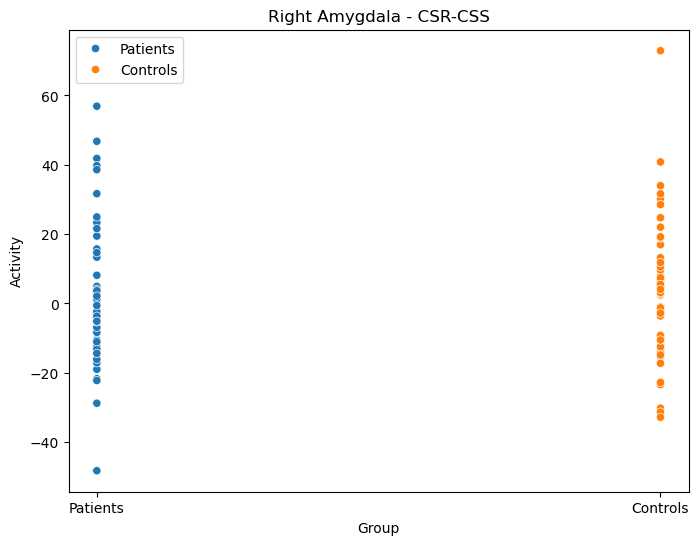

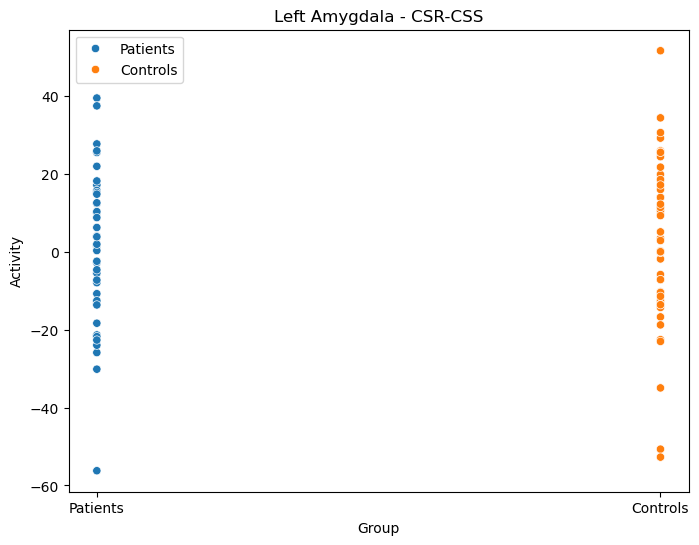

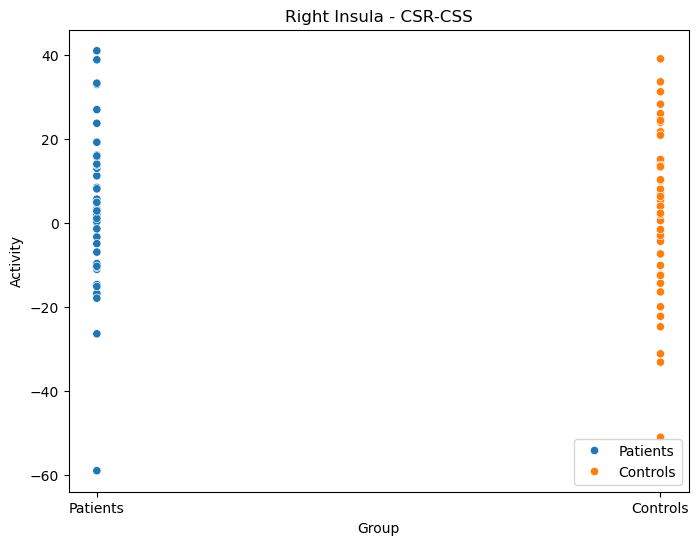

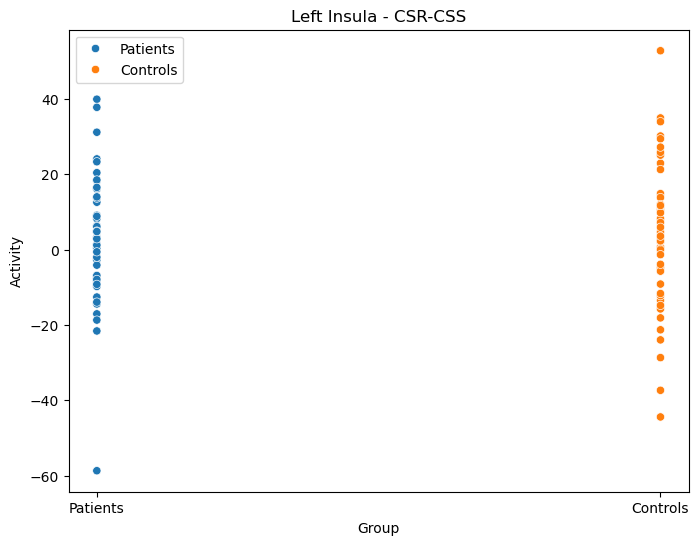

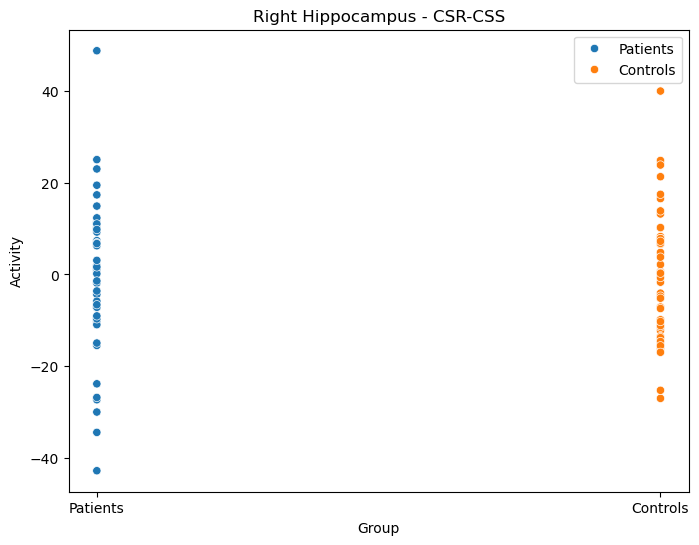

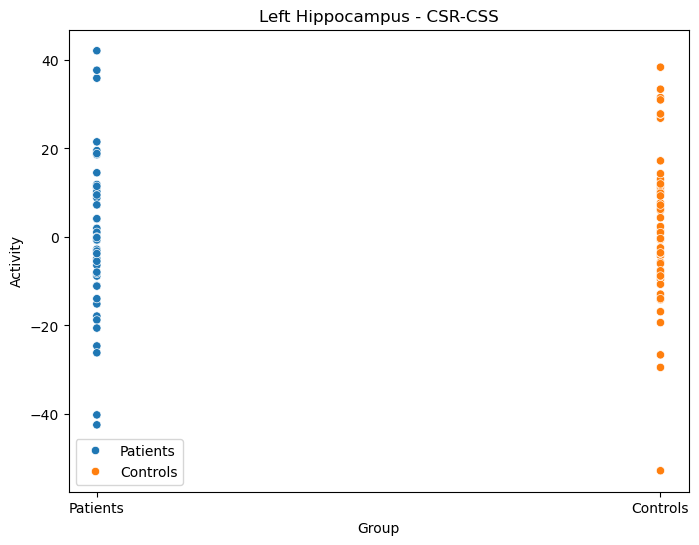

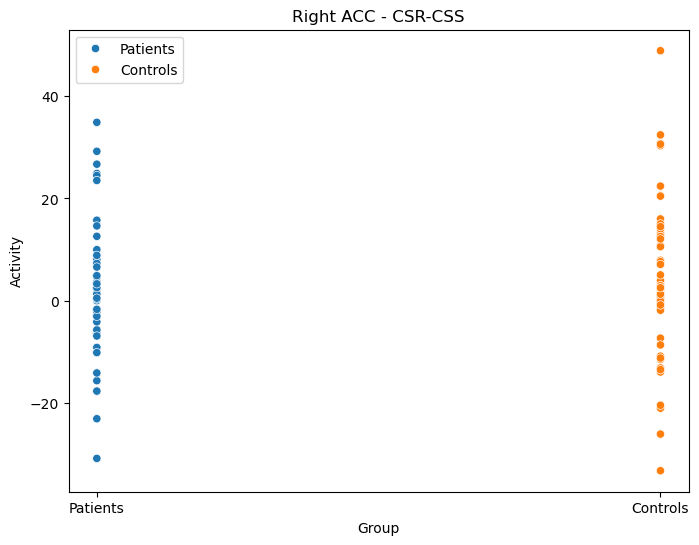

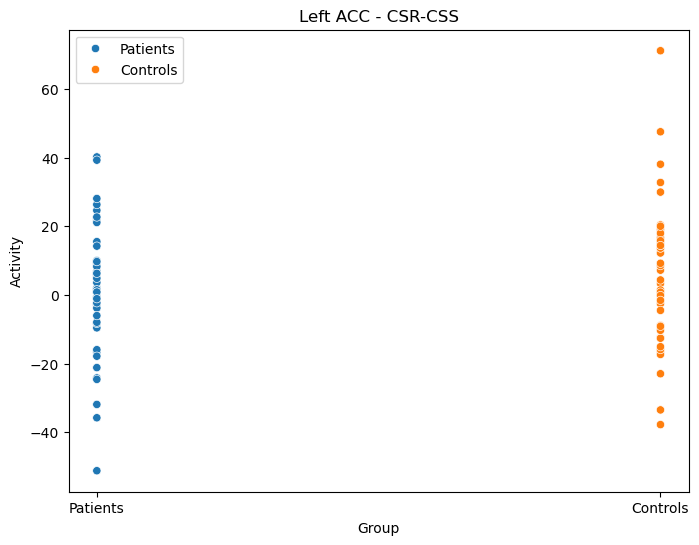

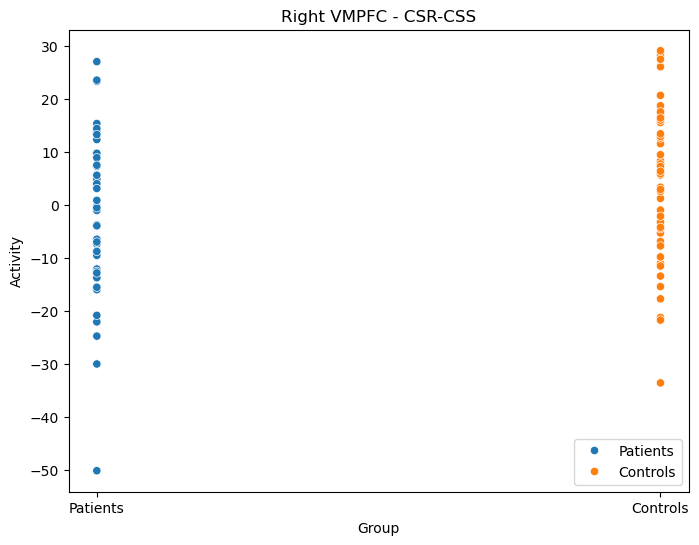

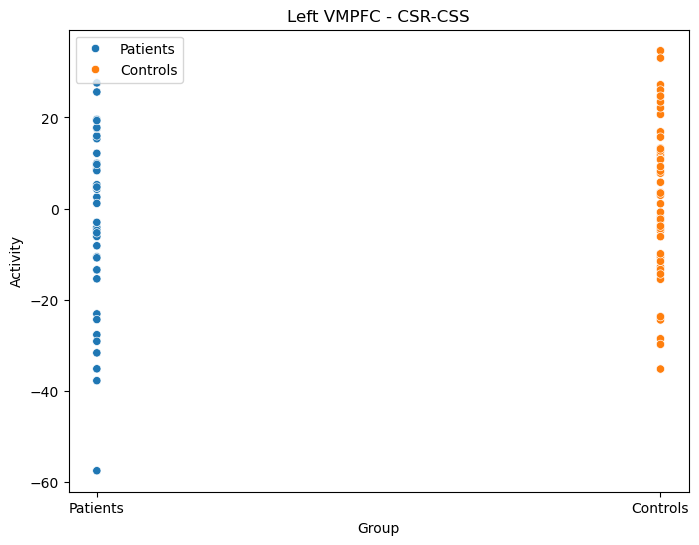

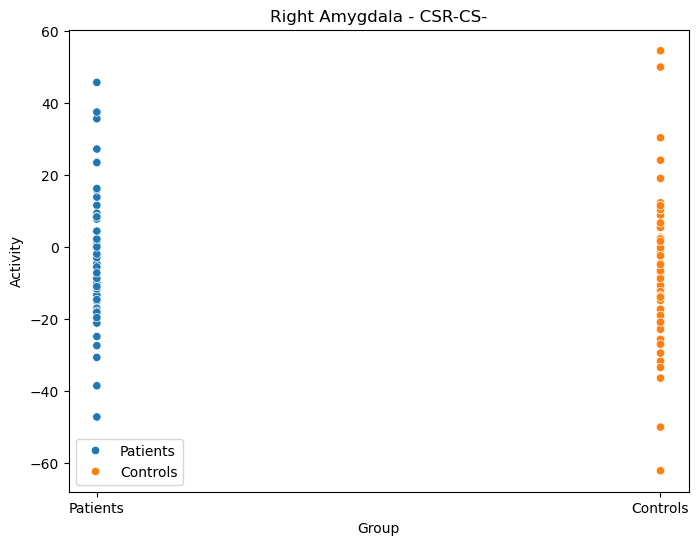

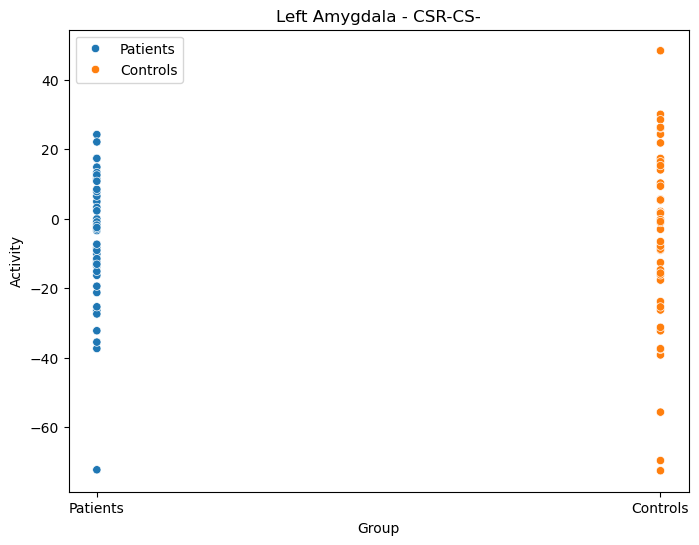

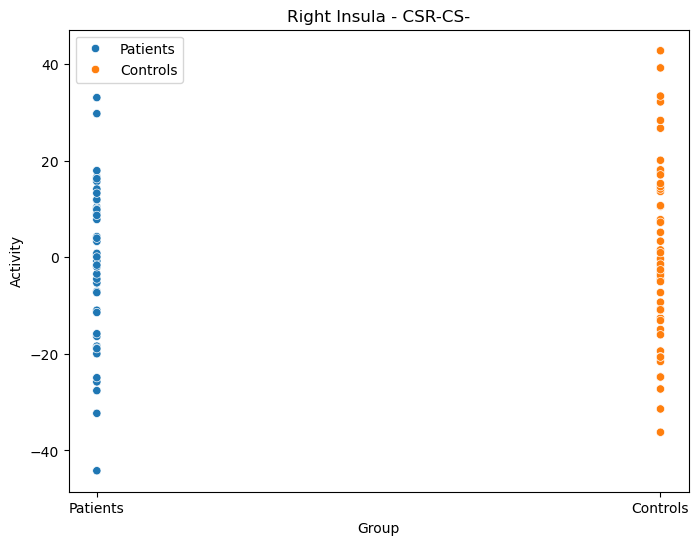

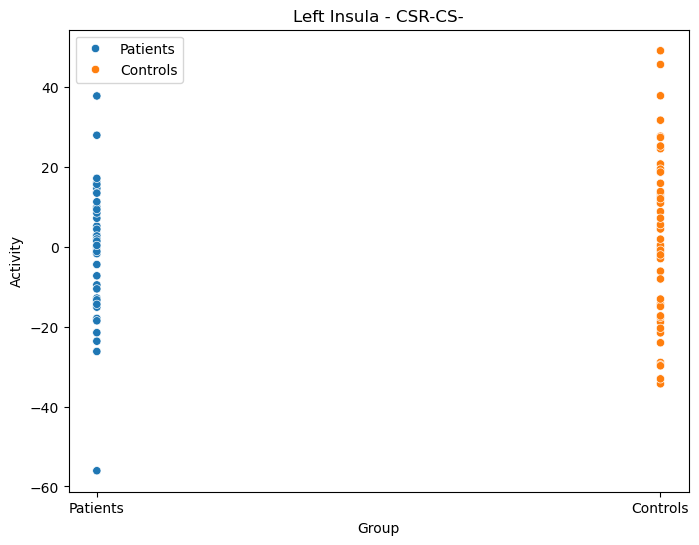

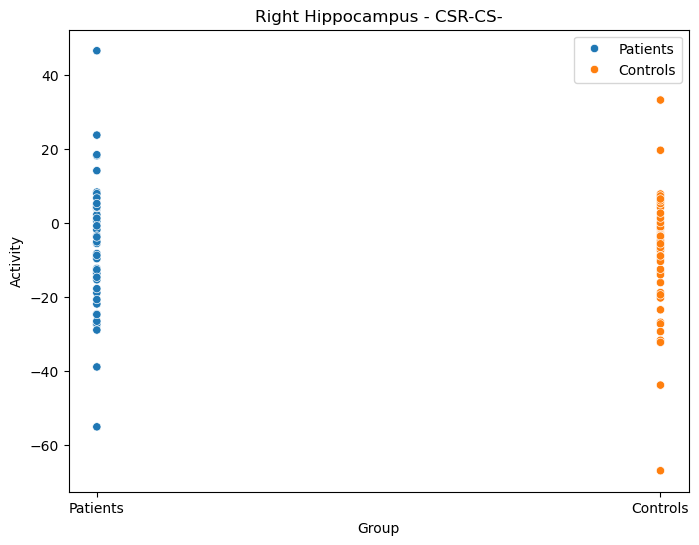

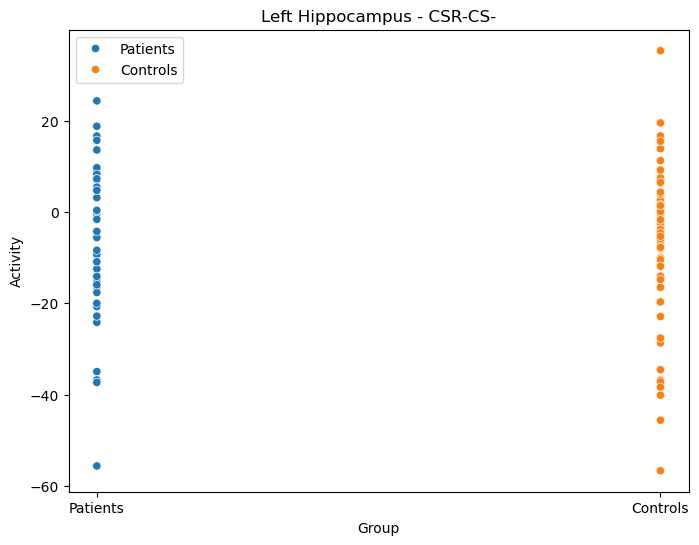

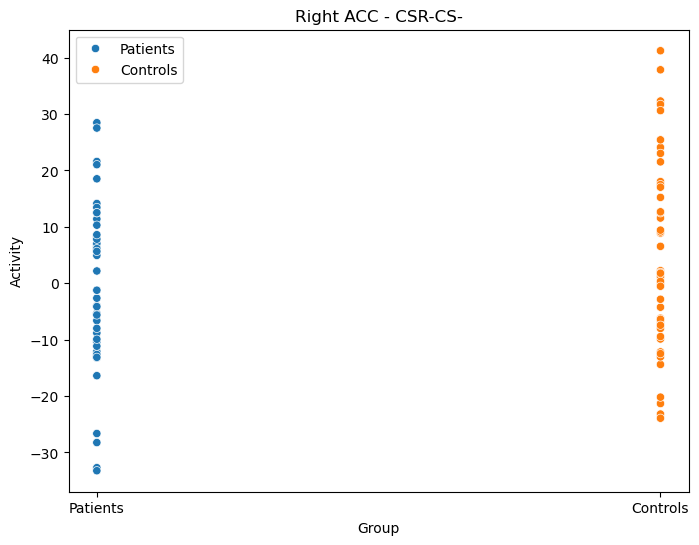

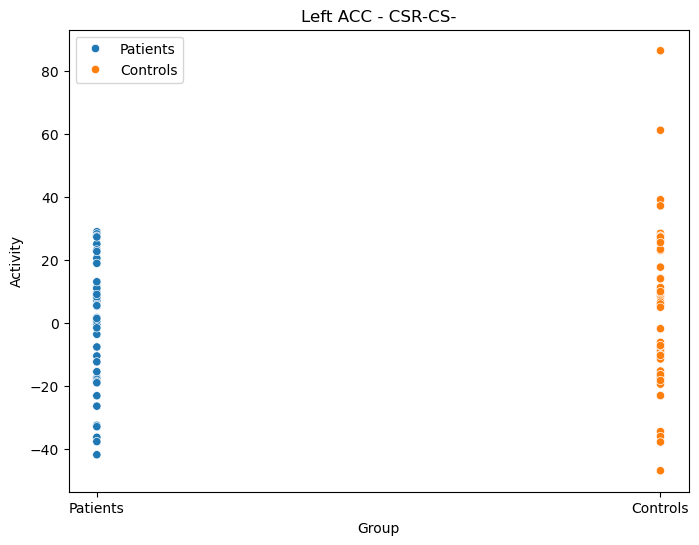

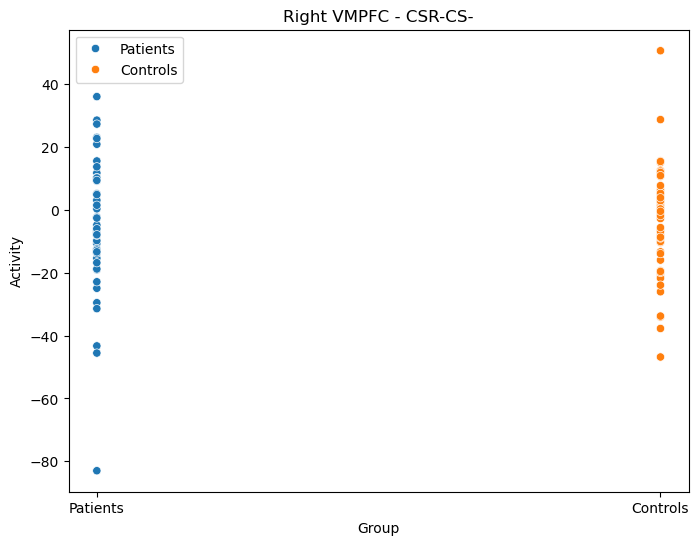

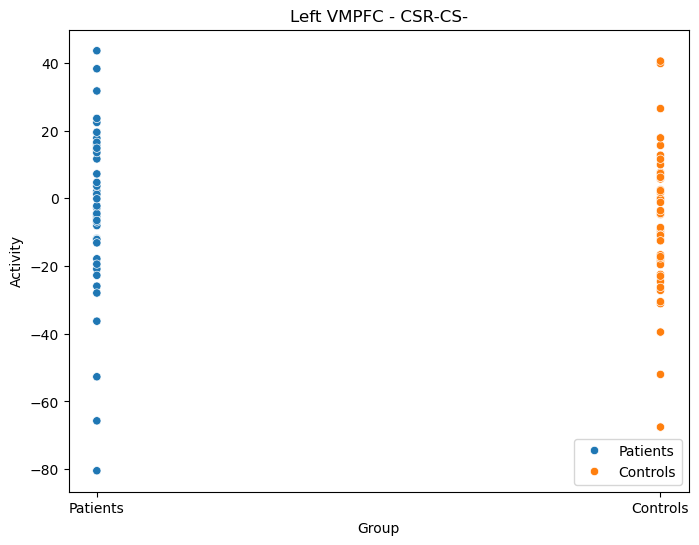

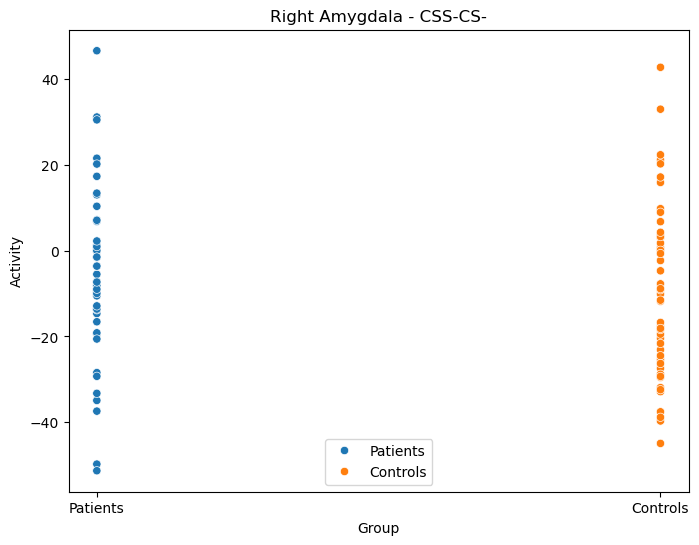

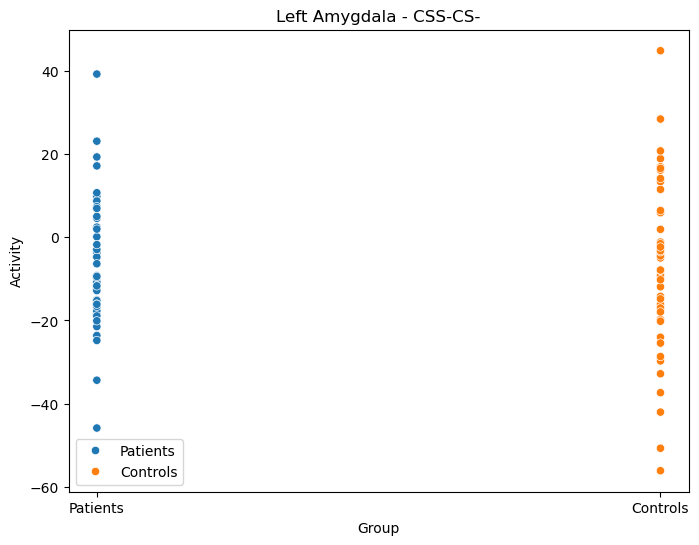

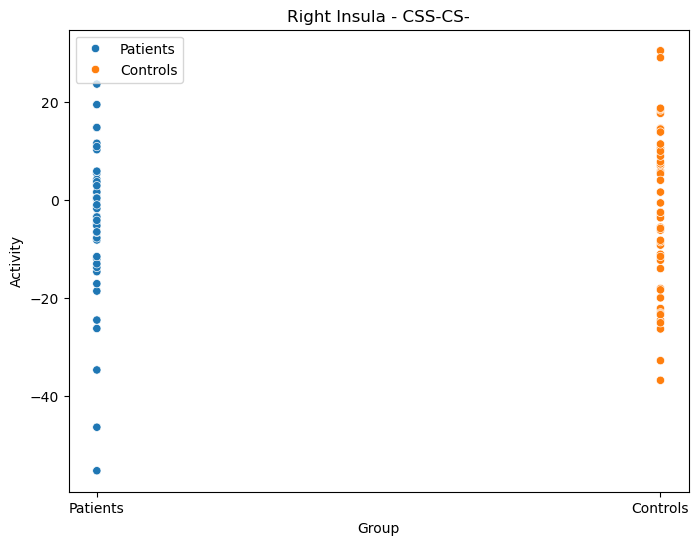

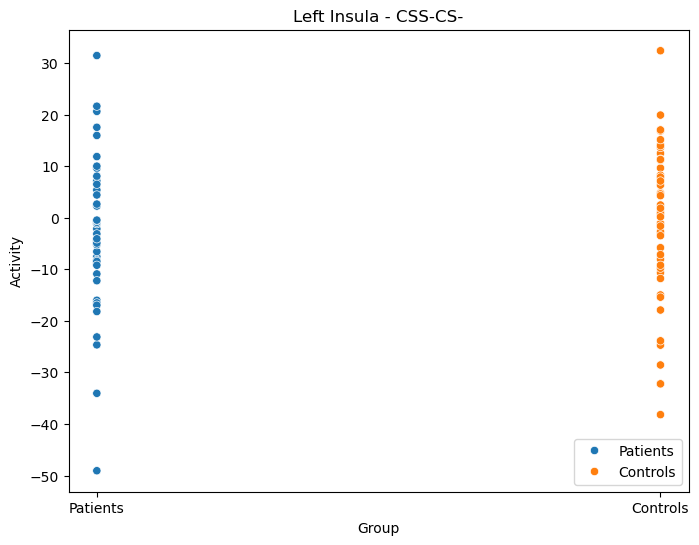

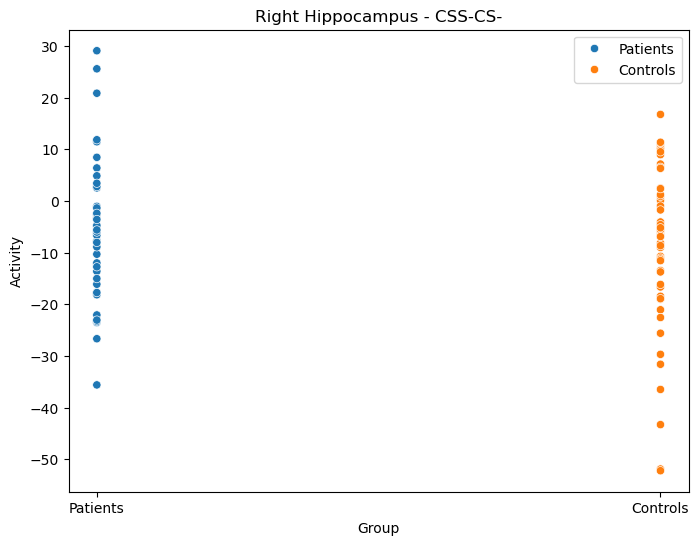

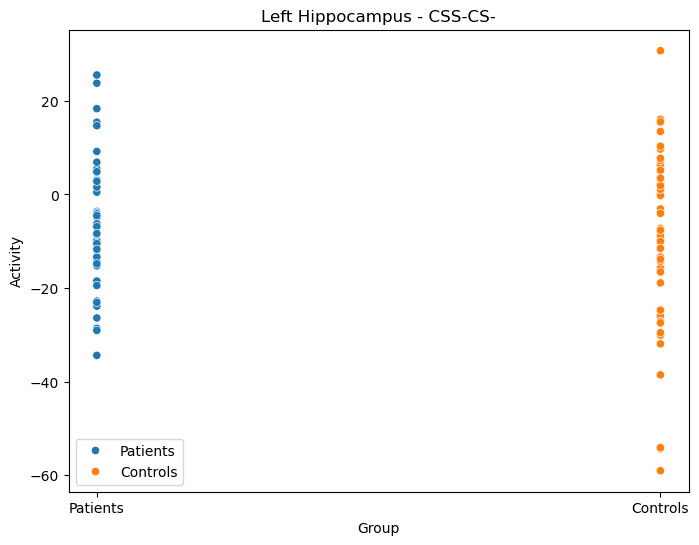

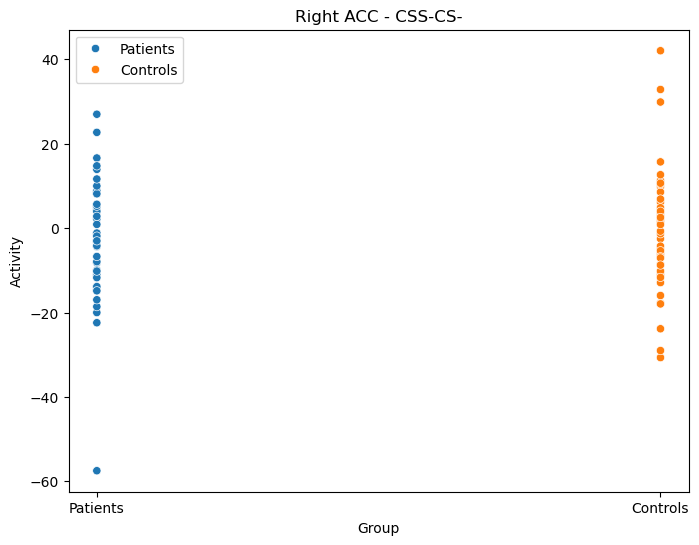

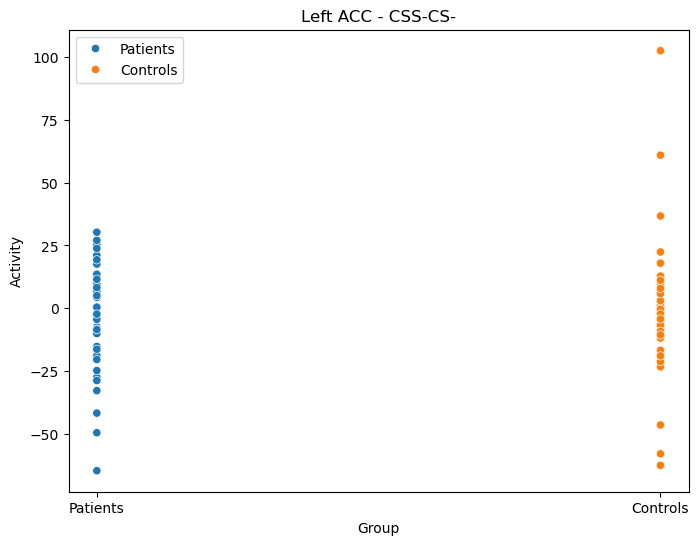

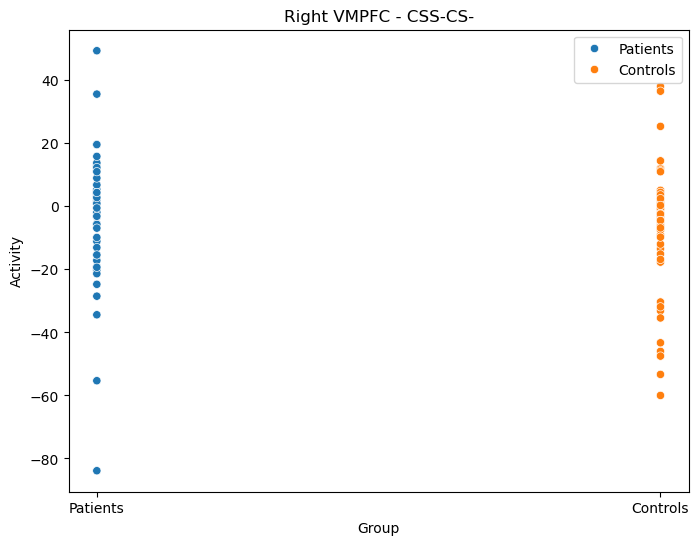

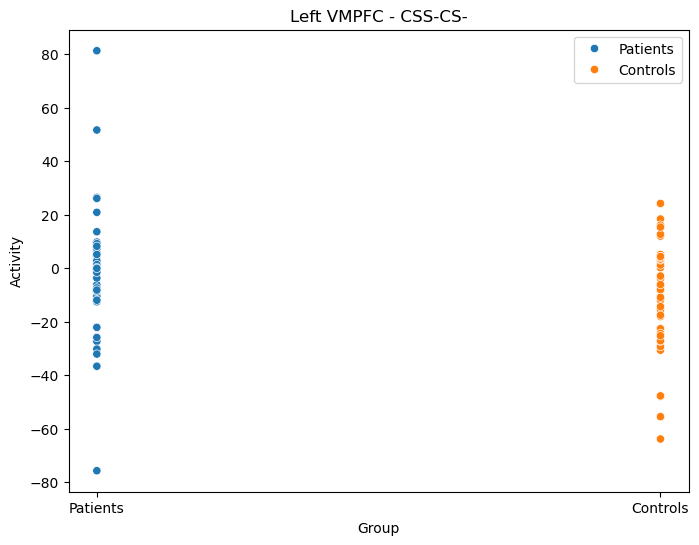

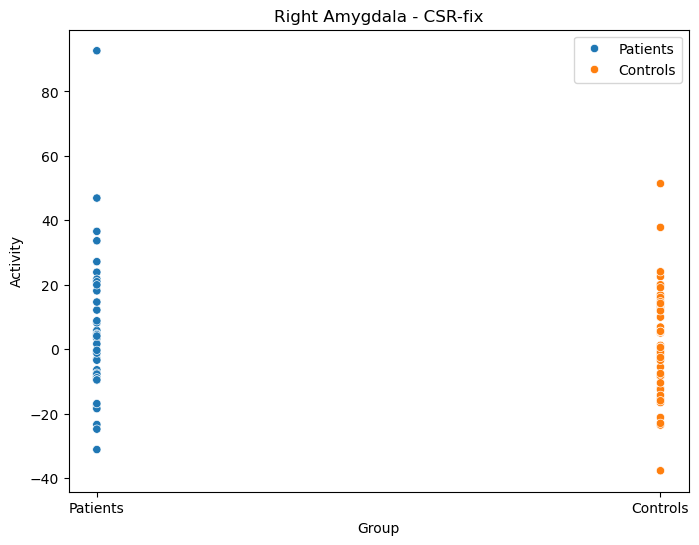

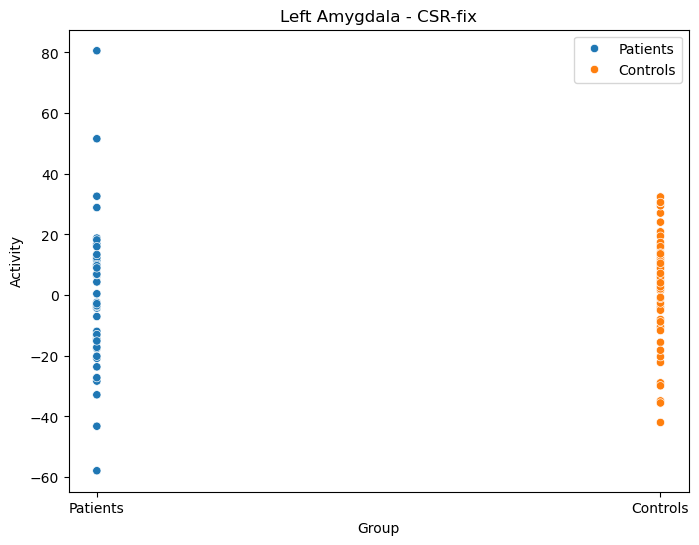

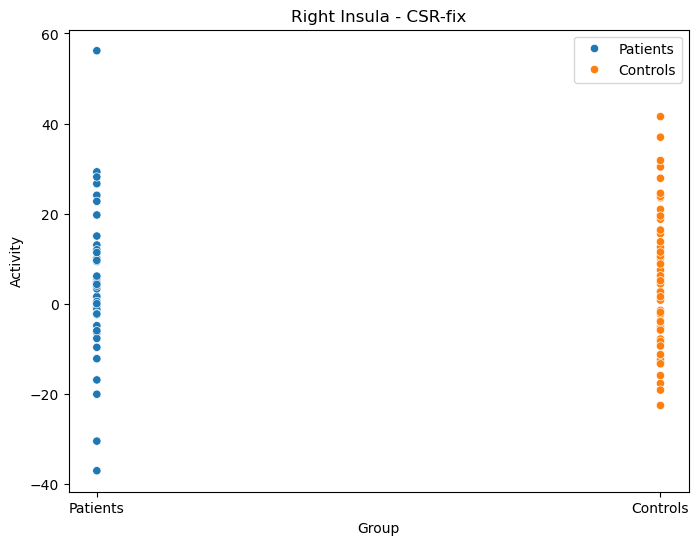

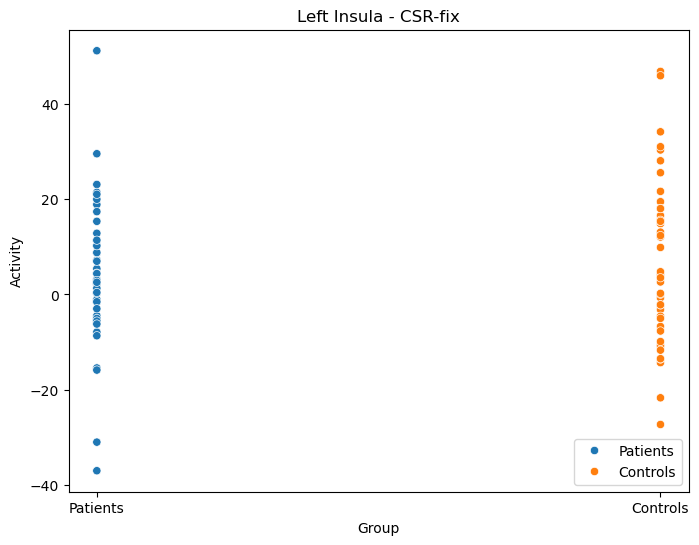

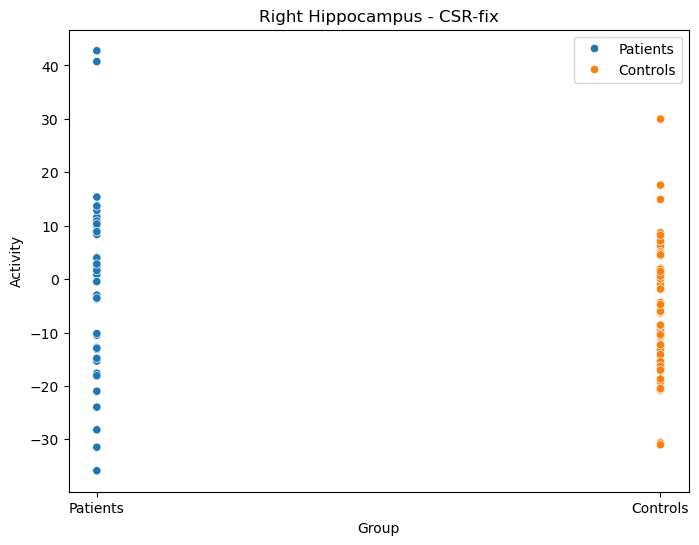

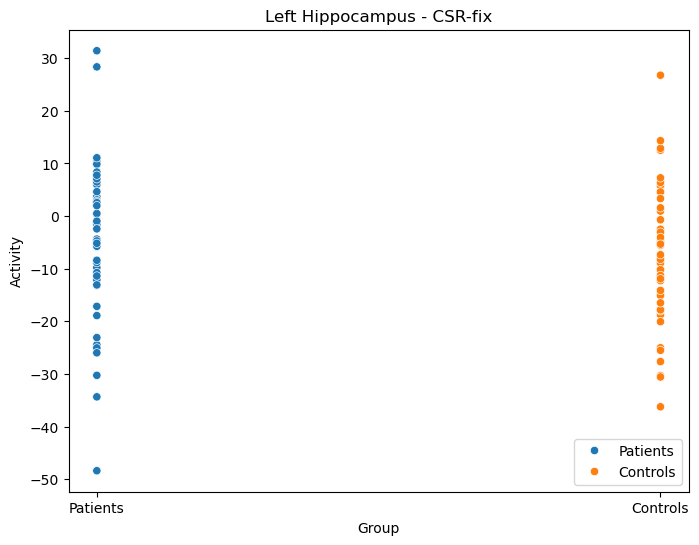

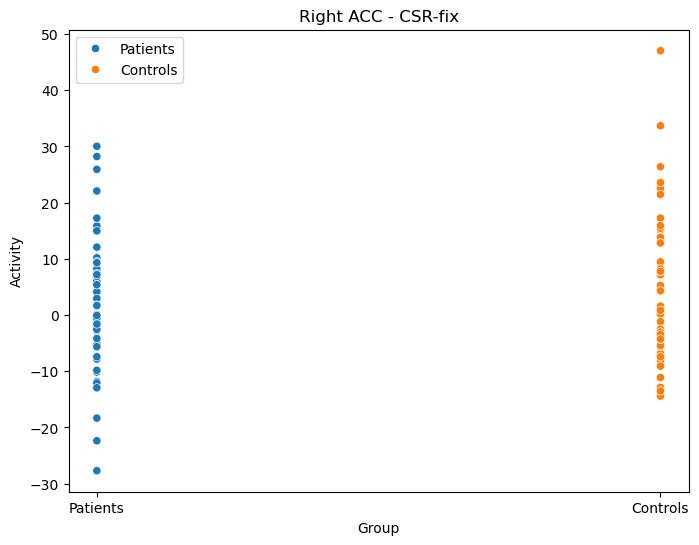

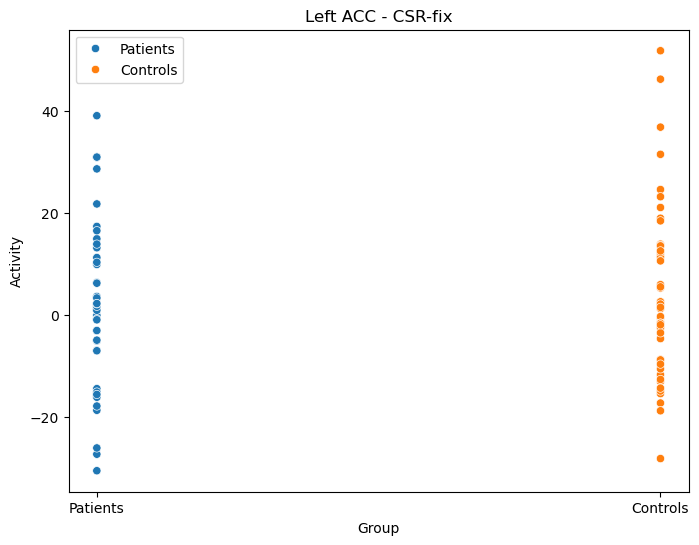

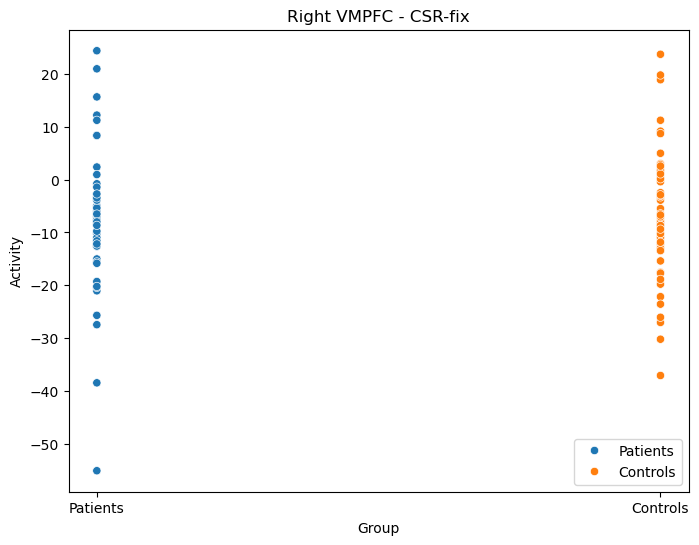

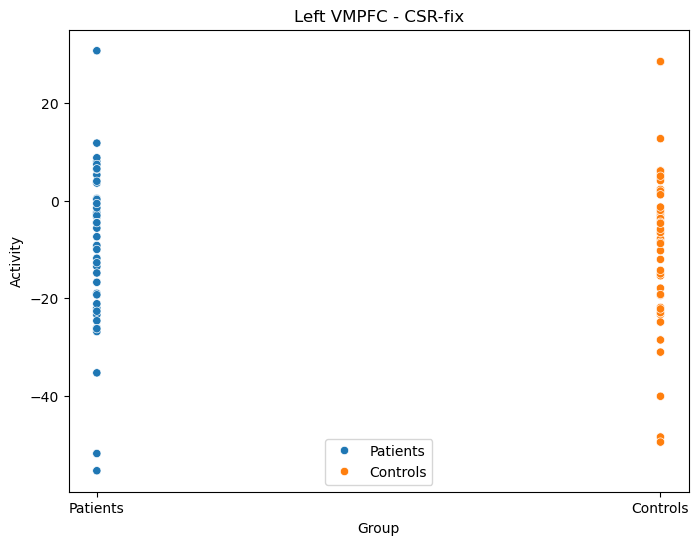

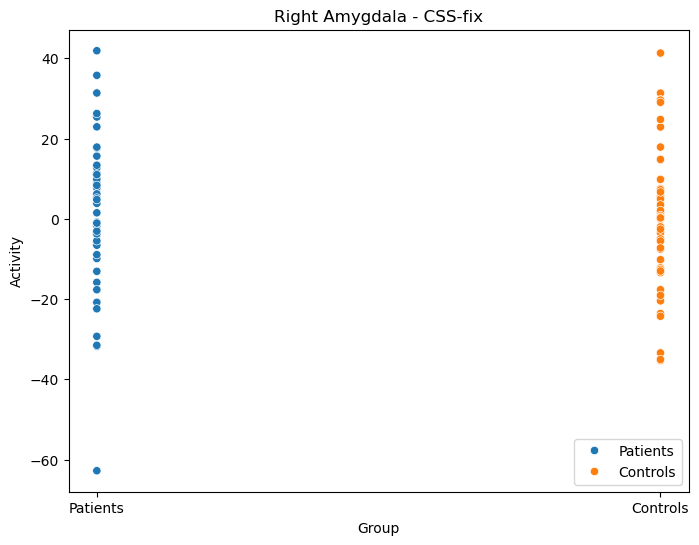

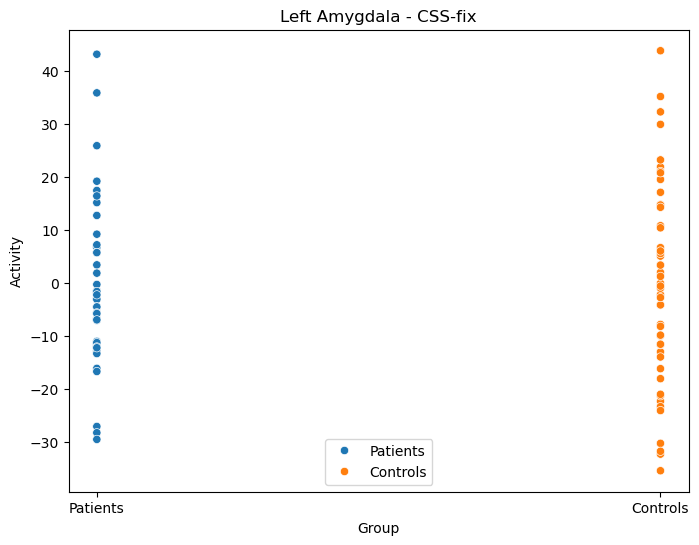

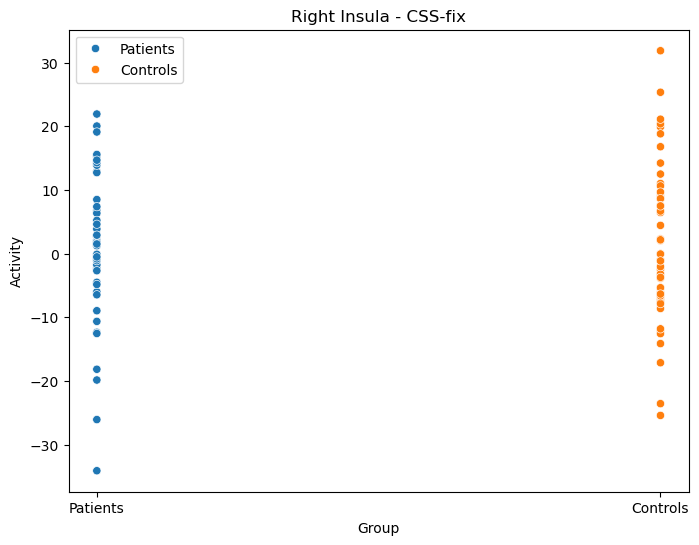

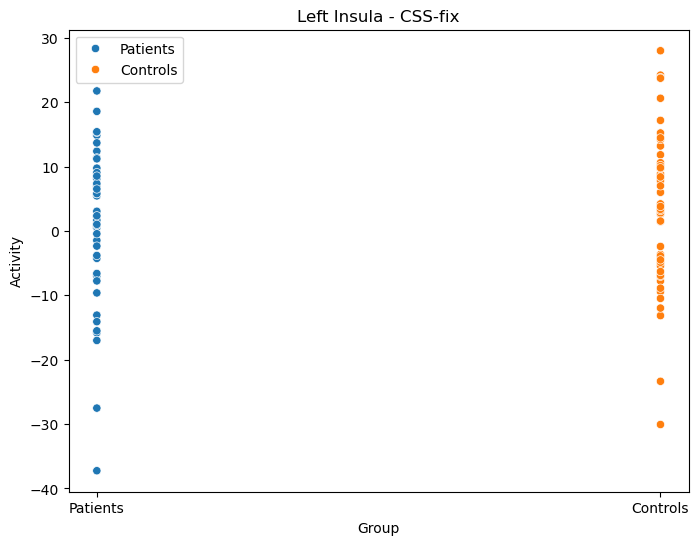

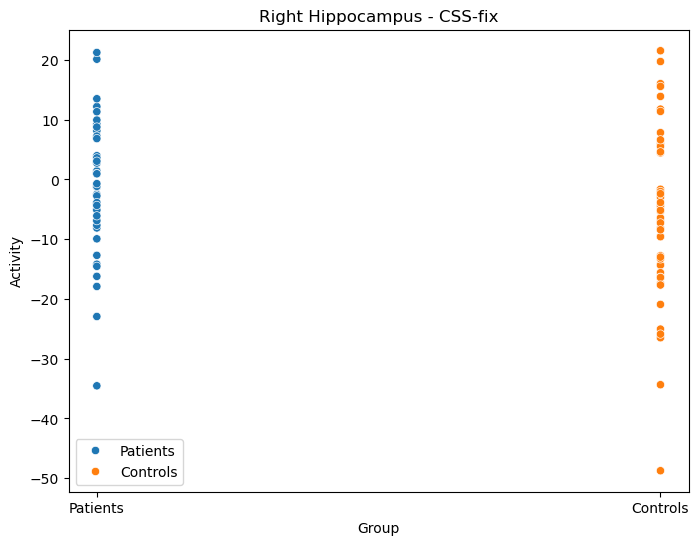

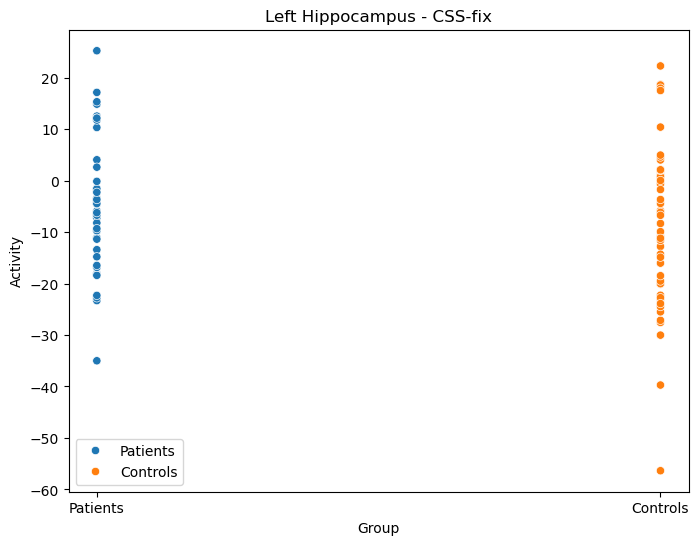

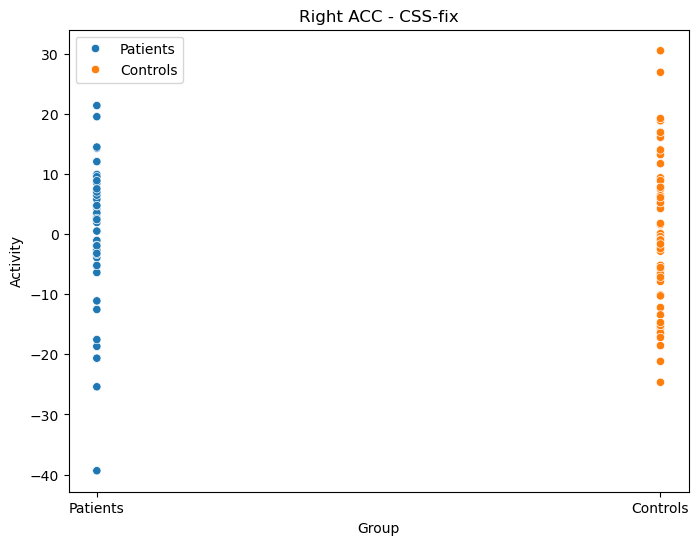

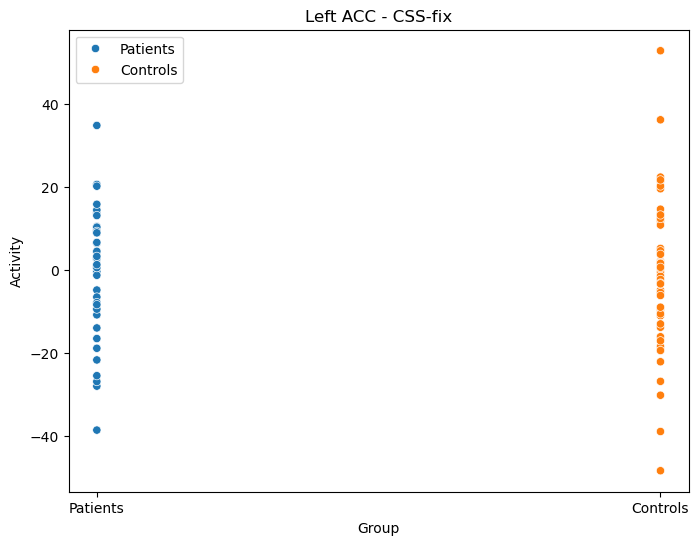

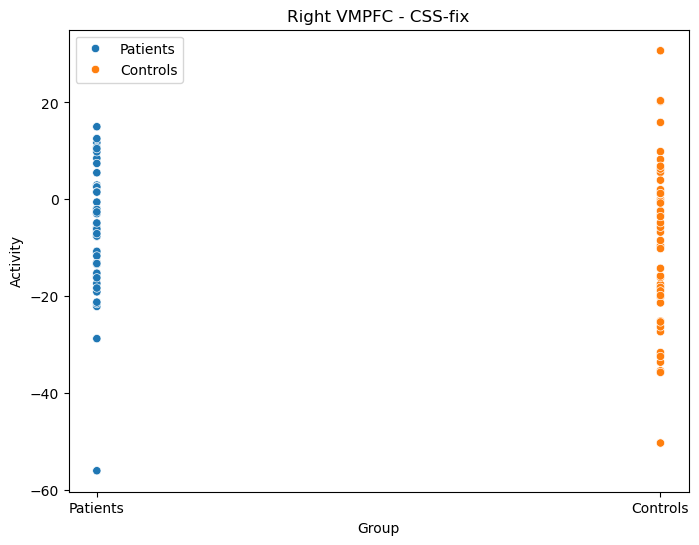

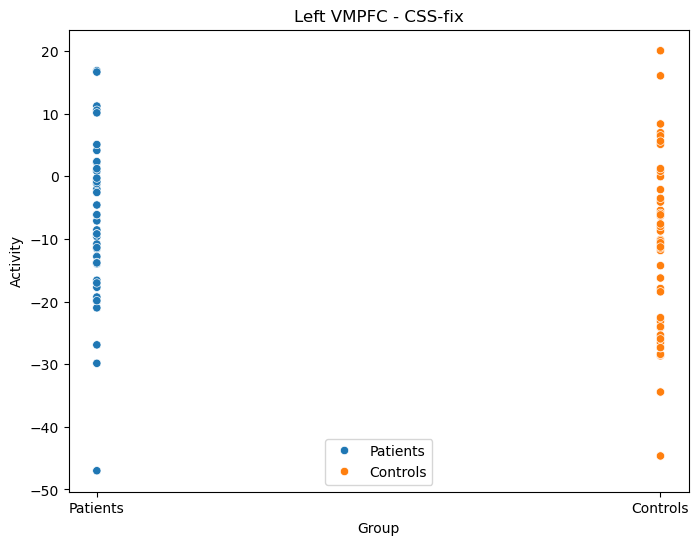

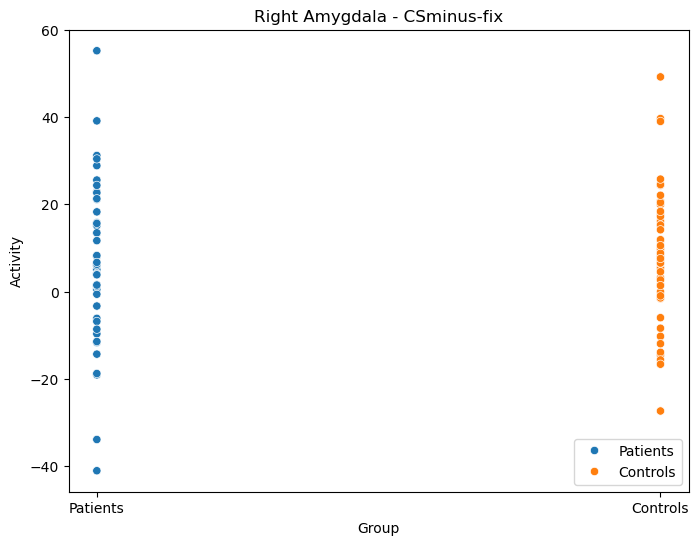

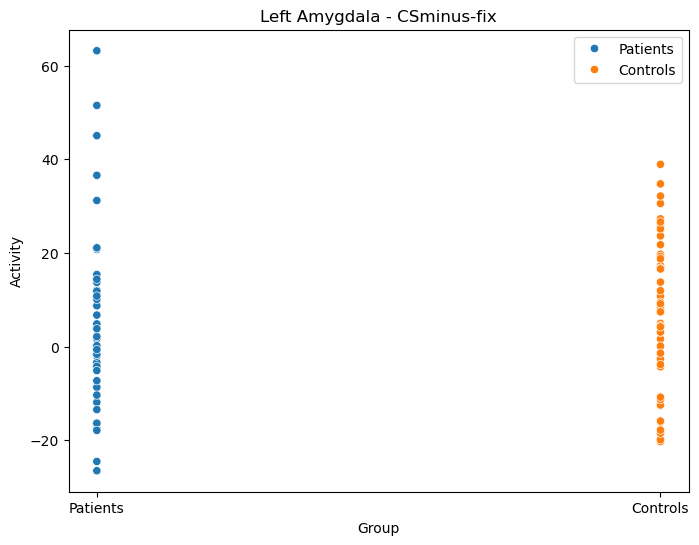

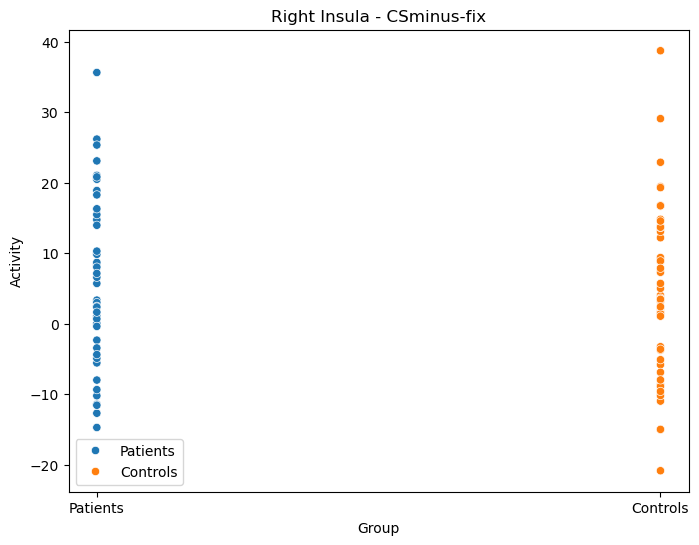

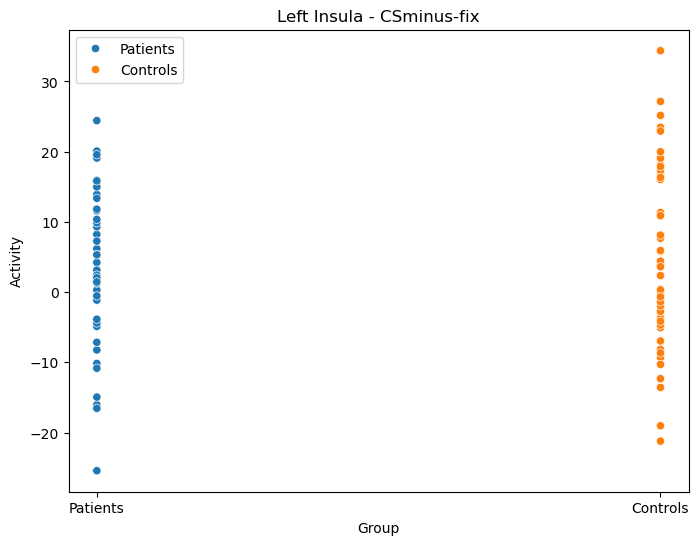

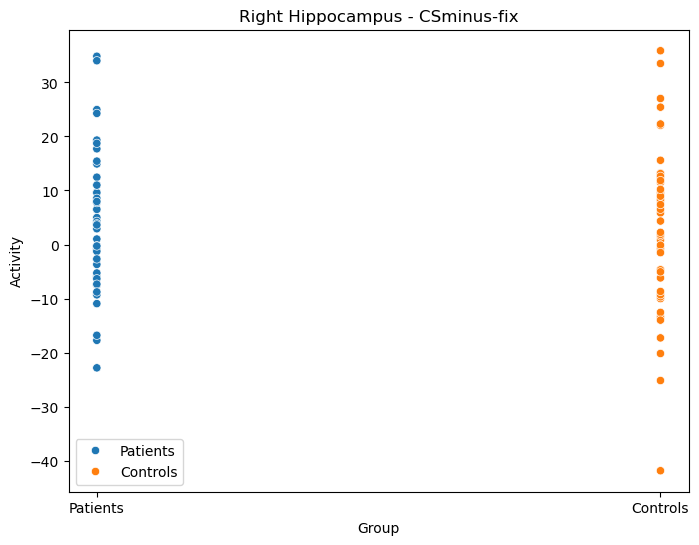

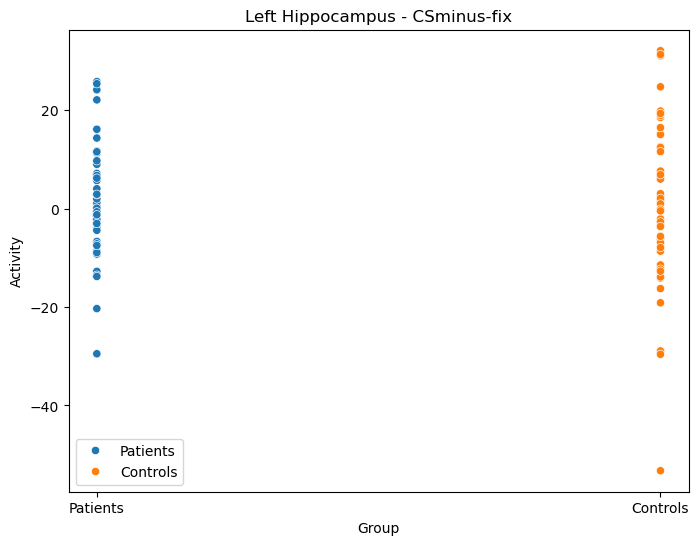

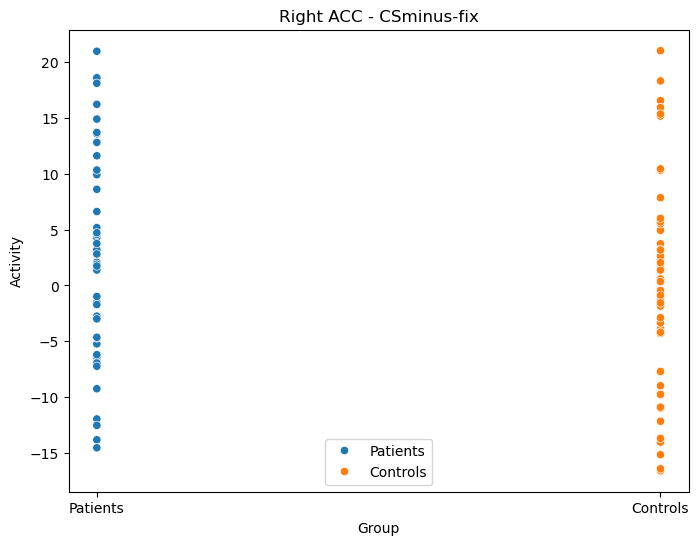

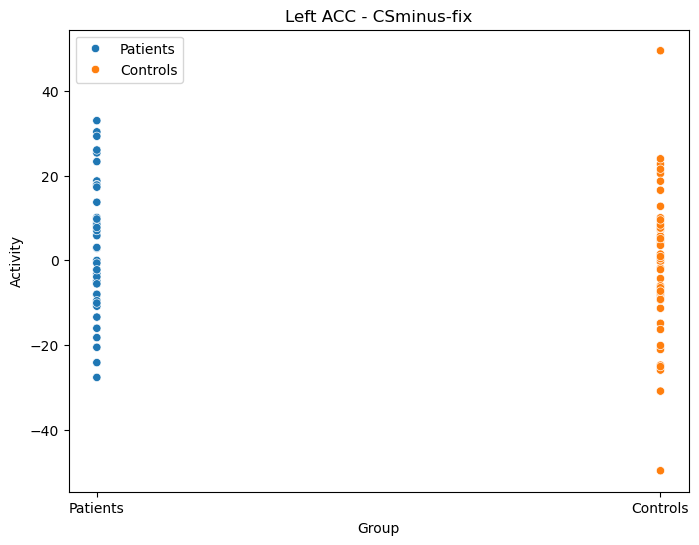

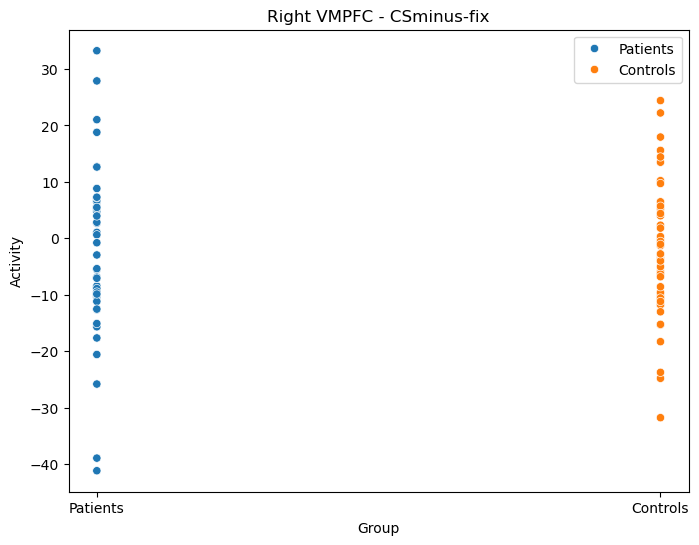

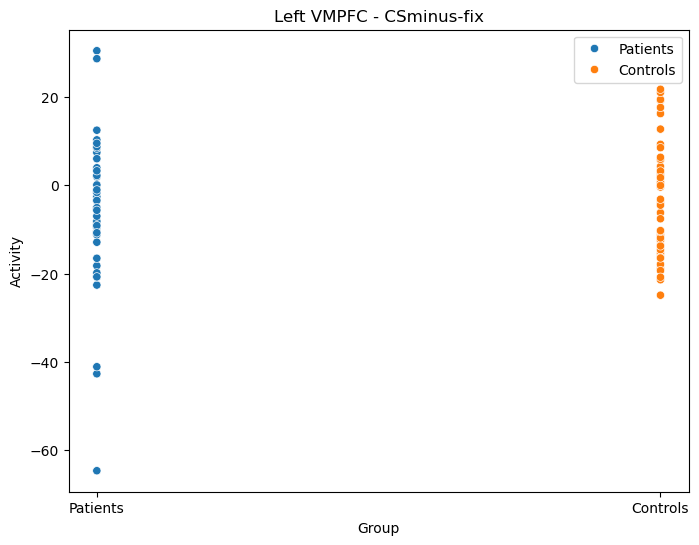

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume that `file_lists_phase3` and `sub_order_phase3` are already defined

# Define your regions of interest
regions_of_interest = [
    'Right Amygdala', 'Left Amygdala', 'Right Insula', 'Left Insula', 
    'Right Hippocampus', 'Left Hippocampus', 'Right ACC', 'Left ACC', 
    'Right VMPFC', 'Left VMPFC'
]

# Separate subjects into patients (N100s) and controls (N200s)
def separate_groups(sub_order):
    patients = [i for i, sub in enumerate(sub_order) if 'N1' in sub]
    controls = [i for i, sub in enumerate(sub_order) if 'N2' in sub]
    return patients, controls

# Define a function to create scatter plots
def plot_scatter(data, sub_order, region, region_no, contrast):
    patients, controls = separate_groups(sub_order)
    
    # Extract data for patients and controls
    patient_data = [data[i].effect_size() for i in patients]
    control_data = [data[i].effect_size() for i in controls]
    
    # Combine data and labels for scatter plot
    combined_data = np.concatenate([patient_data, control_data])
    combined_data = combined_data[:,:,region_no].flatten()
    group_labels = ['Patients'] * len(patient_data) + ['Controls'] * len(control_data)
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=group_labels, y=combined_data, hue=group_labels)
    plt.title(f'{region} - {contrast}')
    plt.xlabel('Group')
    plt.ylabel('Activity')
    plt.show()

# Iterate over each contrast and create plots for each region of interest
for contrast, sub_order in sub_order_phase3.items():
    for region_no, region in enumerate(regions_of_interest):
        region_data = file_lists_phase3[contrast]  # Extract data for this contrast
        plot_scatter(region_data, sub_order, region, region_no, contrast)


In [281]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define your regions of interest
regions_of_interest = [
    'Right Amygdala', 'Left Amygdala', 'Right Insula', 'Left Insula', 
    'Right Hippocampus', 'Left Hippocampus', 'Right ACC', 'Left ACC', 
    'Right VMPFC', 'Left VMPFC']

patient_data = []
control_data = []
# Separate subjects into patients (N100s) and controls (N200s)
def separate_groups(sub_order):
    patients = [i for i, sub in enumerate(sub_order) if 'N1' in sub]
    controls = [i for i, sub in enumerate(sub_order) if 'N2' in sub]
    return patients, controls

# Create a function to collect data across all regions and groups
def collect_data_for_plotting(data, sub_order):
    patients, controls = separate_groups(sub_order)
    
    all_data = []
    
    # Loop through each region
    for region_no, region in enumerate(regions_of_interest):
        # Extract data for patients and controls for the specific region
        patient_data = np.array([data[i].effect_size() for i in patients])
        patient_data = patient_data[:, :, region_no].flatten()
        control_data = np.array([data[i].effect_size() for i in controls])
        control_data = control_data[:, :, region_no].flatten()
        
        # Create labels for the data
        region_labels = [region] * (len(patient_data) + len(control_data))
        group_labels = ['Patients'] * len(patient_data) + ['Controls'] * len(control_data)
        
        # Store the data in a list of tuples (contrast, region, group, value)
        all_data += list(zip(region_labels, group_labels, np.concatenate([patient_data, control_data])))
    
    return all_data



plot_data = []

for contrast, sub_order in sub_order_phase3.items():
    region_data = file_lists_phase3[contrast]  # Extract data for this contrast
    plot_data += collect_data_for_plotting(region_data, sub_order)

    # Create a DataFrame from the collected data
    df = pd.DataFrame(np.array(plot_data), columns=['Region', 'Group', 'Activity'])    
  
    # Create a boxplot or swarmplot for all regions and groups
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Region', y='Activity', hue='Group', data=df, palette='Set2')
    plt.title(f'{contrast} -- Patients vs. Controls')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [346]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define your regions of interest
regions_of_interest = [
    'Right Amygdala', 'Left Amygdala', 'Right Insula', 'Left Insula', 
    'Right Hippocampus', 'Left Hippocampus', 'Right ACC', 'Left ACC', 
    'Right VMPFC', 'Left VMPFC'
]

patient_data = []
control_data = []

# Separate subjects into patients (N100s) and controls (N200s)
def separate_groups(sub_order):
    patients = [i for i, sub in enumerate(sub_order) if 'N100' in sub]
    controls = [i for i, sub in enumerate(sub_order) if 'N200' in sub]
    return patients, controls

# Function to collect data for all regions and contrasts
def collect_data(file_lists, sub_order, contrast):
    patients, controls = separate_groups(sub_order)
    
    # Initialize lists to store the data for all regions
    data = []
    
    for region_no, region in enumerate(regions_of_interest):
        # Extract data for the specific region and contrast
        patient_data = [file_lists[i].effect_size()[:, :, region_no].flatten() for i in patients]
        control_data = [file_lists[i].effect_size()[:, :, region_no].flatten() for i in controls]
        
        # Ensure patient_data and control_data are flattened correctly
        patient_data = np.concatenate(patient_data).flatten()
        control_data = np.concatenate(control_data).flatten()
        
        # Combine data for this region
        combined_data = np.concatenate([patient_data, control_data])
        group_labels = ['Patients'] * len(patient_data) + ['Controls'] * len(control_data)
        region_labels = [region] * len(combined_data)
        contrast_labels = [contrast] * len(combined_data)
        
        # Debugging to check lengths
        print(f"Region: {region}, Combined Data Length: {len(combined_data)}, Group Labels Length: {len(group_labels)}")
        
        # Append the data to a list
        data.append(pd.DataFrame({
            'Activity': combined_data,
            'Group': group_labels,
            'Region': region_labels,
            'Contrast': contrast_labels
        }))
    
    # Return the combined data as a DataFrame
    return pd.concat(data, ignore_index=True)

# Initialize an empty DataFrame to collect data from all contrasts
all_data = pd.DataFrame()

# Iterate over each contrast and collect data
for contrast, sub_order in sub_order_phase3.items():
    region_data = file_lists_phase3[contrast]  # Extract data for this contrast
    all_data = pd.concat([all_data, collect_data(region_data, sub_order, contrast)], ignore_index=True)

# Now plot everything on one figure
plt.figure(figsize=(12, 8))
sns.catplot(data=all_data, x='Region', y='Activity', hue='Group', kind='strip', jitter=True, dodge=True)
plt.title('Comparison of Activity Between Patients and Controls Across Regions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ValueError: need at least one array to concatenate

In [1]:
import seaborn as sns
df = sns.load_dataset("titanic")
sns.catplot(data=df, x="age", y="class")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/trait

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
pip uninstall numpy
Y

In [340]:
table = pd.DataFrame(all_data)    
  
# # Create a boxplot or swarmplot for all regions and groups
# plt.figure(figsize=(12, 8))
# sns.boxplot(x='Region', y='Activity', hue='Group', data=df, palette='Set2')
# plt.title(f'{contrast} -- Patients vs. Controls')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
patient_data = np.array([data[i].effect_size for i in patients])[:, :, region_no].flatten()
control_data = np.array([data[i].effect_size for i in controls])[:, :, region_no].flatten()

# Create labels for the data
region_labels = [region] * (len(patient_data) + len(control_data))
group_labels = ['Patients'] * len(patient_data) + ['Controls'] * len(control_data)

# Store the data in a list of tuples (contrast, region, group, value)
all_data += list(zip(region_labels, group_labels, np.concatenate([patient_data, control_data])))


In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define your regions of interest
regions_of_interest = [
    'Right Amygdala', 'Left Amygdala', 'Right Insula', 'Left Insula', 
    'Right Hippocampus', 'Left Hippocampus', 'Right ACC', 'Left ACC', 
    'Right VMPFC', 'Left VMPFC'
]

# Separate subjects into patients (N100s) and controls (N200s)
def separate_groups(sub_order):
    patients = [i for i, sub in enumerate(sub_order) if 'N100' in sub]
    controls = [i for i, sub in enumerate(sub_order) if 'N200' in sub]
    return patients, controls

# Function to collect data for all regions and contrasts
def collect_data(file_lists, sub_order, contrast):
    patients, controls = separate_groups(sub_order)
    
    # Initialize lists to store the data for all regions
    data = []
    
    for region_no, region in enumerate(regions_of_interest):
        # Extract data for the specific region and contrast
        patient_data = [file_lists[i].effect_size()[:, :, region_no].flatten() for i in patients]
        control_data = [file_lists[i].effect_size()[:, :, region_no].flatten() for i in controls]
        
        # Combine data for this region
        combined_data = np.concatenate([patient_data, control_data])
        group_labels = ['Patients'] * len(patient_data) + ['Controls'] * len(control_data)
        region_labels = [region] * len(combined_data)
        contrast_labels = [contrast] * len(combined_data)
        
        # Append the data to a list
        data.append(pd.DataFrame({
            'Activity': combined_data,
            'Group': group_labels,
            'Region': region_labels,
            'Contrast': contrast_labels
        }))
    
    # Return the combined data as a DataFrame
    return pd.concat(data, ignore_index=True)

# Initialize an empty DataFrame to collect data from all contrasts
all_data = pd.DataFrame()

# Iterate over each contrast and collect data
for contrast, sub_order in sub_order_phase3.items():
    region_data = file_lists_phase3[contrast]  # Extract data for this contrast
    all_data = pd.concat([all_data, collect_data(region_data, sub_order, contrast)], ignore_index=True)

# Now plot everything on one figure
plt.figure(figsize=(12, 8))
sns.catplot(data=all_data, x='Region', y='Activity', hue='Group', kind='strip', jitter=True, dodge=True)
plt.title('Comparison of Activity Between Patients and Controls Across Regions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


TypeError: to_dict() takes from 1 to 2 positional arguments but 4 were given

<Figure size 1200x800 with 0 Axes>

In [182]:
patients, controls = separate_groups(sub_order)
data = region_data

In [197]:
patient_data = [data[i].effect_size() for i in patients]

In [204]:
patient_data = [data[i].effect_size() for i in patients]
control_data = [data[i].effect_size() for i in controls]

# Combine data and labels for scatter plot
combined_data = np.concatenate([patient_data, control_data])
combined_data.shape

(95, 1, 10)

In [211]:
new = combined_data[:,:,0].flatten()

In [269]:
df = pd.DataFrame(second_level_input)

# Alternatively, save the DataFrame to an Excel file
df.to_excel('second_level_input3.xlsx', index=False)

In [225]:
df = pd.DataFrame(sub_order)

# Alternatively, save the DataFrame to an Excel file
df.to_excel('sub_order.xlsx', index=False)